In [2]:
%matplotlib inline
# makes text object editable in Adobe Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import multiprocess as mp
import numpy as np
import pandas as pd
import six
import re
import pypairix
import bioframe
import cooler
import cooltools
import traceback as tb
import cooltools.saddle
import bbi
import warnings
import pyBigWig as pb
import itertools as it
import dask.dataframe as dd
from dask.base import tokenize
from bioframe.dask import _fetch_region
from cooltools.expected import compute_scaling, diagsum, blocksum_pairwise
from cooltools.eigdecomp import cooler_cis_eig, _phase_eigs
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from matplotlib import colors
from scipy.linalg import eigh
from scipy.stats import rankdata
from cooltools.lib.numutils import get_eig
from cooltools.directionality import dirscore
from cooltools.lib import peaks, numutils
from cooltools import snipping
from scipy.interpolate import interp2d
from functools import partial 
from pybedtools import BedTool
from cooltools.lib.numutils import LazyToeplitz

# copy from https://github.com/mirnylab/bioframe
# necessary since PyPi package is different and does not support the functions used by cooltools
def parse_humanized(s):
    _NUMERIC_RE = re.compile('([0-9,.]+)')
    _, value, unit = _NUMERIC_RE.split(s.replace(',', ''))
    if not len(unit):
        return int(value)

    value = float(value)
    unit = unit.upper().strip()
    if unit in ('K', 'KB'):
        value *= 1000
    elif unit in ('M', 'MB'):
        value *= 1000000
    elif unit in ('G', 'GB'):
        value *= 1000000000
    else:
        raise ValueError("Unknown unit '{}'".format(unit))
    return int(value)


def parse_region_string(s):
    """
    Parse a UCSC-style genomic region string into a triple.
    Parameters
    ----------
    s : str
        UCSC-style string, e.g. "chr5:10,100,000-30,000,000". Ensembl and FASTA
        style sequence names are allowed. End coordinate must be greater than or
        equal to start.
    Returns
    -------
    (str, int or None, int or None)
    """
    def _tokenize(s):
        token_spec = [
            ('HYPHEN', r'-'),
            ('COORD',  r'[0-9,]+(\.[0-9]*)?(?:[a-z]+)?'),
            ('OTHER',  r'.+')
        ]
        tok_regex = r'\s*' + r'|\s*'.join(
            r'(?P<%s>%s)' % pair for pair in token_spec)
        tok_regex = re.compile(tok_regex, re.IGNORECASE)
        for match in tok_regex.finditer(s):
            typ = match.lastgroup
            yield typ, match.group(typ)


    def _check_token(typ, token, expected):
        if typ is None:
            raise ValueError('Expected {} token missing'.format(
                ' or '.join(expected)))
        else:
            if typ not in expected:
                raise ValueError('Unexpected token "{}"'.format(token))


    def _expect(tokens):
        typ, token = next(tokens, (None, None))
        _check_token(typ, token, ['COORD'])
        start = parse_humanized(token)

        typ, token = next(tokens, (None, None))
        _check_token(typ, token, ['HYPHEN'])

        typ, token = next(tokens, (None, None))
        if typ is None:
            return start, None

        _check_token(typ, token, ['COORD'])
        end = parse_humanized(token)
        if end < start:
            raise ValueError('End coordinate less than start')

        return start, end

    parts = s.split(':')
    chrom = parts[0].strip()
    if not len(chrom):
        raise ValueError("Chromosome name cannot be empty")
    if len(parts) < 2:
        return (chrom, None, None)
    start, end = _expect(_tokenize(parts[1]))
    return (chrom, start, end)


def parse_region(reg, chromsizes=None):
    """
    Genomic regions are represented as half-open intervals (0-based starts,
    1-based ends) along the length coordinate of a contig/scaffold/chromosome.
    Parameters
    ----------
    reg : str or tuple
        UCSC-style genomic region string, or
        Triple (chrom, start, end), where ``start`` or ``end`` may be ``None``.
    chromsizes : mapping, optional
        Lookup table of scaffold lengths to check against ``chrom`` and the
        ``end`` coordinate. Required if ``end`` is not supplied.
    Returns
    -------
    A well-formed genomic region triple (str, int, int)
    """
    if isinstance(reg, six.string_types):
        chrom, start, end = parse_region_string(reg)
    else:
        chrom, start, end = reg
        start = int(start) if start is not None else start
        end = int(end) if end is not None else end

    try:
        clen = chromsizes[chrom] if chromsizes is not None else None
    except KeyError:
        raise ValueError("Unknown sequence label: {}".format(chrom))

    start = 0 if start is None else start
    if end is None:
        end = clen # if clen is None, end is None too!

    if (end is not None) and (end < start):
        raise ValueError("End cannot be less than start")

    if start < 0 or (clen is not None and end > clen):
        raise ValueError(
            "Genomic region out of bounds: [{}, {})".format(start, end))

    return chrom, start, end


def _find_block_span(arr, val):
    '''Find the first and the last occurence + 1 of the value in the array.
    '''
    # it can be done via bisection, but for now BRUTE FORCE
    block_idxs = np.where(arr==val)[0]
    lo, hi = block_idxs[0], block_idxs[-1]+1
    return lo,hi


def bedbisect(bedf, region):
    """Returns the span of a block of rows corresponding to
    the genomic region.
    Rows must be sorted by `start` and `end`;
    `chrom` must be grouped, but does not have to be sorted.
    """
    chrom, start, end = parse_region(region)

    lo, hi = _find_block_span(bedf.chrom.values, chrom)

    lo += bedf['end'].values[lo:hi].searchsorted(start, side='right')
    if end is not None:
        hi = lo + bedf['start'].values[lo:hi].searchsorted(end, side='left')
    #else:
    #   hi = None This only works when bedf is a groupby object.
    return lo, hi


def bedslice(bedf, region):
    """Returns a block of rows corresponding to the genomic region.
    Rows must be sorted by `start` and `end`;
    `chrom` must be grouped, but does not have to be sorted.
    """
    lo, hi = bedbisect(bedf, region)
    return bedf.iloc[lo:hi]


def bin2start(k):
    lev = np.floor(np.log2(7*k + 1)/3).astype(int)
    sl = 2**(29 - 3*lev)
    ol = (2**(3*lev) - 1)//7
    start = (k - ol) * sl
    end = (k - ol+1) * sl
    return start

LEVEL = {}
LEVEL[0] = bin2start(np.arange(1, 9))
LEVEL[1] = bin2start(np.arange(9, 73))
LEVEL[2] = bin2start(np.arange(73,585))
LEVEL[3] = bin2start(np.arange(585,4681))
LEVEL[4] = bin2start(np.arange(4681,37449))

def expand_bins(df, resolution, value_col):
    expandables = (df.end - df.start) > resolution
    expanded = []
    for i, bin in df[expandables].iterrows():
        for j in range((bin['end'] - bin['start'])//resolution):
            expanded.append([bin['chrom'], 
                             bin['start'] + resolution*j, 
                             bin['start'] + resolution*(j+1), bin[value_col]])
            
    df.drop(df[expandables].index, axis = 'index', inplace = True)
    
    expandedDf = pd.DataFrame(expanded,
                              columns = ['chrom', 'start', 'end', value_col])
    
    df = df.merge(expandedDf, 
                  on = ['chrom', 'start', 'end'], 
                  how = 'outer',
                  sort = True) \
           .rename(columns = {value_col + '_x': value_col})
    
    df.loc[:, value_col] = df[value_col].fillna(df[value_col + '_y'])
    return df.drop(value_col + '_y', axis = 'columns')


def read_insulation_score(bgfile, resolution, reference_df = None):
    insul = pd.read_csv(bgfile,
                        sep = '\t',
                        header = None,
                        names = ['chrom', 'start', 'end', 'insulation_score'])
    
    insul = expand_bins(insul, resolution, 'insulation_score')
    
    if reference_df:
        ref_df, ref_col = reference_df
        insul = ref_df.merge(insul, on = ['chrom', 'start'], how = 'left')\
                      .rename(columns = {'end_x': 'end'})
        insul.loc[insul[ref_col].isna(), 'insulation_score'] = np.nan
        insul = insul.loc[:, ['chrom', 'start', 'end', 'insulation_score']]

    return insul


def loop_annotate_compartment(df, eig):
    df = df.copy()
    df['name'] = range(len(df))
    end1 = df.loc[:, 'end1']
    df['end1'] = df['end2']
    dfbt = BedTool.from_dataframe(df)
    eigbt = BedTool.from_dataframe(eig)
    inter = dfbt.intersect(eigbt, loj = True) \
                .to_dataframe(names = list(df.columns) + 
                                      ['chrom3', 'start3', 'end3'] + 
                                      list(eig.columns)[3:],
                              header = None) \
                .replace({'.': np.nan})
    inter.loc[:, 'eigvalues'] = inter['eigvalues'].apply(lambda x: float(x))
    inter = inter.groupby(['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'name']).agg({'eigvalues': 'mean'})
    inter['compartment'] = inter['eigvalues'].apply(lambda x: 'A' if x >= 0 else 'B')
    inter = inter.reset_index()
    inter.loc[:, 'end1'] = end1
    return inter.drop('name', axis = 'columns')

# Assessing contact frequency as a function of genomic distance
In order to get a first impression of our data and to spot any difference that might emerge between our samples we plot the contact frequency (i.e. the fraction of ditags within our intrachromosomal contacts that bridge a given genomic distance). This can be done with the `cooltools` suite which operates on pairix files and computes a histogram of ditag counts for evenly logspaced bins. The resulting plots let us assess differences in contact frequencies between our samples for distance intervals of interest (e.g. if we have a consolidation in compartments we would expect an increase in long-range contacts).

In [3]:
# setup
mm9 = bioframe.fetch_chromsizes('mm9')
chromsizes = bioframe.fetch_chromsizes('mm9')
chromosomes = list(chromsizes.index)
conditions = ['WT', 'C13', 'shLacZ', 'shMcm']
pairs_paths = {cond: 'pairix/CH12_HiC_{0}.pairs.gz'.format(cond) for cond in conditions}

In [ ]:
# computing ditag distance histogram
# takes some time to run if datasets are large
# uses a slightly modified version of the cooltools function due to the # in the read names

def read_pairix_block(filepath, block, names=None, dtypes=None,
                      usecols=None, chromsizes=None, chunk_level=0):
    if chromsizes is None:
        f = pypairix.open(filepath)
        cs = f.get_chromsize()
        if not len(cs):
            raise ValueError("No chromsize headers found in file. "
                             "They must be provided explicitly.")
        chromsizes = pd.Series(dict([(c, int(s)) for c, s in cs]))
        del f

    chrom1, chrom2 = block
    nrows = chromsizes[chrom1]

    meta = pd.read_csv(
        filepath,
        sep='\t',
        skiprows = 2,
        header=None,
        names=names,
        dtype=dtypes,
        usecols=usecols,
        iterator=True).read(1024).iloc[0:0]
    
    # Make a unique task name
    token = tokenize(filepath, chromsizes, block,
                     names, dtypes, usecols, chunk_level)
    task_name = 'read-pairix-block-' + token

    # Build the task graph
    divisions = []
    dsk = {}
    edges = LEVEL[chunk_level]
    edges = edges[:np.searchsorted(edges, nrows)]
    if edges[-1] != nrows:
        edges = np.r_[edges, nrows]
    spans = zip(edges[:-1], edges[1:])
    for i, (lo, hi) in enumerate(spans):
        if i == 0:
            divisions.append(lo)
        divisions.append(hi-1)
        slc = slice(lo, hi)
        dsk[task_name, i] = (_fetch_region,
                             filepath, chromsizes, slc,
                             block, names, usecols, meta)

    # Generate ddf from dask graph
    return dd.DataFrame(dsk, task_name, meta, tuple(divisions))


def compute_contact_frequencies(pairsFilePath, 
                                pairsFileHeader, 
                                chromSizeDataFrame, 
                                dmin = 1, 
                                dmax = int(1e9), 
                                n_bins = 100):
    
    dbins, obs, areas = None, None, None
    for chrom in chromSizeDataFrame.index:
        df = read_pairix_block(pairsFilePath,
                               (chrom, chrom),
                               names=pairsFileHeader,
                               chunk_level=0,
                               chromsizes = chromSizeDataFrame)

        df = df.compute()
        dbins, tmpobs, areas = compute_scaling(df,
                                            region1=[0, dmax],
                                            region2=[0, dmax],
                                            dmin=dmin,
                                            dmax=dmax,
                                            n_bins = n_bins)
        
        if not isinstance(obs, np.ndarray):
            obs = tmpobs
        
        else:
            obs += tmpobs
    
    return obs, dbins, areas


pairs_header = ['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2']
dmin = 1
dmax = 1e9

contactFrequencyResults = {}
p = mp.Pool(4)
error_callback = lambda e: tb.print_exception(type(e), e, None)
for cond in conditions:
    args = [pairs_paths[cond], pairs_header, chromsizes, dmin, dmax, 100]
    contactFrequencyResults[cond] = p.apply_async(compute_contact_frequencies,
                                                  args = args,
                                                  error_callback = error_callback)

p.close()
p.join()

contactFrequencies = {cond: mpResults.get() for cond, mpResults in contactFrequencyResults.items()}

In [ ]:
# plotting ditag distance distribution
fig1, axs1 = plt.subplots(2, 2)
axs1dict = {'WT': axs1[0, :],
            'C13': axs1[0, :],
            'shLacZ': axs1[1, :],
            'shMcm': axs1[1, :]}
for cond, (bincounts, dbins, areas) in contactFrequencies.items():
    ax1, ax2 = axs1dict[cond]
    # first taking root to subvert int64 overflow for high distances
    dmeans = np.sqrt(dbins[:-1]) * np.sqrt(dbins[1:])
    
    ax1.plot(dmeans, bincounts/bincounts.sum(), label = cond)
    ax1.set_xscale('log')
    ax1.set_title('Scaling plot (scaled by count sum)')
    
    ax2.loglog(dmeans, bincounts/areas, label = cond)
    ax2.set_title('Scaling plot (scaled by interaction area)')

for ax in axs1.reshape(4):
    ax.set_xlabel('genomic distance in bp')
    ax.set_ylabel('contact frequency')
    ax.set_xlim(1e3, 2*1e8)
    ax.legend()

fig1.set_figwidth(12)
fig1.set_figheight(12)
fig1.tight_layout()
fig1.savefig('plots/scaling_plot.pdf')

The above plots show two variations of the same data. The left one show the frequencies as the number of ditags with a distance falling into a given bin scaled by the total number of counted intrachromosomal ditags (i.e. plain frequency of occurence). The right one shows the same data (number of ditags with a distance falling into a given bin) scaled by interaction area (which was only done for completeness as described in [here](https://cooltools.readthedocs.io/en/latest/notebooks/01_scaling-curves.html)). Despite, the difference in scaling of the raw count data, both plots show the same trends. While shLacZ (green) seems to have a higher number in short range contacts the shMcm curve (red) shows higher frequencies in long range interactions implying increased contacts at larger distances. However, the WT (blue) versus C13 (orange) curves do not show any dramatic differences, suggesting no effect of the myc origin deletion on the genome architecture.

# Computing eigenvectors
Computing the eigenvectors of a given contact matrix allows us to divide the genome into two compartments A and B which reflect active chromatin (A) or silent chromatin (B).

In [4]:
# setup     
def read_eigs(bgfile, coolerObj, n_eigs = 2, ignore_first = True):
    bins = coolerObj.bins()[:]
    eigs = pd.read_csv(bgfile,
                       sep = '\t',
                       skiprows = 1 if ignore_first else None,
                       header = None,
                       names = ['chrom', 'start', 'end'] + ['E{}'.format(i + 1) for i in range(n_eigs)])
    return bins.merge(eigs, on = ['chrom', 'start', 'end'], how = 'left')


coolers = {bs: {cond: cooler.Cooler(f'matrices/CH12_HiC_{cond}.mcool::resolutions/{bs}') 
                for cond in conditions} 
           for bs in [5000, 10000, 20000, 200000]}

# load eigenvectors from homer bedgraphs
n_eigs = 1
cis_eigs = {}
cis_eigs[20000] = {cond: read_eigs('ditag/CH12_HiC_{0}/CH12_HiC_{0}_20kb_w{1}.PC1.bedGraph'.format(cond, 200000), coolers[20000][cond]) 
                   for cond in conditions}
cis_eigs[200000] = {cond: read_eigs('ditag/CH12_HiC_{0}/CH12_HiC_{0}_200kb.PC1.bedGraph'.format(cond), coolers[200000][cond]) 
                    for cond in conditions}

Plotting the eigenvectors allows for a sanity check by eye. This is necessary because in some cases the contacts between chromosomal arms or translocation events are much stronger than the compartment signal and thus the first eigenvector poorly reflects the compartmentalization of the chromosome. In such cases the second eigenvector contains the information we want. However since mouse chromosomes do not possess a centromer like in human the chromosome arm issue does not apply to mouse data and the eigenvectors are plotted only for completeness. In case of loading eigenvectors from a bedgraph file this can be skipped but is done here for completeness. The reason for using Homer eigenvectors is is because the values can be smoothed using the -window option which can lead to a sharper delimiting of the compartments.

In [ ]:
# plot eigenvectors to confirm everything worked fine and see if E1 is right or E2 has to be used
# this is usually the case when intra chromosome arm contacts are stronger than compartment contacts
def plot_chrom_cis_eigs(ax, cisEigs, region, n_eigs, colors, labelPrefix = '', ylim = None):
    if ylim:
        ax.set_ylim(ylim)
        
    try:
        if isinstance(cisEigs, tuple):
            chrom_eig = bioframe.slice_bedframe(cisEigs[1], region)
        
        else:
            chrom_eig = bioframe.slice_bedframe(cisEigs, region)
        for i in range(n_eigs):
            ax.plot(chrom_eig['start'], 
                    chrom_eig['E{}'.format(i + 1)], 
                    label = '{}_{}'.format(labelPrefix, 'E{}'.format(i + 1)),
                    color = colors['E{}'.format(i + 1)])
    except IndexError:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.text((xlim[1] - xlim[0])/2 + xlim[0], (ylim[1] - ylim[0])/2 + ylim[0], 'NONE', va = 'center', ha = 'center')

        
n_rows = 8
n_cols = 3
ax_per_row = 3
fig2 = plt.figure()
gs2 = GridSpec(n_rows, n_cols, figure = fig2)
binsize = 20000

cmap = plt.get_cmap('tab20')
eigColors = {}
values = np.linspace(0, 1, 20, endpoint = True)[:len(conditions) * n_eigs].reshape(len(conditions), n_eigs)
for cond, cvals in zip(conditions, values): 
    edict = {}
    for e, cval in zip(['E{}'.format(i + 1) for i in range(n_eigs)], cvals):
        edict[e] = cmap(cval)
    
    eigColors[cond] = edict

for i, chrom in enumerate(chromsizes.index):
    r = i//ax_per_row
    c = i - n_cols * r
    ax = fig2.add_subplot(gs2[r, c])
    for cond in conditions:
        plot_chrom_cis_eigs(ax, 
                            cis_eigs[binsize][cond], 
                            '{}:{}-{}'.format(chrom, 0, chromsizes[chrom]), 
                            n_eigs = n_eigs, 
                            colors = eigColors[cond], 
                            labelPrefix = cond,
                            ylim = (-2, 2))
    ax.set_title(chrom)
    ax.axhline(0, ls = '--', color = 'grey')
    
legendax = fig2.add_subplot(gs2[n_rows - 1, -2:])
lines, labels = [], []
for cond in conditions:
    for i in range(n_eigs):
        labels.append('{}_{}'.format(cond, 'E{}'.format(i + 1)))
        lines.append(Line2D([0], [0], color = eigColors[cond]['E{}'.format(i + 1)]))

for pos in ['bottom', 'right', 'left', 'top']:
    legendax.spines[pos].set_visible(False)

legendax.set_xticks([])
legendax.set_yticks([])
legendax.legend(lines, labels, ncol = 4, loc = 'center')

fig2.set_figwidth(12)
fig2.set_figheight(15)
fig2.tight_layout()
fig2.savefig('plots/eigenvectors_per_chrom.pdf')

After checking the eigenvectors by eye we specify which eigenvector for each chromosome we want to use for further analysis

In [ ]:
# determining which eigenvector to use (E1 or E2) for each condition and chromosome
def get_correct_cis_eigs(cisEigBedGraph, eigNumPerChrom):
    cisEigBedGraph['eigvalues'] = np.nan
    for chrom, eigNum in eigNumPerChrom.items():
        cisEigBedGraph.loc[cisEigBedGraph.chrom == chrom, 'eigvalues'] = \
            cisEigBedGraph.loc[cisEigBedGraph.chrom == chrom, eigNum]
    
    return cisEigBedGraph


eigenNums = {'WT':     {'chr1': 'E1', 'chr2': 'E1', 'chr3': 'E1', 'chr4': 'E1', 'chr5': 'E1', 'chr6': 'E1', 
                        'chr7': 'E1', 'chr8': 'E1', 'chr9': 'E1', 'chr10': 'E1', 'chr11': 'E1', 'chr12': 'E1', 
                        'chr13': 'E1', 'chr14': 'E1', 'chr15': 'E1', 'chr16': 'E1', 'chr17': 'E1', 'chr18': 'E1', 
                        'chr19': 'E1', 'chrX': 'E1', 'chrY': 'E1'},
             
             'C13':    {'chr1': 'E1', 'chr2': 'E1', 'chr3': 'E1', 'chr4': 'E1', 'chr5': 'E1', 'chr6': 'E1', 
                        'chr7': 'E1', 'chr8': 'E1', 'chr9': 'E1', 'chr10': 'E1', 'chr11': 'E1', 'chr12': 'E1', 
                        'chr13': 'E1', 'chr14': 'E1', 'chr15': 'E1', 'chr16': 'E1', 'chr17': 'E1', 'chr18': 'E1', 
                        'chr19': 'E1', 'chrX': 'E1', 'chrY': 'E1'},
             
             'shLacZ': {'chr1': 'E1', 'chr2': 'E1', 'chr3': 'E1', 'chr4': 'E1', 'chr5': 'E1', 'chr6': 'E1', 
                        'chr7': 'E1', 'chr8': 'E1', 'chr9': 'E1', 'chr10': 'E1', 'chr11': 'E1', 'chr12': 'E1', 
                        'chr13': 'E1', 'chr14': 'E1', 'chr15': 'E1', 'chr16': 'E1', 'chr17': 'E1', 'chr18': 'E1', 
                        'chr19': 'E1', 'chrX': 'E1', 'chrY': 'E1'},
             
             'shMcm':  {'chr1': 'E1', 'chr2': 'E1', 'chr3': 'E1', 'chr4': 'E1', 'chr5': 'E1', 'chr6': 'E1', 
                        'chr7': 'E1', 'chr8': 'E1', 'chr9': 'E1', 'chr10': 'E1', 'chr11': 'E1', 'chr12': 'E1', 
                        'chr13': 'E1', 'chr14': 'E1', 'chr15': 'E1', 'chr16': 'E1', 'chr17': 'E1', 'chr18': 'E1', 
                        'chr19': 'E1', 'chrX': 'E1', 'chrY': 'E1'}}

correct_eigs = {bs: {cond: get_correct_cis_eigs(cis_eigs[bs][cond], eigenNums[cond]) for cond in conditions}
                for bs in [20000, 200000]}

compute the signflip positions and plot the lengths of the compartments for each condition

In [ ]:
def find_signflips(eigFrame, window):
    signFlipPositions = []
    for chrom, group in eigFrame.groupby('chrom'):
        group = group.reset_index(drop = True)
        eigvals = np.ma.masked_invalid(group.eigvalues.values)
        for lo in range(0, len(group) - window):
            loarr = eigvals[lo: lo + window//2]
            hiarr = eigvals[lo + window//2: lo + window]
            if any([np.ma.all(a) is np.ma.masked for a in [loarr, hiarr]]):
                continue

            else:
                if (np.ma.greater_equal(loarr, 0).all() and np.ma.less(hiarr, 0).all()):
                    signFlipPositions.append((chrom, 
                                              group.loc[lo + window//2, 'start'], 
                                              group.loc[lo + window//2, 'start'] + 1, 
                                              'AtoB'))

                elif (np.ma.less(loarr, 0).all() and np.ma.greater_equal(hiarr, 0).all()):
                    signFlipPositions.append((chrom, 
                                              group.loc[lo + window//2, 'start'], 
                                              group.loc[lo + window//2, 'start'] + 1,
                                              'BtoA'))

    return pd.DataFrame(signFlipPositions, columns = ['chrom', 'start', 'end', 'direction'])


def compute_compartment_lengths(signflipFrame, chromsizes):
    compartmentLengths = []
    for chrom, group in signflipFrame.groupby('chrom'):
        start = 0
        for i, row in group.iterrows():
            compartmentLengths.append((chrom, 
                                       start, 
                                       row['start'], 
                                       'A' if row['direction'] == 'AtoB' else 'B', 
                                       row['start'] - start))
            start = row['start']
            lastDirection = row['direction']
        
        compartmentLengths.append((chrom, 
                                   start, 
                                   chromsizes[chrom], 
                                   'A' if lastDirection == 'BtoA' else 'B', 
                                   chromsizes[chrom] - start))
        
    return pd.DataFrame(compartmentLengths, columns = ['chrom', 'start', 'end', 'compartment', 'length'])

binsize = 20000
signflips = {cond: find_signflips(correct_eigs[binsize][cond], 10) for cond in conditions}
compartmentLengths = {cond: compute_compartment_lengths(signflips[cond], chromsizes) for cond in conditions}
fig3, ax = plt.subplots()
boxes = ax.boxplot([compartmentLengths[cond]['length'] for cond in conditions],
                   positions = [1.25, 1.75, 2.5, 3],
                   whis = (5, 95),
                   labels = conditions,
                   showfliers = False)
ax.set_ylabel('compartment length in bp')
ax.set_title('Compartment Length Distribution')
fig3.set_figheight(6)
fig3.set_figwidth(6)
fig3.savefig('plots/compartment_lengths.pdf')

And generate a wildtype versus treatment scatterplot of eigenvector values to have a first look if the compartmentalization is altered in any way.

In [ ]:
def make_versus_eigvalue_plot(condx, 
                              condy, 
                              ax, 
                              lim, 
                              vmax = 50, 
                              condx_eigcol = 'eigvalues', 
                              condy_eigcol = 'eigvalues', 
                              xlabel = None, 
                              ylabel = None,
                              cmap = 'Greys',
                              gridsize = 500,
                              extent = None):
    lo, hi = lim
    hb = ax.hexbin(condx[condx_eigcol],
                   condy[condy_eigcol],
                   vmax = vmax,
                   cmap = cmap,
                   gridsize = gridsize,
                   mincnt = 1,
                   extent = extent)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.axvline(0, c='b', lw=0.5, ls='--')
    ax.axhline(0, c='b', lw=0.5, ls='--')
    ax.plot([lo, hi], [lo, hi], c='b', lw=0.5, ls='--')
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize
    plt.colorbar(ScalarMappable(Normalize(0, vmax), cmap = cmap), cax = ax_cb)
    ax_cb.yaxis.tick_right()
    

def make_ranked_versus_eigvalue_plot(condx,
                                     condy, 
                                     ax, 
                                     vmax = 20, 
                                     condx_eigcol = 'eigvalues', 
                                     condy_eigcol = 'eigvalues',
                                     xlabel = None, 
                                     ylabel = None,
                                     cmap = 'Greys',
                                     gridsize = 500,
                                     extent = None):
    mask = condx[condx_eigcol].notnull() & condy[condy_eigcol].notnull()
    vx = condx[condx_eigcol].loc[mask].values
    vy = condy[condy_eigcol].loc[mask].values
    lo, hi = 0 , len(vx)

    plt.hexbin(rankdata(vx),
               rankdata(vy),
               vmax = vmax,
               cmap = cmap,
               gridsize = gridsize,
               mincnt = 1,
               extent = extent)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.plot([lo, hi], [lo, hi], c='b', lw=0.5, ls='--')
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize
    plt.colorbar(ScalarMappable(Normalize(0, vmax), cmap = cmap), cax = ax_cb)
    ax_cb.yaxis.tick_right()
    

fig4 = plt.figure()
gs4 = GridSpec(2, 2, figure = fig4)
versus = [('WT', 'C13'), ('shLacZ', 'shMcm')]
gridpos = [((0, 0), (0, 1)), ((1, 0), (1, 1))]
for (condx, condy), axpos in zip(versus, gridpos):
    ax1 = fig4.add_subplot(gs4[axpos[0]])
    make_versus_eigvalue_plot(correct_eigs[binsize][condx], 
                              correct_eigs[binsize][condy],
                              ax1,
                              (-2, 2),
                              vmax = 25,
                              xlabel = condx,
                              ylabel = condy,
                              cmap = 'coolwarm',
                              gridsize = 200,
                              extent = (-2, 2, -2, 2))
    
    ax2 = fig4.add_subplot(gs4[axpos[1]])
    make_ranked_versus_eigvalue_plot(correct_eigs[binsize][condx], 
                                     correct_eigs[binsize][condy],
                                     ax2,
                                     vmax = 25,
                                     xlabel = condx,
                                     ylabel = condy,
                                     cmap = 'coolwarm',
                                     gridsize = 200)
    
fig4.set_figheight(12)
fig4.set_figwidth(13)
fig4.tight_layout()
fig4.savefig('plots/eigv_versus.pdf')

In [ ]:
fig4 = plt.figure()
gs4 = GridSpec(1, 2, figure = fig4)
versus = [('WT', 'shLacZ')]
gridpos = [((0, 0), (0, 1))]
for (condx, condy), axpos in zip(versus, gridpos):
    ax1 = fig4.add_subplot(gs4[axpos[0]])
    make_versus_eigvalue_plot(correct_eigs[binsize][condx], 
                              correct_eigs[binsize][condy],
                              ax1,
                              (-2, 2),
                              vmax = 25,
                              xlabel = condx,
                              ylabel = condy,
                              cmap = 'coolwarm',
                              gridsize = 200,
                              extent = (-2, 2, -2, 2))
    
    ax2 = fig4.add_subplot(gs4[axpos[1]])
    make_ranked_versus_eigvalue_plot(correct_eigs[binsize][condx], 
                                     correct_eigs[binsize][condy],
                                     ax2,
                                     vmax = 25,
                                     xlabel = condx,
                                     ylabel = condy,
                                     cmap = 'coolwarm',
                                     gridsize = 200)
    
fig4.set_figheight(6)
fig4.set_figwidth(13)
fig4.tight_layout()
fig4.savefig('plots/eigv_WT_versus_shLacZ.pdf')

In [ ]:
fig11, axs11 = plt.subplots(1, 2)
axs11dict = {'WT': axs11[0],
             'C13': axs11[0],
             'shLacZ': axs11[1],
             'shMcm': axs11[1]}
for cond, eigs in correct_eigs[binsize].items():
    ax = axs11dict[cond]
    values = eigs.loc[~eigs.eigvalues.isna(), 'eigvalues']
    hist, bin_edges = np.histogram(values, range = (-2, 2), bins = 100)
    hist = hist / hist.sum()
    ax.plot(bin_edges[:-1] + (bin_edges[-1] - bin_edges[-2])/2, hist, label = cond)

for ax in axs11:
    ax.set_title('eigenvector value histogram')
    ax.set_ylabel('% of 20kb bins with eigenvector value')
    ax.set_xlabel('eigenvectorvalue')
    ax.axvline(0, ls = '--', c = 'k')
    ax.legend(loc = 'upper right')
    
fig11.set_figwidth(12)
fig11.set_figheight(6)
fig11.tight_layout()
fig11.savefig('plots/eigenvector_histogram.pdf')

In [ ]:
fig4 = plt.figure()
gs4 = GridSpec(1, 3, figure = fig4)
binsize = 20000
versus = [('WT', 'C13'), ('shLacZ', 'shMcm'), ('WT', 'shLacZ')]
gridpos = [0, 1, 2]
for (condx, condy), axpos in zip(versus, gridpos):
    ax1 = fig4.add_subplot(gs4[axpos])
    df = correct_eigs[binsize][condx].loc[:, ['chrom', 'start', 'end', 'eigvalues']]
    df = df.merge(correct_eigs[binsize][condy].loc[:, ['chrom', 'start', 'end', 'eigvalues']], 
                  how = 'inner', 
                  on = ['chrom', 'start', 'end'],
                  suffixes = ('_1', '_2'))
    for suffix in ['_1', '_2']:
        df['comp' + suffix] = df['eigvalues' + suffix].apply(lambda x: 'A' if x > 0 else 'B')
    
    switch = (df['comp_1'] != df['comp_2']).sum()
    print(f'{condx} vs {condy} percent of switched compartment bins: {switch/len(df) * 100}')
    switches = df[df['comp_1'] != df['comp_2']]
    make_versus_eigvalue_plot(switches, 
                              switches,
                              ax1,
                              (-2, 2),
                              vmax = 10,
                              condx_eigcol = 'eigvalues_1', 
                              condy_eigcol = 'eigvalues_2',
                              xlabel = condx,
                              ylabel = condy,
                              cmap = 'coolwarm',
                              gridsize = 200,
                              extent = (-2, 2, -2, 2))
    
    ax1.set_title(f'{condx} vs {condy} switchbins')
    ax1.text(-1.9, 1.9, 'percent switch: {:.2f}'.format(switch/len(df) * 100), ha = 'left', va = 'top')

fig4.set_figwidth(18)
fig4.set_figheight(6)
fig4.tight_layout()
fig4.savefig('plots/eigenvector_versus_switch.pdf')

In [ ]:
def annotate_compartment(df, eig):
    dfbt = BedTool.from_dataframe(df)
    eigbt = BedTool.from_dataframe(eig)
    inter = dfbt.intersect(eigbt, loj = True) \
                .to_dataframe(names = list(df.columns) + 
                                      ['chrom2', 'start2', 'end2'] + 
                                      list(eig.columns)[3:],
                              header = None) \
                .replace({'.': np.nan})
    inter.loc[:, 'eigvalues'] = inter['eigvalues'].apply(lambda x: float(x))
    inter = inter.groupby(['chrom', 'start', 'end', 'name']).agg({'eigvalues': 'mean'})
    inter['compartment'] = inter['eigvalues'].apply(lambda x: 'A' if x >= 0 else 'B')
    return inter.reset_index()

transHP = pd.read_csv('alttranslocationhotspots.txt',
                      sep = '\t',
                      header = None,
                      names = ['chrom', 'start', 'end', 'name', 'score', 'strand'])

transHP_WT = annotate_compartment(transHP, correct_eigs[20000]['WT'])
transHP_C13 = annotate_compartment(transHP, correct_eigs[20000]['C13'])
transHP_oridel = transHP_WT.merge(transHP_C13, how = 'left', on = ['chrom', 'start', 'end', 'name'])
print('compartment changes of hotspots in WT and C13')
print(transHP_oridel.loc[transHP_oridel['compartment_x'] != transHP_oridel['compartment_y'], :])
print()

transHP_shLacZ = annotate_compartment(transHP, correct_eigs[20000]['shLacZ'])
transHP_shMcm = annotate_compartment(transHP, correct_eigs[20000]['shMcm'])
transHP_repl = transHP_shLacZ.merge(transHP_shMcm, how = 'left', on = ['chrom', 'start', 'end', 'name'])
print('compartment changes of hotspots in shLacZ and shMcm')
print(transHP_repl.loc[transHP_repl['compartment_x'] != transHP_repl['compartment_y'], :])

# Assessing compartment insulation

In [36]:
# computing insulation score and directionality index
def _insul_diamond_dense(mat, window=10, ignore_diags=2, norm_by_mean=True):
    """
    Calculates the insulation score of a Hi-C interaction matrix.

    Parameters
    ----------
    mat : numpy.array
        A dense square matrix of Hi-C interaction frequencies.
        May contain nans, e.g. in rows/columns excluded from the analysis.

    window : int
        The width of the window to calculate the insulation score.

    ignore_diags : int
        If > 0, the interactions at separations < `ignore_diags` are ignored
        when calculating the insulation score. Typically, a few first diagonals
        of the Hi-C map should be ignored due to contamination with Hi-C
        artifacts.

    norm_by_median : bool
        If True, normalize the insulation score by its NaN-median.

    """
    if ignore_diags:
        mat = mat.copy()
        for i in range(-ignore_diags + 1, ignore_diags):
            numutils.set_diag(mat, np.nan, i)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        N = mat.shape[0]
        score = np.nan * np.ones(N)
        for i in range(window, N - window):
            lo = i - window
            hi = i + window + 1
            # nanmean of interactions to reduce the effect of bad bins
            score[i] = np.nanmean(mat[lo : i, i + 1: hi])
        if norm_by_mean:
            score /= np.nanmean(score)
            
    return score


def _insul_gong_dense(mat, window, ignore_diags = 0, norm_by_mean = True):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        N = mat.shape[0]
        score = np.nan * np.ones(N)
        for i in range(window, N - window):
            rmat = mat[i - window: i, i - window: i]
            lmat = mat[i: i + window, i: i + window]
            xmat = mat[i - window: i, i: i + window]
            R = np.nanmean(rmat[np.triu_indices_from(rmat, k = ignore_diags)])
            L = np.nanmean(lmat[np.triu_indices_from(lmat, k = ignore_diags)])
            X = np.nanmean(xmat[np.tril_indices_from(xmat, k = ignore_diags)])
            # nanmean of interactions to reduce the effect of bad bins
            score[i] = np.max((R, L))/X
        
        if norm_by_mean:
            score[np.isinf(score)] = np.nan
            score /= np.nanmean(score)
            
    return score
    

def _insul_wutz_dense(mat, window, ignore_diags = 0, norm_by_mean = True):
    if ignore_diags:
        mat = mat.copy()
        for i in range(-ignore_diags + 1, ignore_diags):
            numutils.set_diag(mat, np.nan, i)
            
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        N = mat.shape[0]
        score = np.nan * np.ones(N)
        for i in range(window, N - window):
            b1mat = mat[i - window: i, i - window: i]
            b2mat = mat[i: i + window, i: i + window]
            b1 = np.nanmean(b1mat[np.triu_indices_from(b1mat, k = ignore_diags)])
            b2 = np.nanmean(b2mat[np.triu_indices_from(b2mat, k = ignore_diags)])
            a = np.nanmean(mat[i - window: i, i + 1: i + window + 1])
            # nanmean of interactions to reduce the effect of bad bins
            score[i] = a/(a + b1 + b2)
        
        if norm_by_mean:
            score[np.isinf(score)] = np.nan
            score /= np.nanmean(score)
            
    return score


def _find_insulating_boundaries_dense(
    clr,
    window_bp=100000,
    balance="weight",
    divisive_weights = False,
    min_dist_bad_bin=2,
    ignore_diags=None,
    chromosomes=None,
    score = 'crane'
):
    """Calculate the diamond insulation scores and call insulating boundaries.

    Parameters
    ----------
    c : cooler.Cooler
        A cooler with balanced Hi-C data.
    window_bp : int
        The size of the sliding diamond window used to calculate the insulation
        score.
    balance : string
        name of the matrix normalization to apply when loading the matrix
    divisive_weights: bool
        specifies if weights in balance are divisive (True) or multiplicative (False)
        divisive weights are present e.g. if you convert hic files to mcool since juicer
        computes divisive weights
    min_dist_bad_bin : int
        The minimal allowed distance to a bad bin. Do not calculate insulation
        scores for bins having a bad bin closer than this distance.
    ignore_diags : int
        The number of diagonals to ignore. If None, equals the number of
        diagonals ignored during IC balancing.

    Returns
    -------
    ins_table : pandas.DataFrame
        A table containing the insulation scores of the genomic bins and
        the insulating boundary strengths.
    """
    if chromosomes is None:
        chromosomes = clr.chromnames

    bin_size = clr.info["bin-size"]
    ignore_diags = (
        ignore_diags
        if ignore_diags is not None
        else clr._load_attrs(clr.root.rstrip("/") + "/bins/weight")["ignore_diags"]
    )
    window_bins = window_bp // bin_size

    if window_bp % bin_size != 0:
        raise Exception(
            "The window size ({}) has to be a multiple of the bin size {}".format(
                window_bp, bin_size
            )
        )

    ins_chrom_tables = []
    for chrom in chromosomes:
        ins_chrom = clr.bins().fetch(chrom)[["chrom", "start", "end"]]
        is_bad_bin = np.isnan(clr.bins().fetch(chrom)[balance].values)

        m = clr.matrix(balance=balance, divisive_weights = divisive_weights).fetch(chrom)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            if score == 'crane':
                ins_track = _insul_diamond_dense(m, window_bins, ignore_diags)
            elif score == 'gong':
                ins_track = _insul_ratio_dense(m, window_bins, ignore_diags)
            elif score == 'wutz':
                ins_track = _insul_wutz_dense(m, window_bins, ignore_diags)
                
            ins_track[ins_track == 0] = np.nan
            ins_track = -np.log2(ins_track) if not score == 'gong' else np.log2(ins_track)

        bad_bin_neighbor = np.zeros_like(is_bad_bin)
        for i in range(0, min_dist_bad_bin):
            if i == 0:
                bad_bin_neighbor = bad_bin_neighbor | is_bad_bin
            else:
                bad_bin_neighbor = bad_bin_neighbor | np.r_[[True] * i, is_bad_bin[:-i]]
                bad_bin_neighbor = bad_bin_neighbor | np.r_[is_bad_bin[i:], [True] * i]

        ins_track[bad_bin_neighbor] = np.nan
        ins_chrom["bad_bin_masked"] = bad_bin_neighbor

        ins_track[~np.isfinite(ins_track)] = np.nan

        ins_chrom["log2_insulation_score_{}".format(window_bp)] = ins_track

        poss, proms = peaks.find_peak_prominence(ins_track if not score == 'gong' else -ins_track)
        ins_prom_track = np.zeros_like(ins_track) * np.nan
        ins_prom_track[poss] = proms
        ins_chrom["boundary_strength_{}".format(window_bp)] = ins_prom_track
        ins_chrom["boundary_strength_{}".format(window_bp)] = ins_prom_track

        ins_chrom_tables.append(ins_chrom)

    ins_table = pd.concat(ins_chrom_tables)
    return ins_table


def directionality(
    clr,
    window_bp=100000,
    balance="weight",
    divisive_weights = False,
    min_dist_bad_bin=2,
    ignore_diags=None,
    chromosomes=None,
):
    """Adapted version of the cooltools function passing on balance argument to dirscore
    Calculate the diamond insulation scores and call insulating boundaries.

    Parameters
    ----------
    clr : cooler.Cooler
        A cooler with balanced Hi-C data.
    window_bp : int
        The size of the sliding diamond window used to calculate the insulation
        score.
    balance : string
        name of the matrix normalization to apply when loading the matrix
    divisive_weights: bool
        specifies if weights in balance are divisive (True) or multiplicative (False)
        divisive weights are present e.g. if you convert hic files to mcool since juicer
        computes divisive weights
    min_dist_bad_bin : int
        The minimal allowed distance to a bad bin. Do not calculate insulation
        scores for bins having a bad bin closer than this distance.
    ignore_diags : int
        The number of diagonals to ignore. If None, equals the number of
        diagonals ignored during IC balancing.

    Returns
    -------
    ins_table : pandas.DataFrame
        A table containing the insulation scores of the genomic bins and
        the insulating boundary strengths.
    """
    if chromosomes is None:
        chromosomes = clr.chromnames

    bin_size = clr.info["bin-size"]
    ignore_diags = (
        ignore_diags
        if ignore_diags is not None
        else clr._load_attrs(clr.root.rstrip("/") + "/bins/weight")["ignore_diags"]
    )
    window_bins = window_bp // bin_size

    if window_bp % bin_size != 0:
        raise Exception(
            "The window size ({}) has to be a multiple of the bin size {}".format(
                window_bp, bin_size
            )
        )

    dir_chrom_tables = []
    for chrom in chromosomes:
        chrom_bins = clr.bins().fetch(chrom)
        chrom_pixels = clr.matrix(as_pixels=True, balance=balance, divisive_weights = divisive_weights).fetch(chrom)

        # mask neighbors of bad bins
        is_bad_bin = np.isnan(chrom_bins[balance].values)
        bad_bin_neighbor = np.zeros_like(is_bad_bin)
        for i in range(0, min_dist_bad_bin):
            if i == 0:
                bad_bin_neighbor = bad_bin_neighbor | is_bad_bin
            else:
                bad_bin_neighbor = bad_bin_neighbor | np.r_[[True] * i, is_bad_bin[:-i]]
                bad_bin_neighbor = bad_bin_neighbor | np.r_[is_bad_bin[i:], [True] * i]

        dir_chrom = chrom_bins[["chrom", "start", "end"]].copy()
        dir_chrom["bad_bin_masked"] = bad_bin_neighbor

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            # setting weight column because it is required by dirscore
            chrom_bins['weight'] = chrom_bins[balance]
            dir_track = dirscore(chrom_pixels, 
                                 chrom_bins, 
                                 balanced = balance,
                                 window=window_bins, 
                                 ignore_diags=ignore_diags
            )
            dir_track[bad_bin_neighbor] = np.nan
            dir_track[~np.isfinite(dir_track)] = np.nan
            dir_chrom["directionality_ratio_{}".format(window_bp)] = dir_track

            dir_track = dirscore(
                chrom_pixels,
                chrom_bins,
                balanced = balance,
                window=window_bins,
                ignore_diags=ignore_diags,
                signed_chi2=True,
            )
            dir_track[bad_bin_neighbor] = np.nan
            dir_track[~np.isfinite(dir_track)] = np.nan
            dir_chrom["directionality_index_{}".format(window_bp)] = dir_track

        dir_chrom_tables.append(dir_chrom)

    dir_table = pd.concat(dir_chrom_tables)
    return dir_table

    
def compute_insulation_and_directionality(coolerObj, 
                                          window, 
                                          min_dist_bad_bin = 2, 
                                          ignore_diags = 2, 
                                          balance = False,
                                          divisive_weights = False,
                                          insul_score_method = 'crane'):
    # diamond insulation score
    insulscore = _find_insulating_boundaries_dense(coolerObj,
                                                   balance = balance,
                                                   divisive_weights = divisive_weights,
                                                   ignore_diags = ignore_diags,
                                                   window_bp = window,
                                                   min_dist_bad_bin = min_dist_bad_bin,
                                                   score = insul_score_method)

    # Directionality Index
    direc_index = directionality(coolerObj,
                                 balance = balance,
                                 divisive_weights = divisive_weights,
                                 ignore_diags = ignore_diags,
                                 window_bp = window,
                                 min_dist_bad_bin = min_dist_bad_bin)
    
    return insulscore, direc_index


precomputed = False
binsize = 10000
window_bp = binsize * 50
p = mp.Pool(4)
mpResults = {}
error_callback = lambda e: tb.print_exception(type(e), e, None)
for cond in conditions:
    args = [coolers[binsize][cond], window_bp, 1, 1]
    kwargs = {'insul_score_method': 'crane', 'balance': 'weight'}
    mpResults[cond] = p.apply_async(compute_insulation_and_directionality,
                                    args = args,
                                    kwds = kwargs,
                                    error_callback = error_callback)

p.close()
p.join()

insulations, directions = {}, {}
for cond, mpResult in mpResults.items():
    insulations[cond], directions[cond] = mpResult.get()

Plotting insulation scores and boundary strength to assess the quality of scores

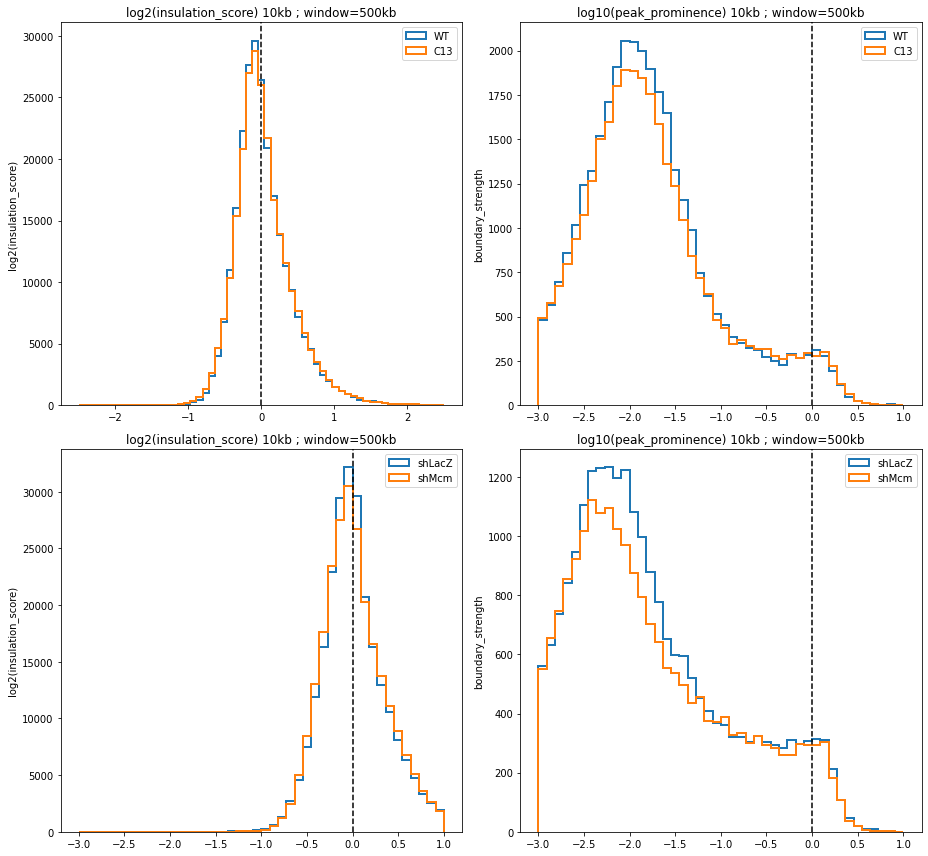

In [37]:
fig5, axs5 = plt.subplots(2, 2)
versus = [('WT', 'C13'), ('shLacZ', 'shMcm')]
binedges = np.linspace(-2.5, 2.5, 60)

for vsconds, (ax1, ax2) in zip(versus, axs5):
    for cond in vsconds:
        x = insulations[cond]['log2_insulation_score_{}'.format(window_bp)].values
        ax1.hist(x[~np.isnan(x)],
                 bins=binedges,
                 histtype='step',
                 lw=2,
                 label=cond)
    ax1.axvline(0, c='k', ls='--')
    ax1.legend()
    ax1.set_title('log2(insulation_score) {0}kb ; window={1}kb'.format(binsize//1000, window_bp//1000))
    ax1.set_ylabel('log2(insulation_score)')

    binedges = np.linspace(-3, 1, 45)
    for cond in vsconds:
        x = insulations[cond]['boundary_strength_{}'.format(window_bp)].apply(np.log10).values
        ax2.hist(x[~np.isnan(x)],
                 bins=binedges,
                 histtype='step',
                 lw=2,
                 label=cond)
    ax2.axvline(0, c='k', ls='--')
    ax2.legend()
    ax2.set_title('log10(peak_prominence) {0}kb ; window={1}kb'.format(binsize//1000, window_bp//1000))
    ax2.set_ylabel('boundary_strength')

fig5.set_figwidth(13)
fig5.set_figheight(12)
fig5.tight_layout()
fig5.savefig('plots/insulation_score_qc.pdf')

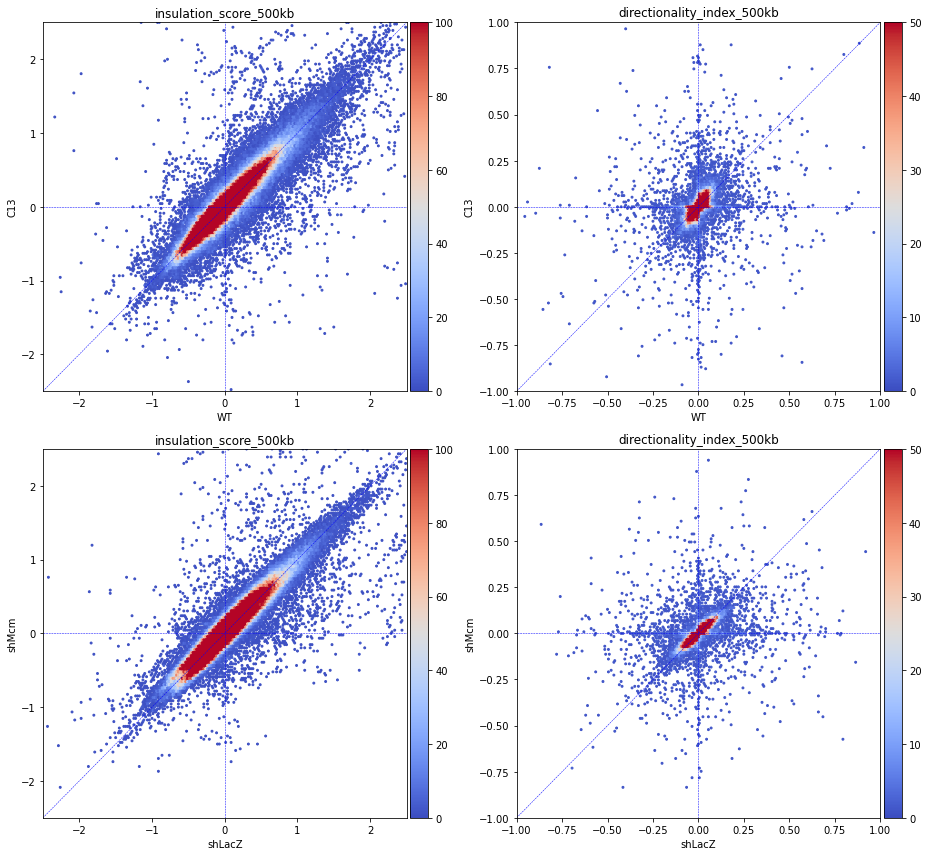

In [38]:
fig6, axs6 = plt.subplots(2, 2)
cmap = 'coolwarm'
for (condx, condy), (ax1, ax2) in zip(versus, axs6):
    vmax_ax1 = 100
    lo1, hi1 = -2.5, 2.5
    score = f'log2_insulation_score_{window_bp}'
    ax1.hexbin(insulations[condx][score],
               insulations[condy][score],
               extent=(lo1, hi1, lo1, hi1),
               vmin=0,
               vmax=vmax_ax1,
               cmap=cmap,
               rasterized=True,
               mincnt = 1,
               gridsize = 200)
    ax1.plot([lo1, hi1], [lo1, hi1], c='b', ls='--', lw=0.5)
    ax1.axvline(0, c='b', lw=0.5, ls='--')
    ax1.axhline(0, c='b', lw=0.5, ls='--')
    ax1.set_xlabel(condx)
    ax1.set_ylabel(condy)
    ax1.set_xlim(lo1, hi1)
    ax1.set_ylim(lo1, hi1)
    ax1.set_title(f'insulation_score_{window_bp//1000}kb')
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax1)
    ax_cb1 = divider.new_horizontal(size="5%", pad=0.05)
    fig6.add_axes(ax_cb1)
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize
    plt.colorbar(ScalarMappable(Normalize(0, vmax_ax1), cmap = cmap), cax = ax_cb1)
    ax_cb1.yaxis.tick_right()


    vmax_ax2 = 50
    lo2, hi2 = -1, 1
    score = f'directionality_index_{window_bp}'
    ax2.hexbin(directions[condx][score],
               directions[condy][score],
               extent = (lo2, hi2, lo2, hi2),
               vmin=0,
               vmax=vmax_ax2,
               cmap=cmap,
               rasterized=True,
               mincnt = 1,
               gridsize = 200)
    ax2.plot([lo2, hi2], [lo2, hi2], c='b', ls='--', lw=0.5)
    ax2.axvline(0, c='b', lw=0.5, ls='--')
    ax2.axhline(0, c='b', lw=0.5, ls='--')
    ax2.set_xlabel(condx)
    ax2.set_ylabel(condy)
    ax2.set_xlim(lo2, hi2)
    ax2.set_ylim(lo2, hi2)
    ax2.set_title(f'directionality_index_{window_bp//1000}kb')
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax2)
    ax_cb2 = divider.new_horizontal(size="5%", pad=0.05)
    fig6.add_axes(ax_cb2)
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize
    plt.colorbar(ScalarMappable(Normalize(0, vmax_ax2), cmap = cmap), cax = ax_cb2)
    ax_cb2.yaxis.tick_right()

fig6.set_figwidth(13)
fig6.set_figheight(12)
fig6.tight_layout()
fig6.savefig('plots/insulation_directionality_versus.pdf')

In [39]:
def to_bigwig(df, chromsizes, filename, column):
    df.sort_values(by = ['chrom', 'start'], inplace = True)
    with pb.open(filename, 'w') as bw:
        bw.addHeader([(chrom, chromsizes[chrom]) for chrom in chromsizes.index], maxZooms = 10)
        for chrom, group in df.groupby('chrom', sort = False):
            group = group.dropna(subset = [column])
            if len(group) < 1:
                continue
                
            else:
                bw.addEntries(list(group['chrom']), list(group['start']), ends = list(group['end']), values = list(group[column]))


nbins = 100
flank = 1000000
insulstacks = {}
reference_conditions = ['WT', 'WT', 'shLacZ', 'shLacZ']
for cond, reference in zip(conditions, reference_conditions):
    df = signflips[reference]
    bwfile = 'tads/CH12_HiC_{0}_{1}kb_insulScore.bw'.format(cond, binsize//1000)
    to_bigwig(insulations[cond], 
              chromsizes,
              bwfile,
              f'log2_insulation_score_{window_bp}')
        
    insulstacks[cond] = bbi.stackup(bwfile, df['chrom'], df['start'] - flank, df['start'] + flank, bins=nbins)

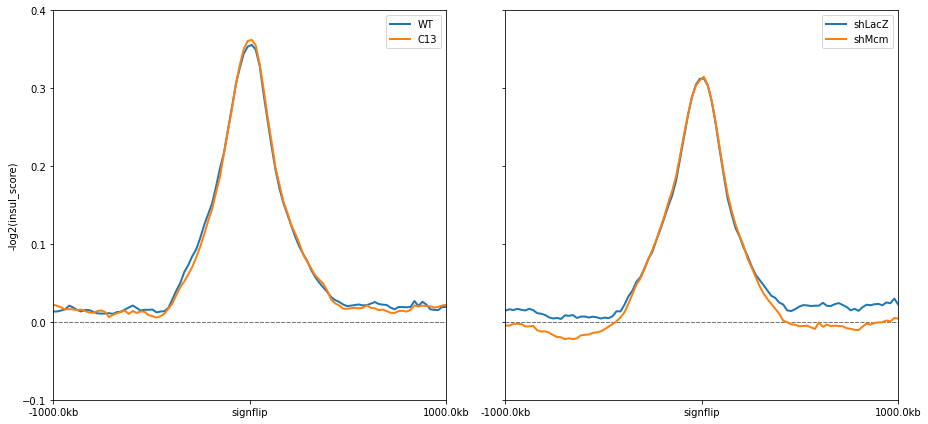

In [40]:
fig7, axs7 = plt.subplots(1, 2, sharey = 'row')

x = np.linspace(-flank/1e3, flank/1e3, nbins)
condax = {'WT': axs7[0], 'C13': axs7[0], 'shLacZ': axs7[1], 'shMcm': axs7[1]}

for i, (cond, reference) in enumerate(zip(conditions, reference_conditions)):
    X_ref = insulstacks[reference]
    idx = np.argsort(X_ref[:, X_ref.shape[1]//2])

    # summary
    ax = condax[cond]
    ax.axhline(0, c='#777777', lw=1, ls='--')
    ax.plot(x, np.nanmean(insulstacks[cond], axis=0), lw=2, label = cond)
    xmin, xmax = -flank/1e3, flank/1e3
    ax.set_xlim(xmin, xmax)
    ax.set_xticks([xmin, 0, xmax])
    ax.set_xticklabels([f'{xmin}kb', 'signflip', f'{xmax}kb'])
    ax.set_ylim(-0.1, 0.4)

for ax in axs7:
    ax.legend(loc = 'upper right')

axs7[0].set_ylabel('-log2(insul_score)')
fig7.set_figwidth(13)
fig7.set_figheight(6)
fig7.tight_layout()
fig7.savefig('plots/insulation_score_around_WT_signflips.pdf')

This representation gives an idea of changes in insulation around the compartment edges. While C13 and WT do not show a very gross change (changes found might be due to clonal effects), we find a reduction in insulation in shMcm as opposed to shLacZ, implying a stronger interaction between the compartments.

# Assessing TAD insulation

In [8]:
#tadfilestring = 'tads/CH12_HiC_{0}_10kb_minDepth50000_maxDepth150000_step10000_thres0.01_delta0.1_fdr_domains.bed'
tadfilestring = 'ditag/CH12_HiC_{0}/CH12_HiC_{0}_5kb_domains.bed'
tads = {cond: pd.read_csv(tadfilestring.format(cond),
                          sep = '\t',
                          usecols = [0, 1, 2, 3],
                          header = None,
                          names = ['chrom', 'start', 'end', 'name'])
        for cond in conditions}

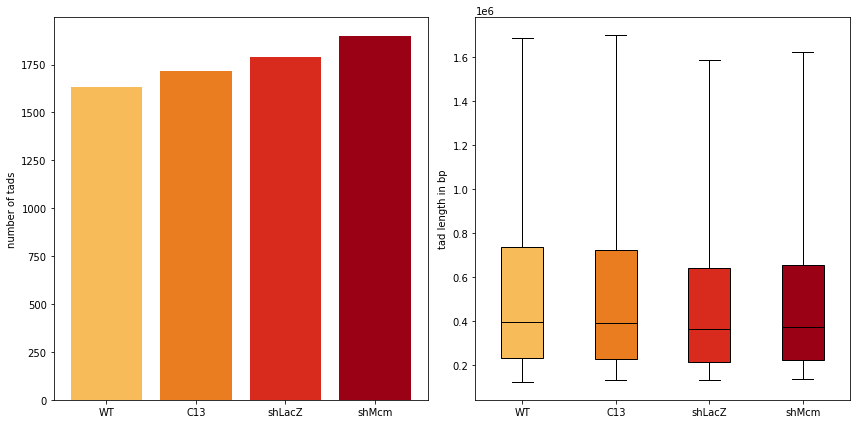

In [42]:
fig22, axs22 = plt.subplots(1, 2)
cmap = colors.LinearSegmentedColormap.from_list('higlass',
                                                ['white', 
                                                 [i/256 for i in [245, 166, 35]], 
                                                 [i/256 for i in [208, 2, 27]], 
                                                 'black'],
                                                N = 256)
colorlist = [cmap(i) for i in np.linspace(0.25, 0.75, len(conditions))]
tadsizes, tadnumbers = [], []
for cond in conditions:
    taddf = tads[cond]
    tadsizes.append(taddf['end'] - taddf['start'])
    tadnumbers.append(len(taddf))
    
ax1, ax2 = axs22
ax1.bar(range(len(conditions)), 
        tadnumbers, 
        color = colorlist)
ax1.set_xticks(range(len(conditions)))
ax1.set_xticklabels(conditions)
ax1.set_ylabel('number of tads')
    
bplot = ax2.boxplot(tadsizes,
                    patch_artist = True,
                    labels = conditions,
                    showfliers = False,
                    whis = [5, 95])
ax2.set_ylabel('tad length in bp')
for patch, color in zip(bplot['medians'], colorlist):
    patch.set_c('k')
        
for patch, color in zip(bplot['boxes'], colorlist):
    patch.set_facecolor(color)

fig22.set_figwidth(12)
fig22.set_figheight(6)
fig22.tight_layout()
fig22.savefig('plots/tadstatistics.pdf')

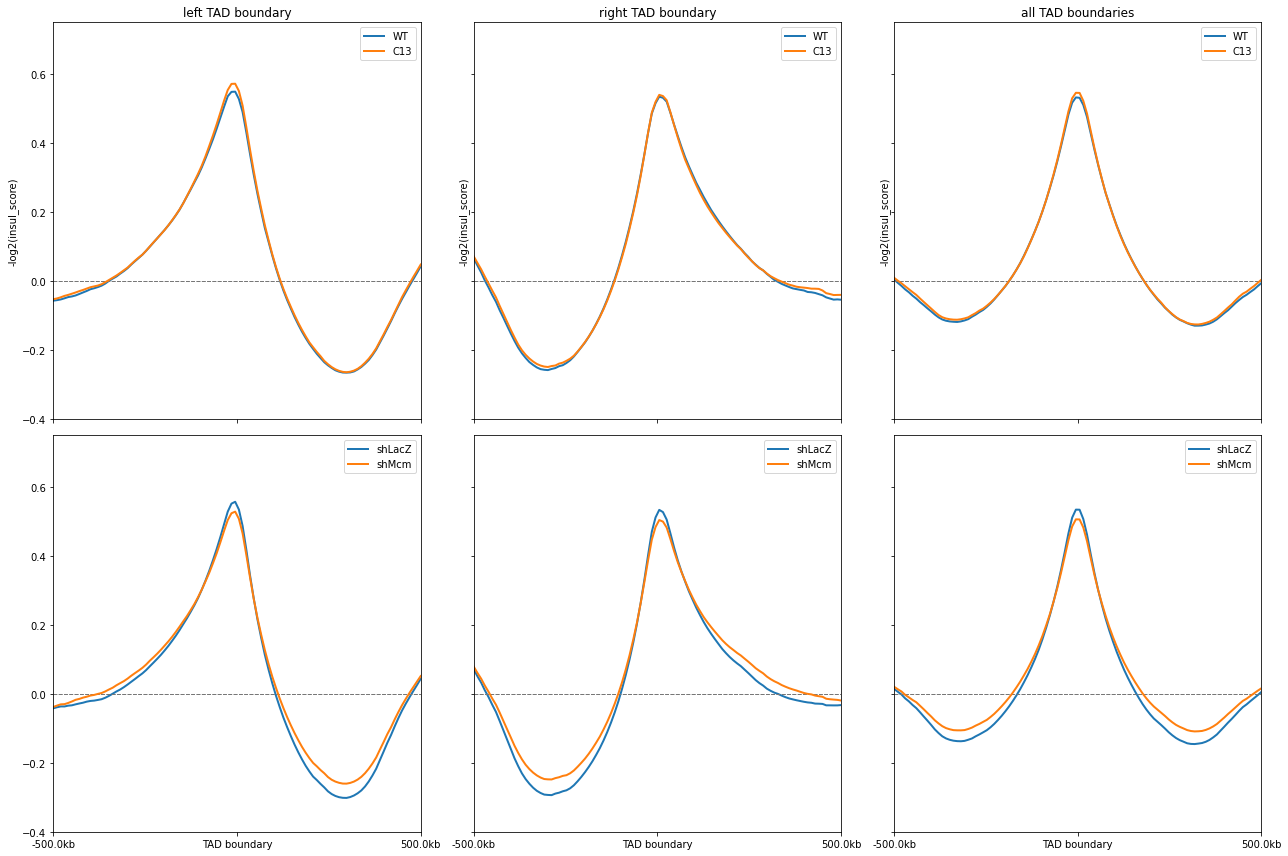

In [43]:
# insulation score around TAD borders for TADs in range of 400kb to 900kb
def get_tads_in_range(df, lo, hi):
    lengths = df['end'] - df['start']
    return df.loc[(lo <= lengths) & (lengths <= hi), :] 

flank = 500000
nbins = 100
tadinsulstacks = {}
reference_conditions = ['WT', 'WT', 'shLacZ', 'shLacZ']
for cond, reference in zip(conditions, reference_conditions):
    df = get_tads_in_range(tads[reference], 400000, 900000)
    bwfile = 'tads/CH12_HiC_{}_10kb_insulScore.bw'.format(cond)
    
    totbounds = {}
    totbounds['chrom'] = pd.concat([df['chrom'], df['chrom']])
    totbounds['starts'] = pd.concat([df['start'] - flank, df['end'] - flank])
    totbounds['ends'] = pd.concat([df['start'] + flank, df['end'] + flank])
    leftstack = bbi.stackup(bwfile, df['chrom'], df['start'] - flank, df['start'] + flank, bins=nbins)
    rightstack = bbi.stackup(bwfile, df['chrom'], df['end'] - flank, df['end'] + flank, bins=nbins)
    totstack = bbi.stackup(bwfile, totbounds['chrom'], totbounds['starts'], totbounds['ends'], bins=nbins)
    tadinsulstacks[cond] = {'left': leftstack, 'right': rightstack, 'tot': totstack}
    
fig8, axs8 = plt.subplots(2, 3, sharey = 'row', sharex = 'col')

x = np.linspace(-flank/1e3, flank/1e3, nbins)
condax = {'WT': {'left': axs8[0, 0], 'right': axs8[0, 1], 'tot': axs8[0, 2]}, 
          'C13': {'left': axs8[0, 0], 'right': axs8[0, 1], 'tot': axs8[0, 2]}, 
          'shLacZ': {'left': axs8[1, 0], 'right': axs8[1, 1], 'tot': axs8[1, 2]}, 
          'shMcm': {'left': axs8[1, 0], 'right': axs8[1, 1], 'tot': axs8[1, 2]}}

for i, (cond, reference) in enumerate(zip(conditions, reference_conditions)):
    for boundary in ['left', 'right', 'tot']:
        X_ref = tadinsulstacks[reference][boundary]
        idx = np.argsort(X_ref[:, X_ref.shape[1]//2])

        # summary
        ax = condax[cond][boundary]
        ax.axhline(0, c='#777777', lw=1, ls='--')
        ax.plot(x, np.nanmean(tadinsulstacks[cond][boundary], axis=0), lw=2, label = cond)
        xmin, xmax = -flank/1e3, flank/1e3
        ax.set_xlim(xmin, xmax)
        ax.set_xticks([xmin, 0, xmax])
        ax.set_xticklabels([f'{xmin}kb', 'TAD boundary', f'{xmax}kb'])
        ax.set_ylim(-0.4, 0.75)

for ax in axs8.reshape(6):
    ax.legend(loc = 'upper right')

axs8[0, 0].set_ylabel('-log2(insul_score)')
axs8[0, 1].set_ylabel('-log2(insul_score)')
axs8[0, 2].set_ylabel('-log2(insul_score)')
axs8[0, 0].set_title('left TAD boundary')
axs8[0, 1].set_title('right TAD boundary')
axs8[0, 2].set_title('all TAD boundaries')
fig8.set_figwidth(18)
fig8.set_figheight(12)
fig8.tight_layout()
fig8.savefig('plots/insulation_score_around_WT_tadbounds_400kb_900kb.pdf')

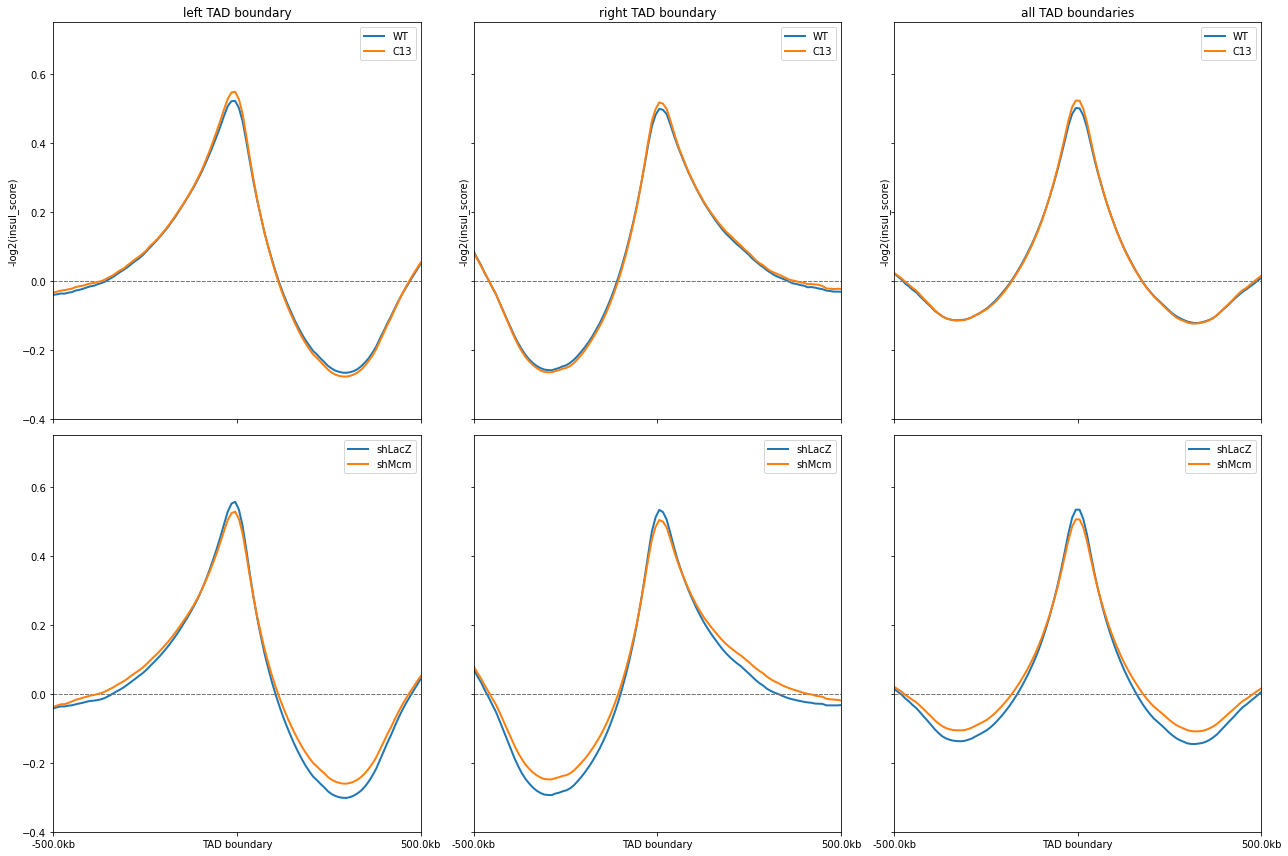

In [44]:
flank = 500000
tadinsulstacks = {}
reference_conditions = ['WT', 'WT', 'shLacZ', 'shLacZ']
for cond, reference in zip(conditions, reference_conditions):
    bwfile = 'tads/CH12_HiC_{}_10kb_insulScore.bw'.format(cond)
    
    totbounds = {}
    totbounds['chrom'] = pd.concat([df['chrom'], df['chrom']])
    totbounds['starts'] = pd.concat([df['start'] - flank, df['end'] - flank])
    totbounds['ends'] = pd.concat([df['start'] + flank, df['end'] + flank])
    leftstack = bbi.stackup(bwfile, df['chrom'], df['start'] - flank, df['start'] + flank, bins=nbins)
    rightstack = bbi.stackup(bwfile, df['chrom'], df['end'] - flank, df['end'] + flank, bins=nbins)
    totstack = bbi.stackup(bwfile, totbounds['chrom'], totbounds['starts'], totbounds['ends'], bins=nbins)
    tadinsulstacks[cond] = {'left': leftstack, 'right': rightstack, 'tot': totstack}
    
fig8, axs8 = plt.subplots(2, 3, sharey = 'row', sharex = 'col')

x = np.linspace(-flank/1e3, flank/1e3, nbins)
condax = {'WT': {'left': axs8[0, 0], 'right': axs8[0, 1], 'tot': axs8[0, 2]}, 
          'C13': {'left': axs8[0, 0], 'right': axs8[0, 1], 'tot': axs8[0, 2]}, 
          'shLacZ': {'left': axs8[1, 0], 'right': axs8[1, 1], 'tot': axs8[1, 2]}, 
          'shMcm': {'left': axs8[1, 0], 'right': axs8[1, 1], 'tot': axs8[1, 2]}}

for i, (cond, reference) in enumerate(zip(conditions, reference_conditions)):
    for boundary in ['left', 'right', 'tot']:
        X_ref = tadinsulstacks[reference][boundary]
        idx = np.argsort(X_ref[:, X_ref.shape[1]//2])

        # summary
        ax = condax[cond][boundary]
        ax.axhline(0, c='#777777', lw=1, ls='--')
        ax.plot(x, np.nanmean(tadinsulstacks[cond][boundary], axis=0), lw=2, label = cond)
        xmin, xmax = -flank/1e3, flank/1e3
        ax.set_xlim(xmin, xmax)
        ax.set_xticks([xmin, 0, xmax])
        ax.set_xticklabels([f'{xmin}kb', 'TAD boundary', f'{xmax}kb'])
        ax.set_ylim(-0.4, 0.75)

for ax in axs8.reshape(6):
    ax.legend(loc = 'upper right')

axs8[0, 0].set_ylabel('-log2(insul_score)')
axs8[0, 1].set_ylabel('-log2(insul_score)')
axs8[0, 2].set_ylabel('-log2(insul_score)')
axs8[0, 0].set_title('left TAD boundary')
axs8[0, 1].set_title('right TAD boundary')
axs8[0, 2].set_title('all TAD boundaries')
fig8.set_figwidth(18)
fig8.set_figheight(12)
fig8.tight_layout()
fig8.savefig('plots/insulation_score_around_WT_tadbounds_all.pdf')

# Saddle plots
In saddle plots we assess the contact enrichment between genomic bins as a function of compartment signal (i.e. eigenvector values). In this way, we first divide the eigenvector values into n equally sized groups where group 0 is strongest B (i.e. most negative eigenvector values) and group n is strongest A (i.e. most positive eigenvector values) and then calculate the average contact strength between all pairs of groups (i.e. all loci of a given group with all loci of any other group). 

In [8]:
Q_LO, Q_HI, N_GROUPS = 0, 1, 50
q_edges = np.linspace(Q_LO, Q_HI, N_GROUPS+1)
binsize = 20000

digitizedEigs = {}
groupEigBounds = {}
reference_conditions = {'WT': 'WT', 'C13': 'WT', 'shLacZ': 'shLacZ', 'shMcm': 'shLacZ'}
for cond in conditions:
    # Calculate the lower and the upper values of eigenvectors in each of  groups.
    groupEigBounds[cond] = cooltools.saddle.quantile(correct_eigs[binsize][reference_conditions[cond]]['eigvalues'], q_edges)

    # Assign the group to each genomic bin according to eigenvector value
    digitizedEigs[cond], hist = cooltools.saddle.digitize_track(groupEigBounds[cond],
                                                                track=(correct_eigs[binsize][reference_conditions[cond]], 'eigvalues'))

In [ ]:
# generating OE matrix fetchers
def make_exp_obs_matrix_fetcher(coolerObj, 
                                regions, 
                                ignore_diags = 2, 
                                weight_name = None, 
                                transform = None, 
                                cisexpfile = None, 
                                trsexpfile = None):
    #expected = cooltools.expected.cis_expected(coolerObj, regions, use_dask=True)
    if transform == None:
        transform = {'balanced': lambda p: p['count']}
        
    tables = diagsum(coolerObj,
                     regions,
                     transforms=transform,
                     chunksize=10000000,
                     ignore_diags=ignore_diags,
                     weight_name = weight_name)

    cis_exp = pd.concat([tables[region] for region in regions],
                        keys=[region[0] for region in regions],
                        names=['chrom'])
    
    cis_exp['balanced.avg'] = cis_exp['balanced.sum'] / cis_exp['n_valid']
    cis_exp['count.avg'] = cis_exp['count.sum'] / cis_exp['n_valid']
    
    if cisexpfile:
        cis_exp.to_csv(cisexpfile, 
                       sep='\t')

    records = blocksum_pairwise(coolerObj,
                                regions,
                                transforms=transform,
                                chunksize=10000000,
                                weight_name = weight_name)

    trs_exp = pd.DataFrame([{'chrom1': s1[0], 'chrom2': s2[0], **rec} for (s1, s2), rec in records.items()],
                           columns=['chrom1', 'chrom2', 'n_valid', 'count.sum', 'balanced.sum'])
    
    if trsexpfile:
        trs_exp.to_csv(trsexpfile, 
                       sep='\t', 
                       index=False)
    
    # Make a function that returns observed/expected dense matrix of an arbitrary
    # region of the Hi-C map.
    return cooltools.saddle.make_cis_obsexp_fetcher(coolerObj, (cis_exp, 'balanced.avg'), weight_name = weight_name), cis_exp, trs_exp


p = mp.Pool(8)
mpResults = {}
error_callback = lambda e: tb.print_exception(type(e), e, None)
# in case this is a valid cooler (i.e. pixels store the raw values and are balanced in situ)
# use {'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']} else if cooler is 
# generated from HiCExplorer h5 pixels already store the balanced values therefore
# use {'balanced': lambda p: p['count']}
transform = {'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']}
for binsize in [5000, 10000, 20000, 200000]:
    mpResults[binsize] = {}
    for cond in conditions:
        c = coolers[binsize][cond]
        regions = [(chrom, 0, c.chromsizes[chrom]) for chrom in c.chromnames]
        args = [coolers[binsize][cond], 
                regions, 
                1, 
                'weight', 
                transform,
                f'expected/CH12_HiC_{cond}_{binsize//1000}kb_cis_exp.tsv', 
                f'expected/CH12_HiC_{cond}_{binsize//1000}kb_trs_exp.tsv']
        mpResults[binsize][cond] = p.apply_async(make_exp_obs_matrix_fetcher,
                                                 args = args,
                                                 error_callback = error_callback)

p.close()
p.join()
matrixFetchers, cis_exp, trs_exp = {}, {}, {}
for binsize, mpResultsPerCondition in mpResults.items():
    matrixFetchers[binsize], cis_exp[binsize], trs_exp[binsize] = {}, {}, {}
    for cond, mpResult in mpResultsPerCondition.items():
        matrixFetchers[binsize][cond], cis_exp[binsize][cond], trs_exp[binsize][cond] = mpResult.get()

In [11]:
binsize = 5000
stats = {}
for cond in conditions:
    n_cis = int(cis_exp[binsize][cond]['count.sum'].sum())
    n_trs = int(trs_exp[binsize][cond]['count.sum'].sum())
    stats[cond] = {'cis': n_cis,
                   'trans': n_trs,
                   'total': n_cis + n_trs,
                   'cis:trans': n_cis / n_trs,
                   'cis:total': n_cis / (n_cis + n_trs)}
pd.DataFrame.from_dict(stats, orient='index')

cis      trans      total  cis:trans  cis:total
WT       60194542   29734531   89929073   2.024399   0.669356
C13      59616794   20494615   80111409   2.908900   0.744174
shLacZ  313521972   83240783  396762755   3.766447   0.790200
shMcm   375394404  106491624  481886028   3.525107   0.779011

In [12]:
sums = {}
n_valid = {}
scalings = {}
for cond in conditions:
    grouped = cis_exp[binsize][cond].groupby('diag')
    n_valid[cond] = grouped['n_valid'].sum().values
    sums[cond] = grouped['balanced.sum'].sum().values
    scalings[cond] = (sums[cond] / n_valid[cond])

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


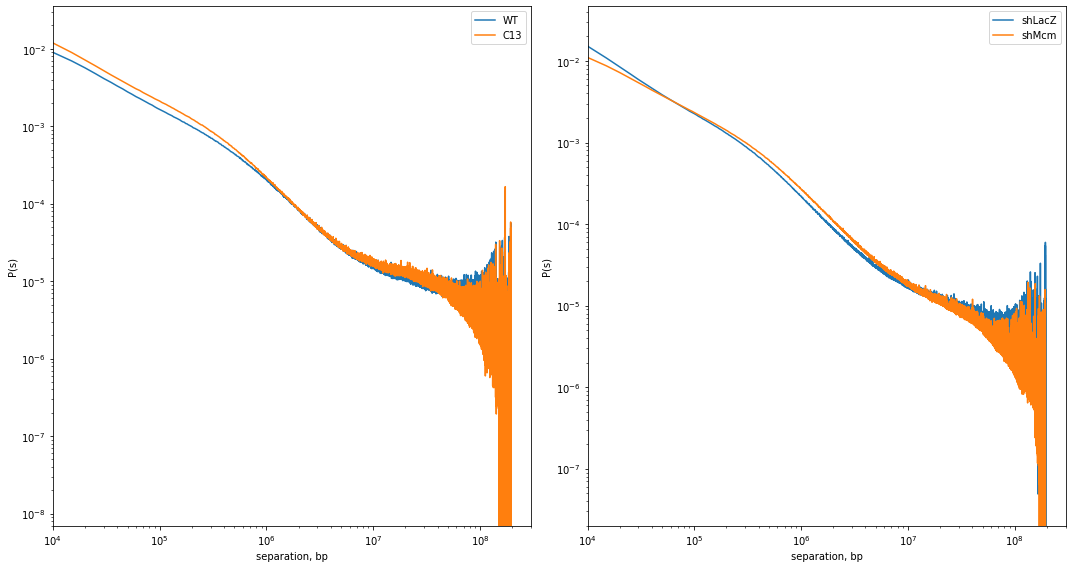

In [18]:
from cooltools.lib import numutils

def coarsen_geometric(sums, counts, n_bins=100):
    """Re-bin the expected sums into logarithmically growing bins.

    """
    dbins = numutils.logbins(1, len(sums), N=n_bins)
    spans = list(zip(dbins[:-1], dbins[1:]))
    s = np.array([np.nansum(sums[lo:hi]) for lo, hi in spans])
    n = np.array([np.nansum(counts[lo:hi]) for lo, hi in spans])
    return dbins, s / n

SMOOTH = False
fig23, axs23 = plt.subplots(1, 2)
for condsubset, ax in zip([['WT', 'C13'], ['shLacZ', 'shMcm']], axs23):
    for cond in condsubset:
        ref_point = 200000 // binsize
        norm = 1 #scalings[cond][ref_point]

        # cis P(s)
        x = np.arange(0, len(scalings[cond]) * binsize, binsize)
        y = scalings[cond] / norm
        if SMOOTH:
            x, y = coarsen_geometric(sums[cond], n_valid[cond], 100)
            x *= binsize
            x = x[:-1]

        ax.plot(x, y,
                label=cond)

        # average trans levels
        #for _, row in trs_exp[cond].iterrows():
        #    plt.axhline(
        #        (row['balanced.sum']/row['n_valid']) / norm,
        #        xmin=i/len(conditions),
        #        xmax=(i+1)/len(conditions),
        #        c=colors[cond],
        #        alpha=0.25)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('P(s)')
        ax.set_xlabel('separation, bp')
        ax.legend()
        ax.set_xlim(1e4, 3*1e8)

fig23.set_figwidth(15)
fig23.set_figheight(8)
fig23.tight_layout()
fig23.savefig('plots/contactprobability_Ps.pdf')

In [14]:
cis_exp[5000]['shLacZ'].reset_index()

chrom  diag  n_valid  count.sum  balanced.sum  balanced.avg  count.avg
0       chr1     0    38177        NaN           NaN           NaN        NaN
1       chr1     1    38039  1474341.0    891.344616      0.023432  38.758669
2       chr1     2    38031   920663.0    562.565920      0.014792  24.208225
3       chr1     3    38024   659282.0    404.506398      0.010638  17.338576
4       chr1     4    38017   513020.0    312.302053      0.008215  13.494489
...      ...   ...      ...        ...           ...           ...        ...
530987  chrY  3176        0        0.0      0.000000           NaN        NaN
530988  chrY  3177        0        0.0      0.000000           NaN        NaN
530989  chrY  3178        0        0.0      0.000000           NaN        NaN
530990  chrY  3179        0        0.0      0.000000           NaN        NaN
530991  chrY  3180        0        0.0      0.000000           NaN        NaN

[530992 rows x 7 columns]

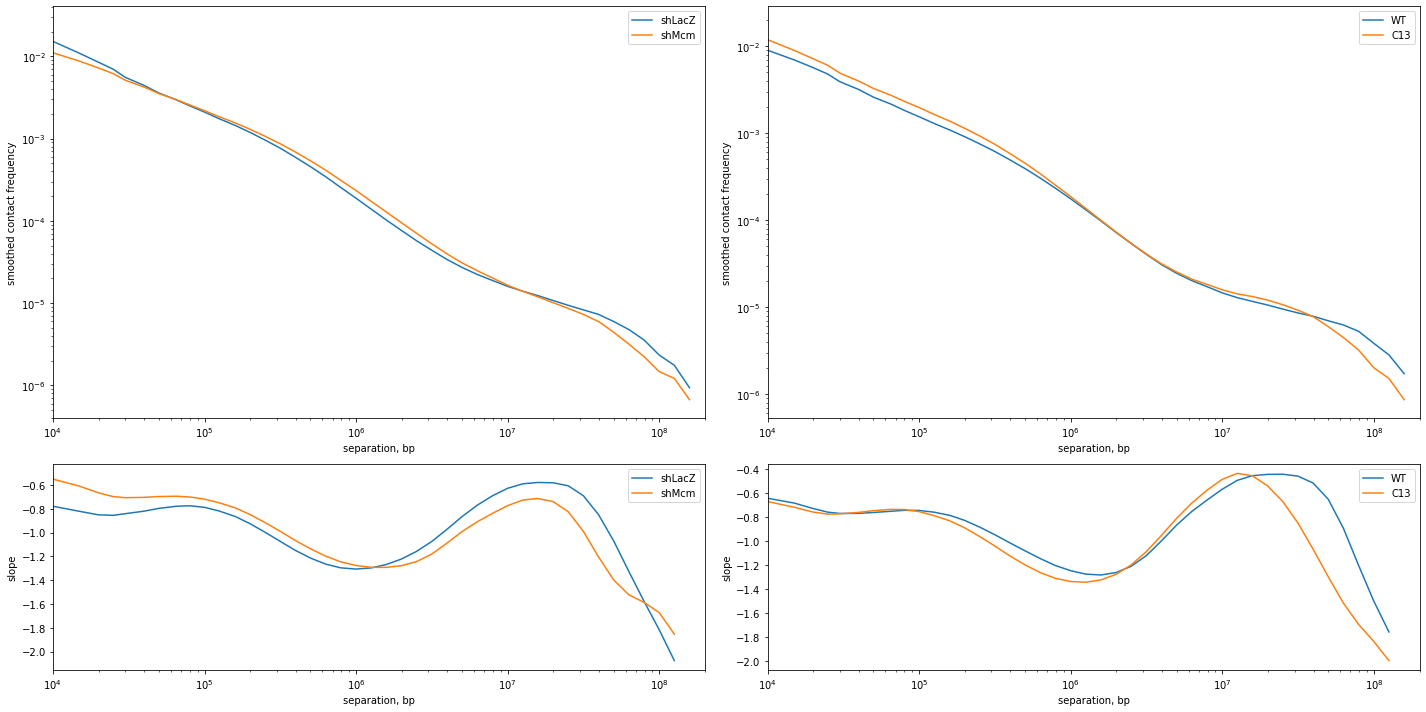

In [23]:
import scipy

#functions copied from cooltools
def weighted_groupby_mean(df, group_by, weigh_by, mode="mean"):
    """
    Weighted mean, std, and std in log space for a dataframe.groupby

    Parameters
    ----------
    df : dataframe
        Dataframe to groupby
    group_by : str or list
        Columns to group by
    weight_by : str
        Column to use as weights
    mode : "mean", "std" or "logstd"
        Do the weighted mean, the weighted standard deviaton,
        or the weighted std in log-space from the mean-log value
        (useful for P(s) etc.)
    """
    if type(group_by) == str:
        group_by = [group_by]
    gr = df.groupby(group_by)
    if mode == "mean":
        def wstd(x):
            return np.average(x, weights=df.loc[x.index, weigh_by])
        wm = wstd
    elif mode == "std":
        def wstd(x):
            wm = np.average(x, weights=df.loc[x.index, weigh_by])
            dev = x - wm
            res = np.sqrt(np.average(dev**2, weights=df.loc[x.index, weigh_by]))
            return res
        wm = wstd
    elif mode == "logstd":
        def wstd(x):
            x = np.log(x)
            wm = np.average(x, weights=df.loc[x.index, weigh_by])
            dev = x - wm
            res = np.sqrt(np.average(dev**2, weights=df.loc[x.index, weigh_by]))
            return np.exp(res)
        wm = wstd
    else:
        raise NotImplementedError

    f = {}
    for i in df.columns:
        if i in group_by:
            continue
        elif i == weigh_by:
            f[i] = ['sum']
        else:
            f[i] = [wm]
    agg = gr.agg(f)
    agg.columns = [i[0] for i in agg.columns]
    return agg


def combine_binned_expected(
    binned_exp,
    binned_exp_slope=None,
    Pc_name="balanced.avg",
    der_smooth_function_combined=lambda x: robust_gauss_filter(x, 1.3),
    spread_funcs="logstd",
    spread_funcs_slope="std",
    minmax_drop_bins=2,
    concat_original=False,
):
    """
    Combines by-region log-binned expected and slopes into genome-wide averages, 
    handling small chromosomes and "corners" in an optimal fashion, robust to 
    outliers. Calculates spread of by-chromosome P(s) and slopes, also in an optimal fashion. 

    Parameters
    ----------
    binned_exp: dataframe
        binned expected as outputed by logbin_expected

    binned_exp_slope : dataframe or None
        If provided, estimates spread of slopes.
        Is necessary if concat_original is True
        
    Pc_name : str
        Name of the column with the probability of contacts.
        Defaults to "balanced.avg".

    der_smooth_function_combined : callable
        A smoothing function for calculating slopes on combined data
        
    spread_funcs: "minmax", "std", "logstd" or a function (see below)
        A way to estimate the spread of the P(s) curves between regions.
        * "minmax" - use the minimum/maximum of by-region P(s)
        * "std" - use weighted standard deviation of P(s) curves (may produce negative results)
        * "logstd" (recommended) weighted standard deviation in logspace (as seen on the plot)

    spread_funcs_slope: "minmax", "std" or a funciton
        Similar to spread_func, but for slopes rather than P(s)

    concat_original: bool (default = False)
        Append original dataframe, and put combined under region "combined"

    Returns
    -------
    scal, slope_df

    Notes
    -----
    This function does not calculate errorbars. The spread is not the deviation of the mean, 
    and rather is representative of variability between chromosomes. 
    
    
    Calculating errorbars/spread

    1. Take all by-region P(s)
    2. For "minmax", remove the last var_drop_last_bins bins for each region
       (by default two. They are most noisy and would inflate the
       spread for the last points). Min/max are most susceptible to this.
    3. Groupby P(s) by region
    4. Apply spread_funcs to the pd.GroupBy object. Options are:
       * minimum and maximum ("minmax"),
       * weighted standard deviation ("std"),
       * weighted standard deviation in logspace ("logstd", default) or two custom functions
       We do not remove the last bins for "std" / "logstd" because we are
       doing weighted standard deviation. Therefore, noisy "ends" of regions
       would contribute very little to this.
    5. Append them to the P(s) for the same bin.

    As a result, by for minmax, we do not estimate spread for the last
    two bins. This is because there are often very few chromosomal arms there,
    and different arm measurements are noisy. For other methods, we do
    estimate the spread there, and noisy last bins are taken care of by the
    weighted standard deviation. However, the spread in the last bins may be
    noisy, and may become a 0 if only one region is contributing to the last
    pixel.
    """
    diag_avg_name = "diag.avg"
    scal = weighted_groupby_mean(
        binned_exp[[Pc_name, "diag_bin_id", "n_valid", diag_avg_name]],
        group_by="diag_bin_id",
        weigh_by="n_valid",
        mode="mean"
    )

    if spread_funcs == "minmax":
        byRegVar = binned_exp.copy()
        byRegVar = byRegVar.loc[
            byRegVar.index.difference(
                byRegVar.groupby("chrom")["n_valid"].tail(minmax_drop_bins).index
            )
        ]
        low_err = byRegVar.groupby("diag_bin_id")[Pc_name].min()
        high_err = byRegVar.groupby("diag_bin_id")[Pc_name].max()
    elif spread_funcs == "std":
        var = weighted_groupby_mean(
            binned_exp[[Pc_name, "diag_bin_id", "n_valid"]],
            group_by="diag_bin_id",
            weigh_by="n_valid",
            mode="std"
        )[Pc_name]
        low_err = scal[Pc_name] - var
        high_err = scal[Pc_name] + var
    elif spread_funcs == "logstd":
        var = weighted_groupby_mean(
            binned_exp[[Pc_name, "diag_bin_id", "n_valid"]],
            group_by="diag_bin_id",
            weigh_by="n_valid",
            mode="logstd"
        )[Pc_name]
        low_err = scal[Pc_name] / var
        high_err = scal[Pc_name] * var
    else:
        low_err, high_err = spread_funcs(binned_exp, scal)

    scal["low_err"] = low_err
    scal["high_err"] = high_err

    f = der_smooth_function_combined

    slope = np.diff(f(np.log(scal[Pc_name].values))) / np.diff(f(np.log(scal[diag_avg_name].values)))
    valid = np.minimum(scal["n_valid"].values[:-1], scal["n_valid"].values[1:])
    mids = np.sqrt(scal[diag_avg_name].values[:-1] * scal[diag_avg_name].values[1:])
    slope_df = pd.DataFrame(
        {
            diag_avg_name: mids,
            "slope": slope,
            "n_valid": valid,
            "diag_bin_id": scal.index.values[:-1],
        }
    )
    slope_df = slope_df.set_index("diag_bin_id")

    if binned_exp_slope is not None:
        if spread_funcs_slope == "minmax":
            byRegDer = binned_exp_slope.copy()
            byRegDer = byRegDer.loc[
                byRegDer.index.difference(
                    byRegDer.groupby("chrom")["n_valid"].tail(minmax_drop_bins).index
                )
            ]
            low_err = byRegDer.groupby("diag_bin_id")["slope"].min()
            high_err = byRegDer.groupby("diag_bin_id")["slope"].max()
        elif spread_funcs_slope == "std":
            var = weighted_groupby_mean(
                binned_exp_slope[["slope", "diag_bin_id", "n_valid"]],
                group_by="diag_bin_id",
                weigh_by="n_valid",
                mode="std",
            )["slope"]
            low_err = slope_df["slope"] - var
            high_err = slope_df["slope"] + var

        else:
            low_err, high_err = spread_funcs_slope(binned_exp_slope, scal)
        slope_df["low_err"] = low_err
        slope_df["high_err"] = high_err

    slope_df = slope_df.reset_index()
    scal = scal.reset_index()

    if concat_original:
        scal["chrom"] = "combined"
        slope_df["chrom"] = "combined"
        scal = pd.concat([scal, binned_exp], sort=False).reset_index(drop=True)
        slope_df = pd.concat([slope_df, binned_exp_slope], sort=False).reset_index(
            drop=True
        )

    return scal, slope_df


def robust_gauss_filter(
    ar,
    sigma=2,
    functon=scipy.ndimage.filters.gaussian_filter1d,
    kwargs=None
):
    """
    Implements an edge-handling mode for gaussian filter that basically ignores
    the edge, and also handles NaNs.

    Parameters
    ----------
    ar : array-like
        Input array
    sigma : float
        sigma to be passed to the filter
    function : callable
        Filter to use. Default is gauusian_filter1d
    kwargs : dict
        Additional args to pass to the filter. Default:None

    Notes
    -----
    Available edge-handling modes in ndimage.filters attempt to somehow
    "extrapolate" the edge value and then  apply the filter (see
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html).
     That's likely because convolve uses fast fourier transform, which requires
    the kernel to be constant.  Here we design a better edge-handling for the
    gaussian smoothing.

    In a gaussian-filtered array, a pixel away from the edge is a mean of nearby
    pixels with gaussian weights.  With this mode, pixels near start/end are
    also a mean of nearby pixels with gaussian weights. That's it.  If we
    encounter NANs, we also simply ignore them, following the same definition:
    mean of nearby valid pixels.  Yes, it rases the weights for the first/last
    pixels, because now only a part of the whole gaussian is being used  (up to
    1/2 for the first/last pixel and large sigma). But it preserves the "mean of
    nearby pixels" definition.  It is different from padding with zeros (it
    would drag the first pixel down to be more like zero).  It is also different
    from "nearest" - that gives too much weight to the first/last pixel.

    To achieve this smoothing, we preform regular gaussian smoothing using
    mode="constant"  (pad with zeros). Then we takes an array of valid pixels
    and smooth it the same way.  This calculates how many "average valid pixels"
    contributed to each point of a smoothed array.  Dividing one by the other
    achieves the desired result.
    """
    if kwargs is None:
        kwargs = {}
    ar = np.asarray(ar, dtype=float)
    mask = np.isfinite(ar)
    ar[~mask] = 0
    a = functon(ar, sigma=sigma, mode="constant", **kwargs)
    b = functon(1. * mask, sigma=sigma, mode="constant", **kwargs)
    return a / b


def persistent_log_bins(end=10, bins_per_order_magnitude=10):
    """
    Creates most nicely looking log-spaced integer bins starting at 1, with the
    defined number of bins per order of magnitude.

    Parameters
    ----------
    end : number (int recommended) log10 of the last value. It is safe to put a
    large value here and select your range of bins later.

    bins_per_order_magnitude : int >0 how many bins per order of magnitude

    Notes
    -----
    This is not a replacement for logbins, and it has a different purpose.

    Difference between this and logbins
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Logbins creates bins from lo to hi, spaced logarithmically with an
    appriximate ratio. Logbins  makes sure that the last bin is large  (i.e.
    hi/ratio ... hi), and will not allow the last  bin to be much less than
    ratio. It would slightly adjust the ratio to achieve that.  As a result, by
    construciton, logbins bins are different for different lo or hi.

    This function is designed to create exactly the same bins that only depend
    on one parameter,  bins_per_order_magnitude. The goal is to make things
    calculated for different datasets/organisms/etc. comparable. For example, if
    these bins are used, it would allow us to divide P(s) for two different
    organisms by each other because it was calculated for the same bins.

    The price you pay for such versatility is that the last bin can be much less
    than others in real application.  For example, if you have 10 bins per order
    of magnitude (ratio of 1.25), but your data ends at 10500, then  the only
    points in the last bin would be 10000..10500, 1/5 of what could be. This may
    make the last point noisy.

    The main part is done using np.logspace and rounding to the nearest integer,
    followed by unique.  The gaps are then re-sorted to ensure that gaps are
    strictly increasing. The re-sorting of  gaps was essential, and produced
    better results than manual adjustment.

    Alternatives that produce irregular bins
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Using np.unique(np.logspace(a,b,N,dtype=int)) can be sub-optimal  For
    example, np.unique(np.logspace(0,1,11,dtype=int)) = [ 1,  2,  3,  5,  6,  7,
    10] Note the gaps jump from 1 to 2 back to 1

    Similarly using np.unique(np.rint(np.logspace..)) can be suboptimal
    np.unique(np.array(np.rint(np.logspace(0,1,9)),dtype=int))  = [ 1,  2,  3,
    4,  6,  7, 10]

    for bins_per_order_of_magnitude=16, 10 is not in bins. Other than that, 10,
    100, 1000, etc. are always included.
    """
    if end > 50:
        raise ValueError("End is a log10(max_value), not the max_value itself")
    bin_float = np.logspace(0, end, end * bins_per_order_magnitude + 1)
    bin_int = np.array(np.rint(bin_float), dtype=int)  # rounding to the nearest int
    bins = np.unique(bin_int)   # unique bins
    bins = np.cumsum(np.sort(np.r_[1, np.diff(bins)]))  # re-ordering gaps (important step)
    return bins


def logbin_expected(
    exp,
    exp_summary_name="balanced.sum",
    bins_per_order_magnitude=10,
    bin_layout="fixed",
    der_smooth_function_by_reg=lambda x: robust_gauss_filter(x, 2),
    min_nvalid=200,
    min_count=50,
):
    """
    Logarithmically bins expected as produced by diagsum method.

    Parameters
    ----------
    exp : DataFrame
        DataFrame produced by diagsum

    exp_summary_name : str (optional)
        Name of the column of exp-DataFrame to use as a diagonal summary.
        Default is "balanced.sum".

    bins_per_order_magnitude : int (optional)
        How many bins per order of magnitude. Default of 10 has a ratio of
        neighboring bins of about 1.25

    bin_layout : "fixed", "longest_region", or array
        "fixed" means that bins are exactly the same for different datasets,
        and only depend on bins_per_order_magnitude

        "longest_region" means that the last bin will end at size of the
        longest region.
            GOOD: the last bin will have as much data as possible.
            BAD: bin edges will end up different for different datasets, you
            can't divide them by each other

        array: provide your own bin edges. Can be of any size, and end at any
        value. Bins exceeding the size of the largest region will be simply
        ignored.

    der_smooth_function_by_reg : callable
        A smoothing function to be applied to log(P(s)) and log(x)
        before calculating P(s) slopes for by-region data

    min_nvalid : int
        For each region, throw out bins (log-spaced) that have less than
        min_nvalid valid pixels
        This will ensure that each entree in Pc_by_region has at least n_valid
        valid pixels
        Don't set it to zero, or it will introduce bugs. Setting it to 1 is OK,
        but not recommended.

    min_count : int
        If counts are found in the data, then for each region, throw out bins
        (log-spaced)
        that have more than min_counts of counts.sum (raw Hi-C counts).
        This will ensure that each entree in Pc_by_region has at least
        min_count raw Hi-C reads

    Returns
    -------
    Pc : DataFrame
        dataframe of contact probabilities and spread across regions
    slope : ndarray
        slope of Pc(s) on a log-log plot and spread across regions
    bins : ndarray
        an array of bin edges used for calculating P(s)

    Notes
    -----
    For main Pc and slope, the algorithm is the following

    1. concatenate all the expected for all regions into a large dataframe.
    2. create logarithmically-spaced bins of diagonals (or use provided)
    3. pool together n_valid and balanced.sum for each region and for each bin
    4. calculate the average diagonal for each bucket, weighted by n_valid
    5. divide balanced.sum by n_valid after summing for each bucket (not before)
    6. calculate the slope in log space (for each region)

    X values are not midpoints of bins
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    In step 4, we calculate the average diag index weighted by n_valid. This
    seems counter-intuitive, but it actually is justified.

    Let's take the worst case scenario. Let there be a bin from 40MB to 44MB.
    Let there be a region that is exactly 41 MB long. The midpoint of the bin
    is at 42MB. But the only part of this region belonging to this bin is
    actually between 40MB and 41MB. Moreover, the "average" read in this
    little triangle of the heatmap is actually not coming even from 40.5 MB
    because the triangle is getting narrower towards 41MB. The center of mass
    of a triangle is 1/3 of the way up, or 40.33 MB. So an average read for
    this region in this bin is coming from 40.33.

    Consider the previous bin, say, from 36MB to 40MB. The heatmap there is a
    trapezoid with a long side of 5MB, the short side of 1MB, and height of
    4MB. The center of mass of this trapezoid is at 36 + 14/9 = 37.55MB,
    and not at 38MB. So the last bin center is definitely mis-assigned, and
    the second-to-last bin center is off by some 25%. This would lead to a 25%
    error of the P(s) slope estimated between the third-to-last and 
    second-to-last bin. 

    In presence of missing bins, this all becomes more complex, but this kind
    of averaging should take care of everything. It follows a general
    principle: when averaging the y values with some weights, one needs to
    average the x values with the same weights. The y values here are being
    added together, so per-diag means are effectively averaged with the weight
    of n_valid. Therefore, the x values (diag) should be averaged with the
    same weights.

    Other considerations
    ~~~~~~~~~~~~~~~~~~~~
    Steps #3 and #5 are important because the ratio of sums does not equal to
    the sum of ratios, and the former is more correct (the latter is more
    susceptible to noise). It is generally better to divide at the very end,
    rather than dividing things for each diagonal.

    Here we divide at the end twice: first we divide balanced.sum by n_valid
    for each region, then we effectively multiply it back up and divide it for
    each bin when combining different regions (see weighted average in the
    next function).

    Smoothing P(s) for the slope
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    For calcuating the slope, we apply smoothing to the P(s) to ensure the
    slope is not too noisy. There are several caveats here: the P(s) has to
    be smoothed in logspace, and both P and s have to be smoothed. It is
    discussed in detail here

    https://gist.github.com/mimakaev/4becf1310ba6ee07f6b91e511c531e73

    Examples
    --------
    For example, see this gist: https://gist.github.com/mimakaev/e9117a7fcc318e7904702eba5b47d9e6

    """
    from cooltools.lib.numutils import logbins

    raw_summary_name = "count.sum"
    exp_summary_base, *_ = exp_summary_name.split(".")
    Pc_name = f"{exp_summary_base}.avg"
    diag_name = "diag"
    diag_avg_name = f"{diag_name}.avg"

    exp = exp[~pd.isna(exp[exp_summary_name])].copy()
    exp[diag_avg_name] = exp.pop(diag_name) # "average" or weighted diagonals
    diagmax = exp[diag_avg_name].max()

    # create diag_bins based on chosen layout:
    if bin_layout == "fixed":
        diag_bins = persistent_log_bins(
            10,
            bins_per_order_magnitude=bins_per_order_magnitude
        )
    elif bin_layout == "longest_region":
        diag_bins = logbins(
            1,
            diagmax + 1,
            ratio=10 ** (1 / bins_per_order_magnitude)
        )
    else:
        diag_bins = bin_layout

    if diag_bins[-1] < diagmax:
        raise ValueError("Genomic separation bins end is less than the size of the largest region")

    # assign diagonals in exp DataFrame to diag_bins, i.e. give them ids:
    exp["diag_bin_id"] = np.searchsorted(diag_bins, exp[diag_avg_name], side="right") - 1
    exp = exp[exp["diag_bin_id"] >= 0]

    # constructing expected grouped by region
    byReg = exp.copy()

    # this averages diag_avg with the weight equal to n_valid, and sums everything else
    byReg[diag_avg_name] *= byReg["n_valid"]
    byRegExp = byReg.groupby(["chrom", "diag_bin_id"]).sum()
    byRegExp[diag_avg_name] /= byRegExp["n_valid"]

    byRegExp = byRegExp.reset_index()
    byRegExp = byRegExp[byRegExp["n_valid"] > min_nvalid]  # filtering by n_valid
    byRegExp[Pc_name] = byRegExp[exp_summary_name] / byRegExp["n_valid"]
    byRegExp = byRegExp[byRegExp[Pc_name] > 0]  # drop diag_bins with 0 counts
    if min_count:
        if raw_summary_name in byRegExp:
            byRegExp = byRegExp[byRegExp[raw_summary_name] > min_count]
        else:
            warnings.warn(RuntimeWarning(f"{raw_summary_name} not found in the input expected"))

    byRegExp["diag_bin_start"] = diag_bins[byRegExp["diag_bin_id"].values]
    byRegExp["diag_bin_end"] = diag_bins[byRegExp["diag_bin_id"].values + 1] - 1

    byRegDer = []
    for reg, subdf in byRegExp.groupby("chrom"):
        subdf = subdf.sort_values("diag_bin_id")
        valid = np.minimum(subdf["n_valid"].values[:-1], subdf["n_valid"].values[1:])
        mids = np.sqrt(subdf[diag_avg_name].values[:-1] * subdf[diag_avg_name].values[1:])
        f = der_smooth_function_by_reg
        slope = np.diff(f(np.log(subdf[Pc_name].values))) / np.diff(f(np.log(subdf[diag_avg_name].values)))
        newdf = pd.DataFrame(
            {
                diag_avg_name: mids,
                "slope": slope,
                "n_valid": valid,
                "diag_bin_id": subdf["diag_bin_id"].values[:-1],
            }
        )
        newdf["region"] = reg
        byRegDer.append(newdf)
    byRegDer = pd.concat(byRegDer).reset_index(drop=True)
    return byRegExp, byRegDer, diag_bins[: byRegExp["diag_bin_id"].max() + 2]


fig, axs = plt.subplots(2, 2,
                        gridspec_kw = {'height_ratios': [4, 2]})
for axcol, conds in enumerate([['shLacZ', 'shMcm'], ['WT', 'C13']]):
    ax1, ax2 = axs[:, axcol]
    for cond in conds:
        cvd = cis_exp[5000][cond].reset_index()
        lb_cvd, lb_slopes, lb_distbins = logbin_expected(cvd)
        lb_cvd_agg, lb_slopes_agg = combine_binned_expected(lb_cvd, 
                                                            binned_exp_slope = lb_slopes)
        lb_cvd_agg['s_bp'] = lb_cvd_agg.diag_bin_id.apply(lambda x: lb_distbins[x] * binsize)
        lb_slopes_agg['s_bp'] = lb_slopes_agg.diag_bin_id.apply(lambda x: lb_distbins[x] * binsize)
        #print(len(lb_distbins))
        #print(lb_slopes)
        #print(lb_cvd_agg)
        #print(lb_distbins)
        ax1.loglog(lb_cvd_agg['s_bp'], 
                   lb_cvd_agg['balanced.avg'],
                   label = cond)
        ax1.set(ylabel = 'smoothed contact frequency',
                xlabel = 'separation, bp',
                xlim=(1e4, 2e8))
        ax1.legend()

        ax2.semilogx(lb_slopes_agg['s_bp'], 
                    lb_slopes_agg['slope'],
                    label = cond)
        ax2.set(xlabel='separation, bp', 
                ylabel='slope',
                xlim=(1e4,2e8))
        ax2.legend()
    
fig.set_figheight(10)
fig.set_figwidth(20)
fig.tight_layout()
fig.savefig('plots/smoothed_and_dervative.pdf')

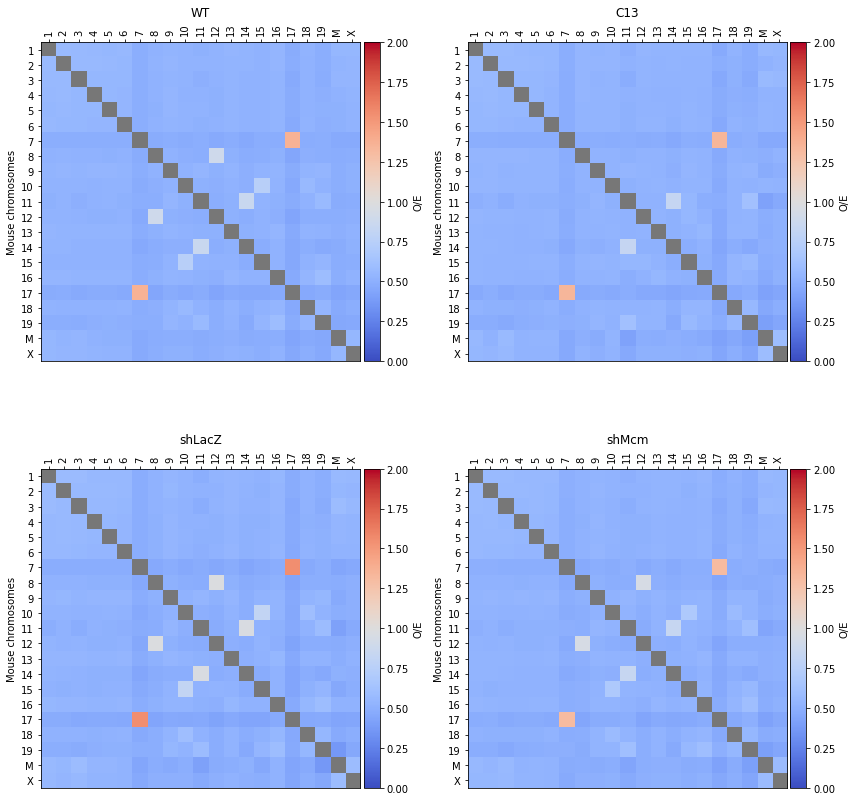

In [70]:
def compute_trans_obs_exp(trs_exp, chrom1, chrom2):
    n_tot = trs_exp['count.sum'].sum()
    
    idx1 = (trs_exp['chrom1'] == chrom1) | (trs_exp['chrom2'] == chrom1)
    n_chrom1 = trs_exp.loc[idx1, 'count.sum'].sum()
    
    idx2 = (trs_exp['chrom1'] == chrom2) | (trs_exp['chrom2'] == chrom2)
    n_chrom2 = trs_exp.loc[idx2, 'count.sum'].sum()
    
    f_chrom1 = n_chrom1/n_tot
    f_chrom2 = n_chrom2/n_tot
    n_exp = f_chrom1 * f_chrom2 * n_tot
    
    return trs_exp.loc[(trs_exp['chrom1'] == chrom1) & (trs_exp['chrom2'] == chrom2), 'count.sum'] / n_exp


def make_trans_obs_exp_matrix(trs_exp):
    chromosomes = trs_exp['chrom1'].unique()
    idx = {chrom: i for i, chrom in enumerate(chromosomes)}
    m = np.zeros(shape = (len(chromosomes), len(chromosomes)), dtype = float)
    for chrom1, chrom2 in it.combinations(chromosomes, r = 2):
        oe = compute_trans_obs_exp(trs_exp, chrom1, chrom2)
        m[idx[chrom1], idx[chrom2]] = oe
        m[idx[chrom2], idx[chrom1]] = oe
    
    for chrom in chromosomes:
        m[idx[chrom], idx[chrom]] = np.nan
        
    return m, chromosomes


fig14, axs14 = plt.subplots(2, 2)
binsize = 20000
inter_exp = {}
vmin = 2
vmax = 0
cmap = plt.get_cmap('coolwarm')
cmap.set_bad('#777777')
for ax, cond in zip(axs14.reshape(4), conditions):
    m, chromosomes = make_trans_obs_exp_matrix(trs_exp[binsize][cond])
    im = ax.imshow(m,
                   cmap = cmap,
                   vmin = vmin,
                   vmax = vmax)
    ax.set_title(cond)
    ax.xaxis.tick_top()
    ax.set_xticks(range(len(chromosomes)))
    ax.set_xticklabels([chrom.replace('chr', '') for chrom in chromosomes], rotation = 90)
    ax.set_yticks(range(len(chromosomes)))
    ax.set_ylabel('Mouse chromosomes')
    ax.set_yticklabels([chrom.replace('chr', '') for chrom in chromosomes])
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig14.add_axes(ax_cb)
    plt.colorbar(im, cax = ax_cb, label = 'O/E')
    ax_cb.yaxis.tick_right()

fig14.set_figwidth(12)
fig14.set_figheight(12)
fig14.tight_layout()
fig14.savefig('plots/interchromosomal_obs_exp.pdf')

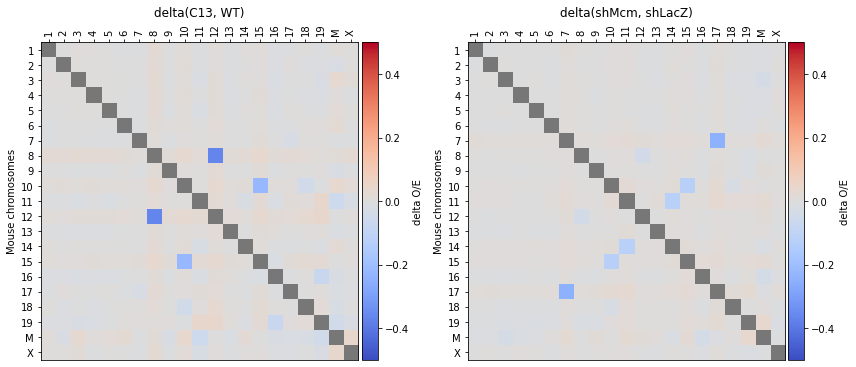

In [71]:
fig15, axs15 = plt.subplots(1, 2)
inter_exp = {}
vmin = 0.5
vmax = -0.5
cmap = plt.get_cmap('coolwarm')
cmap.set_bad('#777777')
for ax, (cond1, cond2) in zip(axs15, [('WT', 'C13'), ('shLacZ', 'shMcm')]):
    m1, chromosomes1 = make_trans_obs_exp_matrix(trs_exp[binsize][cond1])
    m2, chromosomes2 = make_trans_obs_exp_matrix(trs_exp[binsize][cond2])
    im = ax.imshow(m2 - m1,
                   cmap = cmap,
                   vmin = vmin,
                   vmax = vmax)
    ax.set_title(f'delta({cond2}, {cond1})')
    ax.xaxis.tick_top()
    ax.set_xticks(range(len(chromosomes)))
    ax.set_xticklabels([chrom.replace('chr', '') for chrom in chromosomes], rotation = 90)
    ax.set_yticks(range(len(chromosomes)))
    ax.set_ylabel('Mouse chromosomes')
    ax.set_yticklabels([chrom.replace('chr', '') for chrom in chromosomes])
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig15.add_axes(ax_cb)
    plt.colorbar(im, cax = ax_cb, label = 'delta O/E')
    ax_cb.yaxis.tick_right()

fig15.set_figwidth(12)
fig15.set_figheight(6)
fig15.tight_layout()
fig15.savefig('plots/interchromosomal_obs_exp_delta.pdf')

In [73]:
# compute saddles
p = mp.Pool(8)
mpResults = {}
error_callback = lambda e: tb.print_exception(type(e), e, None)
for cond in conditions:
    mpResults[cond] = {}
    for min_diag, max_diag in [(1, 5), (5, 15), (15, 50), (50, -1)]:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            args = [matrixFetchers[binsize][cond], groupEigBounds[cond], (digitizedEigs[cond], 'eigvalues.d')]
            kwargs = {'contact_type': 'cis', 'min_diag': min_diag, 'max_diag': max_diag}
            mpResults[cond][(min_diag, max_diag)] = p.apply_async(cooltools.saddle.make_saddle,
                                                                  args = args,
                                                                  kwds = kwargs,
                                                                  error_callback = error_callback)
p.close()
p.join()
saddles = {}
for cond, mpResultDict in mpResults.items():
    saddles[cond] = {}
    for diags, mpResult in mpResultDict.items():
        S, C = mpResult.get()
        saddles[cond][diags] = S/C

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: 

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':


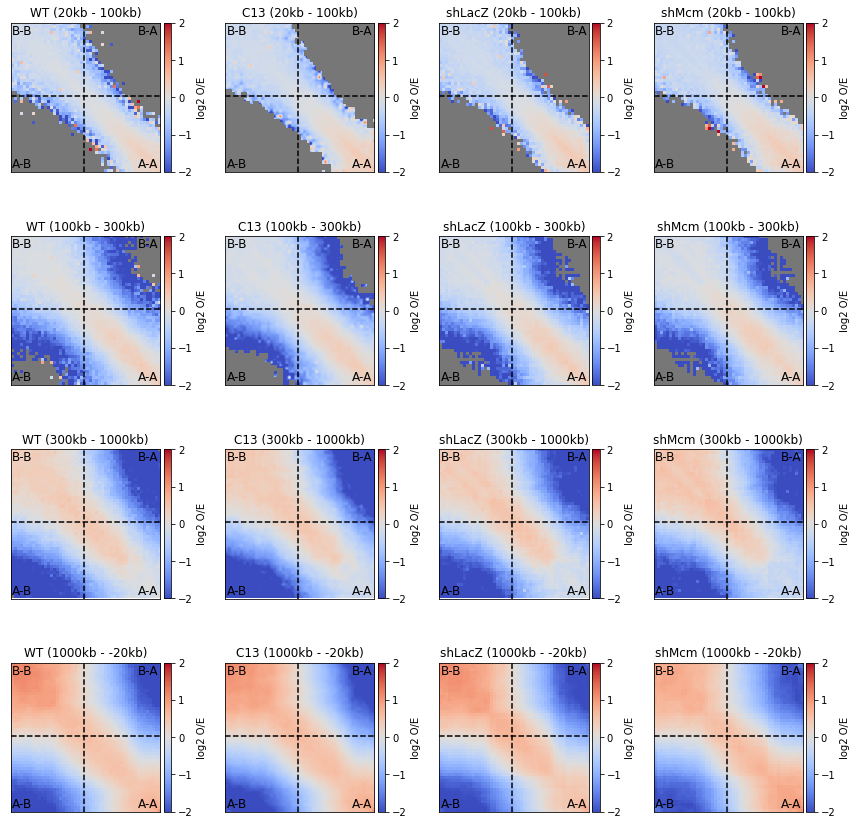

In [74]:
fig10, axs10 = plt.subplots(4, 4)
#zlim = {'WT': [-1.5, 1.5], 'C13': [-1.5, 1.5], 'shLacZ': [-1.5, 1.5], 'shMcm': [-1.5, 1.5]}
vmin, vmax = -2, 2
for i, cond in enumerate(['WT', 'C13', 'shLacZ', 'shMcm']):
    axs = axs10[:, i]
    # ignoring divide by 0 warning
    #vmin, vmax = zlim[cond]
    for ax, diags in zip(axs, [(1, 5), (5, 15), (15, 50), (50, -1)]):
        im = ax.imshow(np.log2(saddles[cond][diags][1:-1, 1:-1]),
                       cmap='coolwarm',
                       vmin = vmin,
                       vmax = vmax)
        ax.set_title('{} ({}kb - {}kb)'.format(cond, 
                                               diags[0] * binsize // 1000, 
                                               diags[1] * binsize // 1000))
        ax.set_xticks([])
        ax.set_yticks([])
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig10.add_axes(ax_cb)
        plt.colorbar(im, cax = ax_cb, label = 'log2 O/E')
        ax_cb.yaxis.tick_right()
        ax.axvline(N_GROUPS / 2 - 1, ls = '--', c = 'k')
        ax.axhline(N_GROUPS / 2 - 1, ls = '--', c = 'k')
        for (x, y), text, (va, ha) in zip([(0, 0), (N_GROUPS - 1, 0), (N_GROUPS - 1, N_GROUPS - 1), (0, N_GROUPS - 1)],
                                          ['B-B', 'B-A', 'A-A', 'A-B'],
                                          [('top', 'left'), ('top', 'right'), ('bottom', 'right'), ('bottom', 'left')]):
            ax.text(x, y, text, ha = ha, va = va, fontsize = 12)

fig10.set_figwidth(12)
fig10.set_figheight(12)
fig10.tight_layout()
fig10.savefig('plots/saddleplots.pdf')

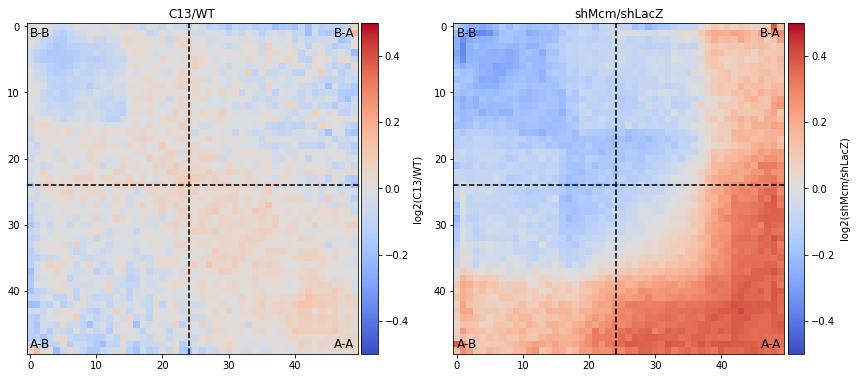

In [75]:
fig16, axs16 = plt.subplots(1, 2)
versus = [('C13', 'WT'), ('shMcm', 'shLacZ')]
vmin, vmax = -0.5, 0.5
for (cond1, cond2), ax in zip(versus, axs16):
    # ignoring divide by 0 warning
    #vmin, vmax = zlim[cond]
    im = ax.imshow(np.log2(saddles[cond1][(50, -1)][1:-1, 1:-1]/saddles[cond2][(50, -1)][1:-1, 1:-1]),
                   cmap='coolwarm',
                   vmin = vmin,
                   vmax = vmax)
    ax.set_title(f'{cond1}/{cond2}')
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig16.add_axes(ax_cb)
    plt.colorbar(im, cax = ax_cb, label = f'log2({cond1}/{cond2})')
    ax_cb.yaxis.tick_right()
    ax.axvline(N_GROUPS / 2 - 1, ls = '--', c = 'k')
    ax.axhline(N_GROUPS / 2 - 1, ls = '--', c = 'k')
    for (x, y), text, (va, ha) in zip([(0, 0), (N_GROUPS - 1, 0), (N_GROUPS - 1, N_GROUPS - 1), (0, N_GROUPS - 1)],
                                      ['B-B', 'B-A', 'A-A', 'A-B'],
                                      [('top', 'left'), ('top', 'right'), ('bottom', 'right'), ('bottom', 'left')]):
        ax.text(x, y, text, ha = ha, va = va, fontsize = 12)

fig16.set_figwidth(12)
fig16.set_figheight(6)
fig16.tight_layout()
fig16.savefig('plots/saddle_versus.pdf')

Remembering that saddle plots are not ment to directly compare conditions to one another but rather tell you about the "isolation" of compartments, we find that WT and C13 show no real difference in intercompartment interaction (contrast between A-B, B-A quarters and A-A, B-B corners are the same). In contrast, shLacZ and shMcm do show a difference in that the contrast between intra- and intercompartment interaction is lower in shMcm, where the intercompartment quarters are lighter blue and the red cloud diffuses more into these quarters. Implying a stronger intercompartment interaction as in the shLacZ, which is in concordance with the change in insulation.

In [76]:
from scipy.linalg import toeplitz
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols


def same_compartment(i, j, a_bins, b_bins):
    if i in a_bins and j in a_bins:
        return True
    
    elif i in b_bins and j in b_bins:
        return True
    
    else:
        return False

# compartment score as described in https://doi.org/10.1073/pnas.1717730115 COMPscore1   
def compartment_score_from_average_contacts(clr, 
                                            eig, 
                                            min_diag = 1, 
                                            max_diag = -1, 
                                            balance = False, 
                                            divisive_weights = False):
    binsize = clr.binsize
    selector = clr.matrix(balance = balance,
                          divisive_weights = divisive_weights)
    
    eig, eig_col = eig
    comp_score_per_chrom = {}
    for chrom in clr.chromnames:
        if max_diag == -1:
            max_diag_ = len(clr.bins().fetch(chrom))//2
        
        mat = selector.fetch(chrom)
        eig_ = eig.loc[eig.chrom == chrom, :] \
                  .reset_index()
        
        if mat.shape[0] < min_diag:
            continue
            
        a_bins = set(np.where(eig_[eig_col] > 0)[0])
        b_bins = set(np.where(eig_[eig_col] < 0)[0])
        
        intra_contacts, intra_bins, inter_contacts, inter_bins = 0, 0, 0, 0
        comp_score_per_diag = []
        for k in range(min_diag, max_diag_):
            rowidx, colidx = kth_diag_indices(mat, k)
            for i, j in zip(rowidx, colidx):
                if not np.isnan(mat[i, j]):
                    if same_compartment(i, j, a_bins, b_bins):
                        intra_contacts += mat[i, j]
                        intra_bins += 1
                    
                    else:
                        inter_contacts += mat[i, j]
                        inter_bins += 1
            
            if intra_bins and inter_bins:
                av_within = intra_contacts/intra_bins
                av_across = inter_contacts/inter_bins
                comp_score_per_diag.append((av_within - av_across)/(av_within + av_across))
            else:
                comp_score_per_diag.append(np.nan)
        
        comp_score_per_chrom[chrom] = np.nanmean(comp_score_per_diag)
    
    return np.nanmean(list(comp_score_per_chrom.values()))
    
    
def set_diags_nan(mat, min_diag, max_diag):
    for k in range(0, min_diag):
        rowidx, colidx = kth_diag_indices(mat, k)
        mat[rowidx, colidx] = np.nan
    
    if max_diag > 0 and max_diag > min_diag:
        for k in range(max_diag, mat.shape[0] + 1):
            rowidx, colidx = kth_diag_indices(mat, k)
            mat[rowidx, colidx] = np.nan
            
    return mat

# compartment score as described in https://doi.org/10.1073/pnas.1717730115 COMPscore2
def compartment_score_from_saddle_like(clr, 
                                       expected, 
                                       eig,
                                       min_diag = 1,
                                       max_diag = -1,
                                       balance = False, 
                                       divisive_weights = False, 
                                       rescale = True):
    # implement min and max_diag
    selector = clr.matrix(balance = balance, divisive_weights = divisive_weights)
    eig, eig_col = eig
    expected, count_col = expected
    expected = {k: x.values for k, x in expected.groupby("chrom")[count_col]}
    
    aa, bb, ab, ba = 0, 0, 0, 0
    for chrom in clr.chromnames:
        if max_diag == -1:
            max_diag_ = len(clr.bins().fetch(chrom))
            
        obs = selector.fetch(chrom)
        exp = toeplitz(expected[chrom])
        obsexp = set_diags_nan(obs/exp, min_diag, max_diag_)
        del obs, exp
        
        eig_ = eig.loc[eig.chrom == chrom, :] \
                  .reset_index() \
                  .sort_values(by = eig_col) \
                  .dropna(subset = [eig_col])
        
        sortidx = eig_.index
        zero_point = len(eig_[eig_[eig_col] > 0])
        aa_quadrant_idx = np.arange(zero_point)
        bb_quadrant_idx = np.arange(zero_point, len(eig_))
        sorted_obsexp = obsexp[sortidx, :][:, sortidx]
        
        aa += np.nansum(sorted_obsexp[aa_quadrant_idx, :][:, aa_quadrant_idx])
        bb += np.nansum(sorted_obsexp[bb_quadrant_idx, :][:, bb_quadrant_idx])
        ab += np.nansum(sorted_obsexp[aa_quadrant_idx, :][:, bb_quadrant_idx])
        ba += np.nansum(sorted_obsexp[bb_quadrant_idx, :][:, aa_quadrant_idx])
    
    comp_score = (aa + bb)/(ab + ba)
    return comp_score if not rescale else (comp_score - 1)/(comp_score + 1)


p = mp.Pool(8)
mpResults = {}
error_callback = lambda e: tb.print_exception(type(e), e, None)
refs = {'WT': 'WT', 'C13': 'WT', 'shLacZ': 'shLacZ', 'shMcm': 'shLacZ'}
for cond in conditions:
    ref = refs[cond]
    for binsize, min_diag in zip([20000, 200000], [100, 10]):
        args1 = [coolers[binsize][cond], 
                 (correct_eigs[binsize][ref], 'E1')]
        kwargs1 = {'min_diag': min_diag,
                   'balance': 'weight'}
        mpResults[(cond, binsize, 'average contacts')] = \
            p.apply_async(compartment_score_from_average_contacts,
                          args = args1,
                          kwds = kwargs1,
                          error_callback = error_callback)
        
        args2 = [coolers[binsize][cond], 
                 (cis_exp[binsize][cond], 'balanced.avg'),
                 (correct_eigs[binsize][ref], 'E1')]
        kwargs2 = {'min_diag': min_diag,
                   'balance': 'weight'}
        mpResults[(cond, binsize, 'saddle like')] = \
            p.apply_async(compartment_score_from_saddle_like,
                          args = args2,
                          kwds = kwargs2,
                          error_callback = error_callback)

p.close()
p.join()

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: Mean of empty slice
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: Mean of empty slice
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value 

In [77]:
# displaying compartment scores
multiIndex = pd.MultiIndex.from_tuples(it.product([20000, 200000], conditions), names = ['binsize', 'condition'])
compscores = pd.DataFrame(index = multiIndex, columns = ['average contacts', 'saddle like'])
for (cond, binsize, scoretype), mpResult in mpResults.items():
    compscores.loc[(binsize, cond), scoretype] = mpResult.get()

compscores.to_csv('plots/compartment_score_table.tsv', sep = '\t')
compscores

average contacts saddle like
binsize condition                             
20000   WT                0.394952     0.36702
        C13               0.384316    0.368539
        shLacZ            0.364527    0.373129
        shMcm             0.386088    0.388805
200000  WT                0.383607     0.35223
        C13               0.373067    0.354557
        shLacZ            0.354107    0.360712
        shMcm             0.371705    0.378437

# Saddle plots using replication timing as proxy for loci grouping

In [78]:
def read_bedgraph(bgfile, value_column, resolution, reference_df = None):
    bg = pd.read_csv(bgfile,
                     sep = '\t',
                     header = None,
                     names = ['chrom', 'start', 'end', value_column])
    
    bg = expand_bins(bg, resolution, value_column)
    
    if reference_df:
        ref_df, ref_col = reference_df
        bg = ref_df.merge(bg, on = ['chrom', 'start'], how = 'left')\
                   .rename(columns = {'end_x': 'end'})
        bg.loc[bg[ref_col].isna(), value_column] = np.nan
        bg = bg.loc[:, ['chrom', 'start', 'end', value_column]]

    return bg


binsize = 20000
rts = {cond: read_bedgraph('repliseq/CH12_{0}.loess.bedGraph'.format(cond),
                           'RT',
                           binsize, 
                           (correct_eigs[binsize][cond], 'eigvalues')) 
       for cond in conditions}
Q_LO, Q_HI, N_GROUPS = 0, 1, 50
q_edges = np.linspace(Q_LO, Q_HI, N_GROUPS+1)

digitizedRts = {}
groupRtBounds = {}
for cond in conditions:
    # Calculate the lower and the upper values of eigenvectors in each of  groups.
    groupRtBounds[cond] = cooltools.saddle.quantile(rts[reference_conditions[cond]]['RT'], q_edges)

    # Assign the group to each genomic bin according to eigenvector value
    digitizedRts[cond], hist = cooltools.saddle.digitize_track(groupRtBounds[cond],
                                                               track=(rts[reference_conditions[cond]], 'RT'))

In [79]:
# compute saddles
p = mp.Pool(4)
mpResults = {}
error_callback = lambda e: tb.print_exception(type(e), e, None)
for cond in conditions:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        args = [matrixFetchers[binsize][cond], groupRtBounds[cond], (digitizedRts[cond], 'RT.d')]
        kwargs = {'contact_type': 'cis', 'min_diag': 100}
        mpResults[cond] = p.apply_async(cooltools.saddle.make_saddle,
                                        args = args,
                                        kwds = kwargs,
                                        error_callback = error_callback)
p.close()
p.join()
rtSaddles = {}
for cond, mpResult in mpResults.items():
    S, C = mpResult.get()
    rtSaddles[cond] = S/C

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


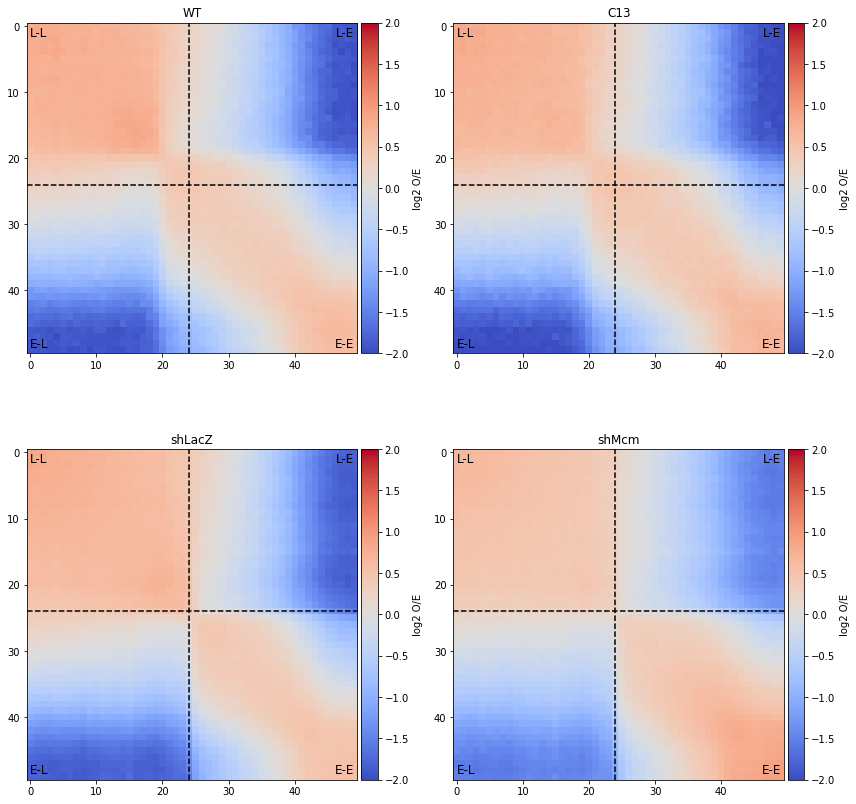

In [80]:
fig12, axs12 = plt.subplots(2, 2)
axs12 = axs12.reshape(4)
#zlim = {'WT': [-1.5, 1.5], 'C13': [-1.5, 1.5], 'shLacZ': [-1.5, 1.5], 'shMcm': [-1.5, 1.5]}
vmin, vmax = -2, 2
for ax, cond in zip(axs12, conditions):
    # ignoring divide by 0 warning
    #vmin, vmax = zlim[cond]
    im = ax.imshow(np.log2(rtSaddles[cond][1:-1, 1:-1]),
                   cmap='coolwarm',
                   vmin = vmin,
                   vmax = vmax)
    ax.set_title(cond)
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig12.add_axes(ax_cb)
    plt.colorbar(im, cax = ax_cb, label = 'log2 O/E')
    ax_cb.yaxis.tick_right()
    ax.axvline(N_GROUPS / 2 - 1, ls = '--', c = 'k')
    ax.axhline(N_GROUPS / 2 - 1, ls = '--', c = 'k')
    for (x, y), text, (va, ha) in zip([(0, 0), (N_GROUPS - 1, 0), (N_GROUPS - 1, N_GROUPS - 1), (0, N_GROUPS - 1)],
                                      ['L-L', 'L-E', 'E-E', 'E-L'],
                                      [('top', 'left'), ('top', 'right'), ('bottom', 'right'), ('bottom', 'left')]):
        ax.text(x, y, text, ha = ha, va = va, fontsize = 12)

fig12.set_figwidth(12)
fig12.set_figheight(12)
fig12.tight_layout()
fig12.savefig('plots/rtsaddleplots.pdf')

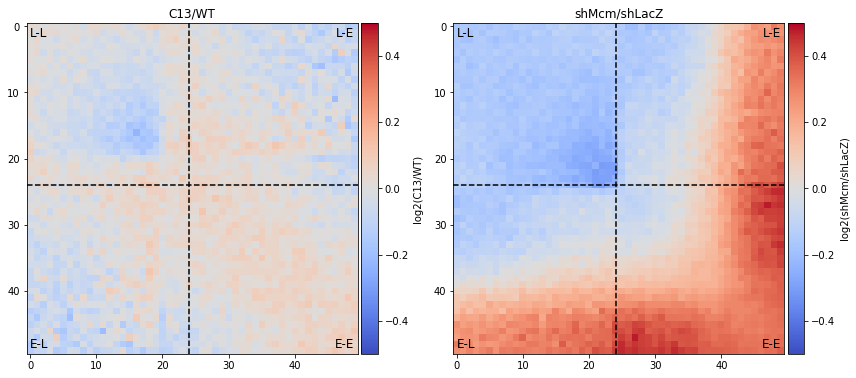

In [81]:
fig17, axs17 = plt.subplots(1, 2)
versus = [('C13', 'WT'), ('shMcm', 'shLacZ')]
vmin, vmax = -0.5, 0.5
for (cond1, cond2), ax in zip(versus, axs17):
    # ignoring divide by 0 warning
    #vmin, vmax = zlim[cond]
    im = ax.imshow(np.log2(rtSaddles[cond1][1:-1, 1:-1]/rtSaddles[cond2][1:-1, 1:-1]),
                   cmap='coolwarm',
                   vmin = vmin,
                   vmax = vmax)
    ax.set_title(f'{cond1}/{cond2}')
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig17.add_axes(ax_cb)
    plt.colorbar(im, cax = ax_cb, label = f'log2({cond1}/{cond2})')
    ax_cb.yaxis.tick_right()
    ax.axvline(N_GROUPS / 2 - 1, ls = '--', c = 'k')
    ax.axhline(N_GROUPS / 2 - 1, ls = '--', c = 'k')
    for (x, y), text, (va, ha) in zip([(0, 0), (N_GROUPS - 1, 0), (N_GROUPS - 1, N_GROUPS - 1), (0, N_GROUPS - 1)],
                                      ['L-L', 'L-E', 'E-E', 'E-L'],
                                      [('top', 'left'), ('top', 'right'), ('bottom', 'right'), ('bottom', 'left')]):
        ax.text(x, y, text, ha = ha, va = va, fontsize = 12)

fig17.set_figwidth(12)
fig17.set_figheight(6)
fig17.tight_layout()
fig17.savefig('plots/rtsaddle_versus.pdf')

# Saddle plots using H3K09me3 difference between KD and WT as proxy

In [82]:
binsize = 20000
h3k09me3 = {cond: read_bedgraph('repliseq/CH12_{0}.loess.bedGraph'.format(cond),
                               'diff',
                               binsize, 
                               (correct_eigs[binsize][cond], 'eigvalues')) 
       for cond in conditions}
Q_LO, Q_HI, N_GROUPS = 0, 1, 20
q_edges = np.linspace(Q_LO, Q_HI, N_GROUPS+1)

digitizedChip = {}
groupChipBounds = {}
for cond in conditions:
    # Calculate the lower and the upper values of eigenvectors in each of  groups.
    groupChipBounds[cond] = cooltools.saddle.quantile(h3k09me3[reference_conditions[cond]]['diff'], q_edges)

    # Assign the group to each genomic bin according to eigenvector value
    digitizedChip[cond], hist = cooltools.saddle.digitize_track(groupChipBounds[cond],
                                                               track=(h3k09me3[reference_conditions[cond]], 'diff'))

In [83]:
# compute saddles
p = mp.Pool(4)
mpResults = {}
error_callback = lambda e: tb.print_exception(type(e), e, None)
for cond in conditions:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        args = [matrixFetchers[binsize][cond], groupChipBounds[cond], (digitizedChip[cond], 'diff.d')]
        kwargs = {'contact_type': 'cis', 'min_diag': 100}
        mpResults[cond] = p.apply_async(cooltools.saddle.make_saddle,
                                        args = args,
                                        kwds = kwargs,
                                        error_callback = error_callback)
p.close()
p.join()
chipSaddles = {}
for cond, mpResult in mpResults.items():
    S, C = mpResult.get()
    chipSaddles[cond] = S/C

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/cooltools/saddle.py:147: RuntimeWarning: invalid value encountered in true_divide
  return obs_mat / exp_mat
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


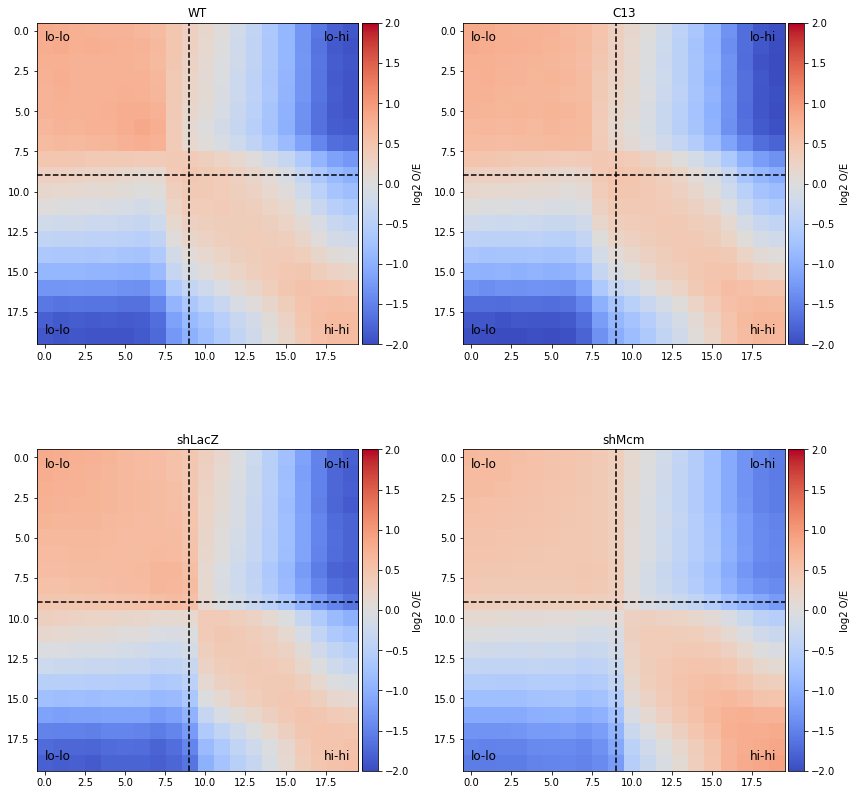

In [84]:
fig21, axs21 = plt.subplots(2, 2)
axs21 = axs21.reshape(4)
#zlim = {'WT': [-1.5, 1.5], 'C13': [-1.5, 1.5], 'shLacZ': [-1.5, 1.5], 'shMcm': [-1.5, 1.5]}
vmin, vmax = -2, 2
for ax, cond in zip(axs21, conditions):
    # ignoring divide by 0 warning
    #vmin, vmax = zlim[cond]
    im = ax.imshow(np.log2(chipSaddles[cond][1:-1, 1:-1]),
                   cmap='coolwarm',
                   vmin = vmin,
                   vmax = vmax)
    ax.set_title(cond)
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)
    fig21.add_axes(ax_cb)
    plt.colorbar(im, cax = ax_cb, label = 'log2 O/E')
    ax_cb.yaxis.tick_right()
    ax.axvline(N_GROUPS / 2 - 1, ls = '--', c = 'k')
    ax.axhline(N_GROUPS / 2 - 1, ls = '--', c = 'k')
    for (x, y), text, (va, ha) in zip([(0, 0), (N_GROUPS - 1, 0), (N_GROUPS - 1, N_GROUPS - 1), (0, N_GROUPS - 1)],
                                      ['lo-lo', 'lo-hi', 'hi-hi', 'lo-lo'],
                                      [('top', 'left'), ('top', 'right'), ('bottom', 'right'), ('bottom', 'left')]):
        ax.text(x, y, text, ha = ha, va = va, fontsize = 12)

fig21.set_figwidth(12)
fig21.set_figheight(12)
fig21.tight_layout()
fig21.savefig('plots/chipsaddleplots.pdf')

# Aggregate TAD Analysis

In [9]:
# for tads in different size ranges
def get_tads_in_range(df, lo, hi):
    lengths = df['end'] - df['start']
    return df.loc[(lo <= lengths) & (lengths <= hi), :] 

def make_tad_snipping_windows(df):
    '''unifies windows to tadsize + 50% tadsize before and after each border'''
    if not 'length' in df.columns:
        df['length'] = df['end'] - df['start']
        
    windows = []
    for l, g in df.groupby('length'):
        windows.append(snipping.make_bin_aligned_windows(binsize,
                                                         g['chrom'].copy(),
                                                         g['start'] + l//2,
                                                         flank_bp = l))
    return pd.concat(windows)


def snap_tad_bounds_to_bin_bounds(tad_df, binsize):
    df = tad_df.copy()
    for col in ['start', 'end']:
        df.loc[:, col] = df[col].apply(lambda x: (x//binsize + 1) * binsize)
    
    return df


def tad_annotate_compartment(df, eig):
    dfbt = BedTool.from_dataframe(df)
    eigbt = BedTool.from_dataframe(eig)
    inter = dfbt.intersect(eigbt, loj = True) \
                .to_dataframe(names = list(df.columns) + 
                                      ['chrom2', 'start2', 'end2'] + 
                                      list(eig.columns)[3:],
                              header = None) \
                .replace({'.': np.nan})
    inter.loc[:, 'eigvalues'] = inter['eigvalues'].apply(lambda x: float(x))
    inter = inter.groupby(['chrom', 'start', 'end', 'name']).agg({'eigvalues': 'mean'})
    inter['compartment'] = inter['eigvalues'].apply(lambda x: 'A' if x >= 0 else 'B')
    return inter.reset_index()


binsize = 10000
references = {'WT': 'WT', 'C13': 'WT', 'shLacZ': 'shLacZ', 'shMcm': 'shLacZ'}
# (0, 100000000) for all tads
ranges = [(250000, 500000), (400000, 900000), (250000, 1000000)]
tad_agg_windows = {r : {} for r in ranges}
for cond in conditions:
    ref = references[cond]
    reftads = snap_tad_bounds_to_bin_bounds(tads[ref], binsize)
    for lo, hi in ranges:
        clr = coolers[binsize][cond]
        regions = [(chrom, 0, clr.chromsizes[chrom]) for chrom in clr.chromnames]
        tad_df = get_tads_in_range(reftads, lo, hi)
        tad_df = tad_annotate_compartment(tad_df, correct_eigs[20000][ref])
        windows = make_tad_snipping_windows(tad_df)
        windows = snipping.assign_regions(windows, regions)
        tad_agg_windows[(lo, hi)][cond] = windows.dropna()

        for i, group in tad_df.groupby('compartment'):
            windows = make_tad_snipping_windows(group)
            windows = snipping.assign_regions(windows, regions)
            tad_agg_windows[(lo, hi)][cond + i] = windows.dropna()

In [10]:
def normalize_stack(stack, normfactor):
    for i in range(stack.shape[-1]):
        stack[:, :, i] = stack[:, :, i] * normfactor
    return stack


def resize_matrix(a, newsize):
    y = np.linspace(-10, 10, a.shape[0])
    x = np.linspace(-10, 10, a.shape[1])
    f = interp2d(x, y, a)
    y_new = np.linspace(-10, 10, newsize[0])
    x_new = np.linspace(-10, 10, newsize[1])
    
    return f(x_new, y_new)


# modified pileup function from cooltools to allow for different submatrix sizes
def _pileup(data_select, data_snip, arg):
    support, feature_group = arg
    # check if support region is on- or off-diagonal
    if len(support) == 2:
        region1, region2 = map(bioframe.parse_region_string, support)
    else:
        region1 = region2 = bioframe.parse_region_string(support)

    # check if features are on- or off-diagonal
    if "start" in feature_group:
        s1 = feature_group["start"].values
        e1 = feature_group["end"].values
        s2, e2 = s1, e1
    else:
        s1 = feature_group["start1"].values
        e1 = feature_group["end1"].values
        s2 = feature_group["start2"].values
        e2 = feature_group["end2"].values

    data = data_select(region1, region2)
    stack = list(map(partial(data_snip, data, region1, region2), zip(s1, e1, s2, e2)))

    return stack, feature_group["_rank"].values


def pileup(features, data_select, data_snip, submatrix_size, map=map):
    """
    Handles on-diagonal and off-diagonal cases.

    Parameters
    ----------
    features : DataFrame
        Table of features. Requires columns ['chrom', 'start', 'end'].
        Or ['chrom1', 'start1', 'end1', 'chrom1', 'start2', 'end2'].
        start, end are bp coordinates.
        lo, hi are bin coordinates.

    data_select : callable
        Callable that takes a region as argument and returns
        the data, mask and bin offset of a support region

    data_snip : callable
        Callable that takes data, mask and a 2D bin span (lo1, hi1, lo2, hi2)
        and returns a snippet from the selected support region


    """
    if features.region.isnull().any():
        raise ValueError(
            "Drop features with no region assignment before calling pileup!"
        )

    features = features.copy()
    features["_rank"] = range(len(features))

    # cumul_stack = []
    # orig_rank = []
    cumul_stack, orig_rank = zip(
        *map(
            partial(_pileup, data_select, data_snip),
            features.groupby("region", sort=False),
        )
    )
    
    stacks = []
    for stacklist in cumul_stack:
        for stack in stacklist:
            stacks.append(resize_matrix(stack, submatrix_size))
            
    # Restore the original rank of the input features
    cumul_stack = np.dstack(stacks)
    orig_rank = np.concatenate(orig_rank)

    idx = np.argsort(orig_rank)
    cumul_stack = cumul_stack[:, :, idx]
    return cumul_stack


# modified version of cooltools class to adapt for norm columns named other than weight
class CoolerSnipper:
    def __init__(self, clr, cooler_opts=None):
        self.clr = clr
        self.binsize = self.clr.binsize
        self.offsets = {}
        self.pad = True
        self.weight_col = cooler_opts['balance'] if cooler_opts.get('balance') else 'weight'
        self.cooler_opts = {} if cooler_opts is None else cooler_opts
        self.cooler_opts.setdefault("sparse", True)

    def select(self, region1, region2):
        self.offsets[region1] = self.clr.offset(region1) - self.clr.offset(region1[0])
        self.offsets[region2] = self.clr.offset(region2) - self.clr.offset(region2[0])
        self._isnan1 = np.isnan(self.clr.bins()[self.weight_col].fetch(region1).values)
        self._isnan2 = np.isnan(self.clr.bins()[self.weight_col].fetch(region2).values)
        matrix = self.clr.matrix(**self.cooler_opts).fetch(region1, region2)
        if self.cooler_opts["sparse"]:
            matrix = matrix.tocsr()
        return matrix


    def snip(self, matrix, region1, region2, tup):
        s1, e1, s2, e2 = tup
        offset1 = self.offsets[region1]
        offset2 = self.offsets[region2]
        binsize = self.binsize
        lo1, hi1 = (s1 // binsize) - offset1, (e1 // binsize) - offset1
        lo2, hi2 = (s2 // binsize) - offset2, (e2 // binsize) - offset2
        assert hi1 >= 0
        assert hi2 >= 0

        m, n = matrix.shape
        dm, dn = hi1 - lo1, hi2 - lo2
        out_of_bounds = False
        pad_left = pad_right = pad_bottom = pad_top = None
        if lo1 < 0:
            pad_bottom = -lo1
            out_of_bounds = True
        if lo2 < 0:
            pad_left = -lo2
            out_of_bounds = True
        if hi1 > m:
            pad_top = dm - (hi1 - m)
            out_of_bounds = True
        if hi2 > n:
            pad_right = dn - (hi2 - n)
            out_of_bounds = True

        if out_of_bounds:
            i0 = max(lo1, 0)
            i1 = min(hi1, m)
            j0 = max(lo2, 0)
            j1 = min(hi2, n)
            snippet = np.full((dm, dn), np.nan)
        #             snippet[pad_bottom:pad_top,
        #                     pad_left:pad_right] = matrix[i0:i1, j0:j1].toarray()
        else:
            snippet = matrix[lo1:hi1, lo2:hi2].toarray().astype('float')
            snippet[self._isnan1[lo1:hi1], :] = np.nan
            snippet[:, self._isnan2[lo2:hi2]] = np.nan
        return snippet
    

def aggregate_contacts(clr, windows, submatrix_size, normfactor = 1, cooler_opts = None):
    snipper = CoolerSnipper(clr, cooler_opts = cooler_opts)
    stack = pileup(windows, snipper.select, snipper.snip, submatrix_size)
    stack = normalize_stack(stack.copy(), normfactor)
    return stack, np.nanmean(stack, axis=2)


matrix_size = (100, 100)
p = mp.Pool(8)
ranges = [(250000, 500000), (400000, 900000), (250000, 1000000)]
mpResults = {r: {} for r in ranges}
# rpm scaling factors computed from numbers of reads in matrices 
#readnums = {'WT': 95231546, 'C13': 83406081, 'shLacZ': 414489962, 'shMcm': 493606123}
#scalefactors = {'WT': readnums['C13']/readnums['WT'], 'C13': 1, 'shLacZ': 1, 'shMcm': readnums['shLacZ']/readnums['shMcm']}
scalefactors = {'WT': 1, 'C13': 1, 'shLacZ': 1, 'shMcm': 1}
error_callback = lambda e: tb.print_exception(type(e), e, None)
for cond in conditions:
    for lo, hi in ranges:
        args = [coolers[binsize][cond], 
                tad_agg_windows[(lo, hi)][cond], 
                matrix_size, 
                scalefactors[cond],
                {'balance': 'weight', 'divisive_weights': False}]
        mpResults[(lo, hi)][cond] = p.apply_async(aggregate_contacts,
                                                  args = args,
                                                  error_callback = error_callback)
        for compartment in 'AB':
                args = [coolers[binsize][cond], 
                        tad_agg_windows[(lo, hi)][cond + compartment], 
                        matrix_size, 
                        scalefactors[cond], 
                        {'balance': 'weight', 'divisive_weights': False}]
                mpResults[(lo, hi)][cond + compartment] = p.apply_async(aggregate_contacts,
                                                                        args = args,
                                                                        error_callback = error_callback)

p.close()
p.join()

tad_stacks, tad_piles = {r : {} for r in ranges}, {r : {} for r in ranges}
for range_, mpResultDict in mpResults.items():
    for cond, mpResult in mpResultDict.items():
        tad_stacks[range_][cond], tad_piles[range_][cond] = mpResult.get()

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  # This is added back by InteractiveShellApp.init_path()


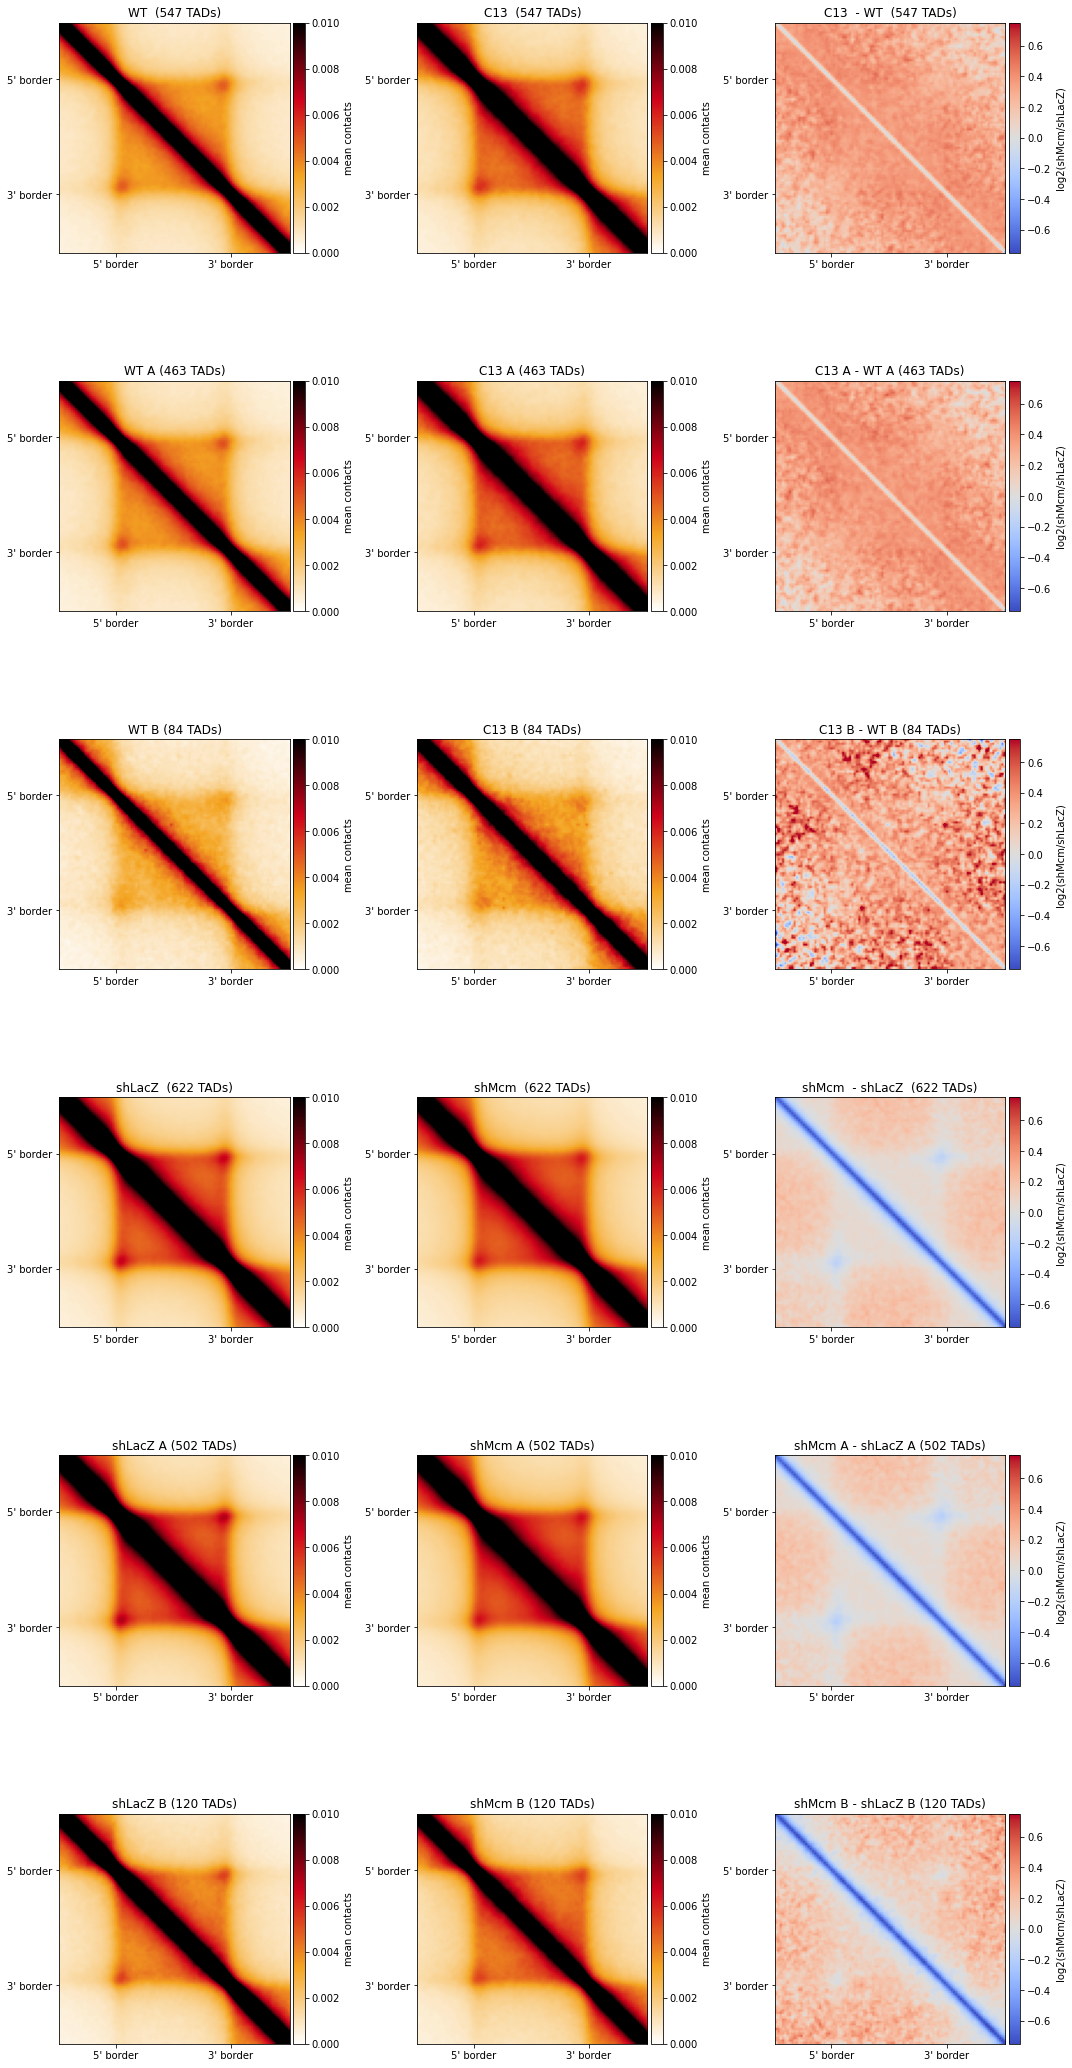

In [11]:
# TADs in size range 250kb - 500kb
from matplotlib import colors
fig18, axs18 = plt.subplots(6, 3)
cmap1 = colors.LinearSegmentedColormap.from_list('higlass',
                                                 ['white', 
                                                  [i/256 for i in [245, 166, 35]], 
                                                  [i/256 for i in [208, 2, 27]], 
                                                  'black'],
                                                 N = 256)
cmap2 = plt.get_cmap('coolwarm')
cmap2.set_bad('#777777')

range_ = (250000, 500000)
for outerloopaxs, (cond1, cond2) in zip(axs18.reshape(2, 9), [('WT', 'C13'), ('shLacZ', 'shMcm')]):
    for innerloopaxs, suffix in zip(outerloopaxs.reshape(3, 3), ['', 'A', 'B']):
        for ax, cond in zip(innerloopaxs, [cond1, cond2]):
            im = ax.imshow(tad_piles[range_][cond + suffix],
                           cmap = cmap1,
                           vmin = 0,
                           vmax = 0.01)
            ax.set_title(f'{cond} {suffix} ({len(tad_agg_windows[range_][cond + suffix])} TADs)')
            ax.set_xticks([int(matrix_size[1] * 0.25) - 1, int(matrix_size[1] * 0.75) - 1])
            ax.set_yticks([int(matrix_size[0] * 0.25) - 1, int(matrix_size[0] * 0.75) - 1])
            ax.set_xticklabels(["5' border", "3' border"])
            ax.set_yticklabels(["5' border", "3' border"])

            from mpl_toolkits.axes_grid1 import make_axes_locatable
            divider = make_axes_locatable(ax)
            ax_cb = divider.new_horizontal(size="5%", pad=0.05)
            fig18.add_axes(ax_cb)
            plt.colorbar(im, cax = ax_cb, label = 'mean contacts')
            ax_cb.yaxis.tick_right()
        
        pile1 = tad_piles[range_][cond1 + suffix]
        pile2 = tad_piles[range_][cond2 + suffix]
        ax = innerloopaxs[-1]
        im = ax.imshow(np.log2(pile2/pile1),
                       cmap = cmap2,
                       vmin = -0.75,
                       vmax = 0.75)
        ax.set_title(f'{cond2} {suffix} - {cond1} {suffix} ({len(tad_agg_windows[range_][cond2 + suffix])} TADs)')
        ax.set_xticks([int(matrix_size[1] * 0.25) - 1, int(matrix_size[1] * 0.75) - 1])
        ax.set_yticks([int(matrix_size[0] * 0.25) - 1, int(matrix_size[0] * 0.75) - 1])
        ax.set_xticklabels(["5' border", "3' border"])
        ax.set_yticklabels(["5' border", "3' border"])

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig18.add_axes(ax_cb)
        plt.colorbar(im, cax = ax_cb, label = 'log2(shMcm/shLacZ)')
        ax_cb.yaxis.tick_right()
    
fig18.set_figwidth(15)
fig18.set_figheight(30)
fig18.tight_layout()
fig18.savefig(f'plots/ata_plot_{range_[0]//1000}kb_{range_[1]//1000}kb.pdf')

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  # This is added back by InteractiveShellApp.init_path()


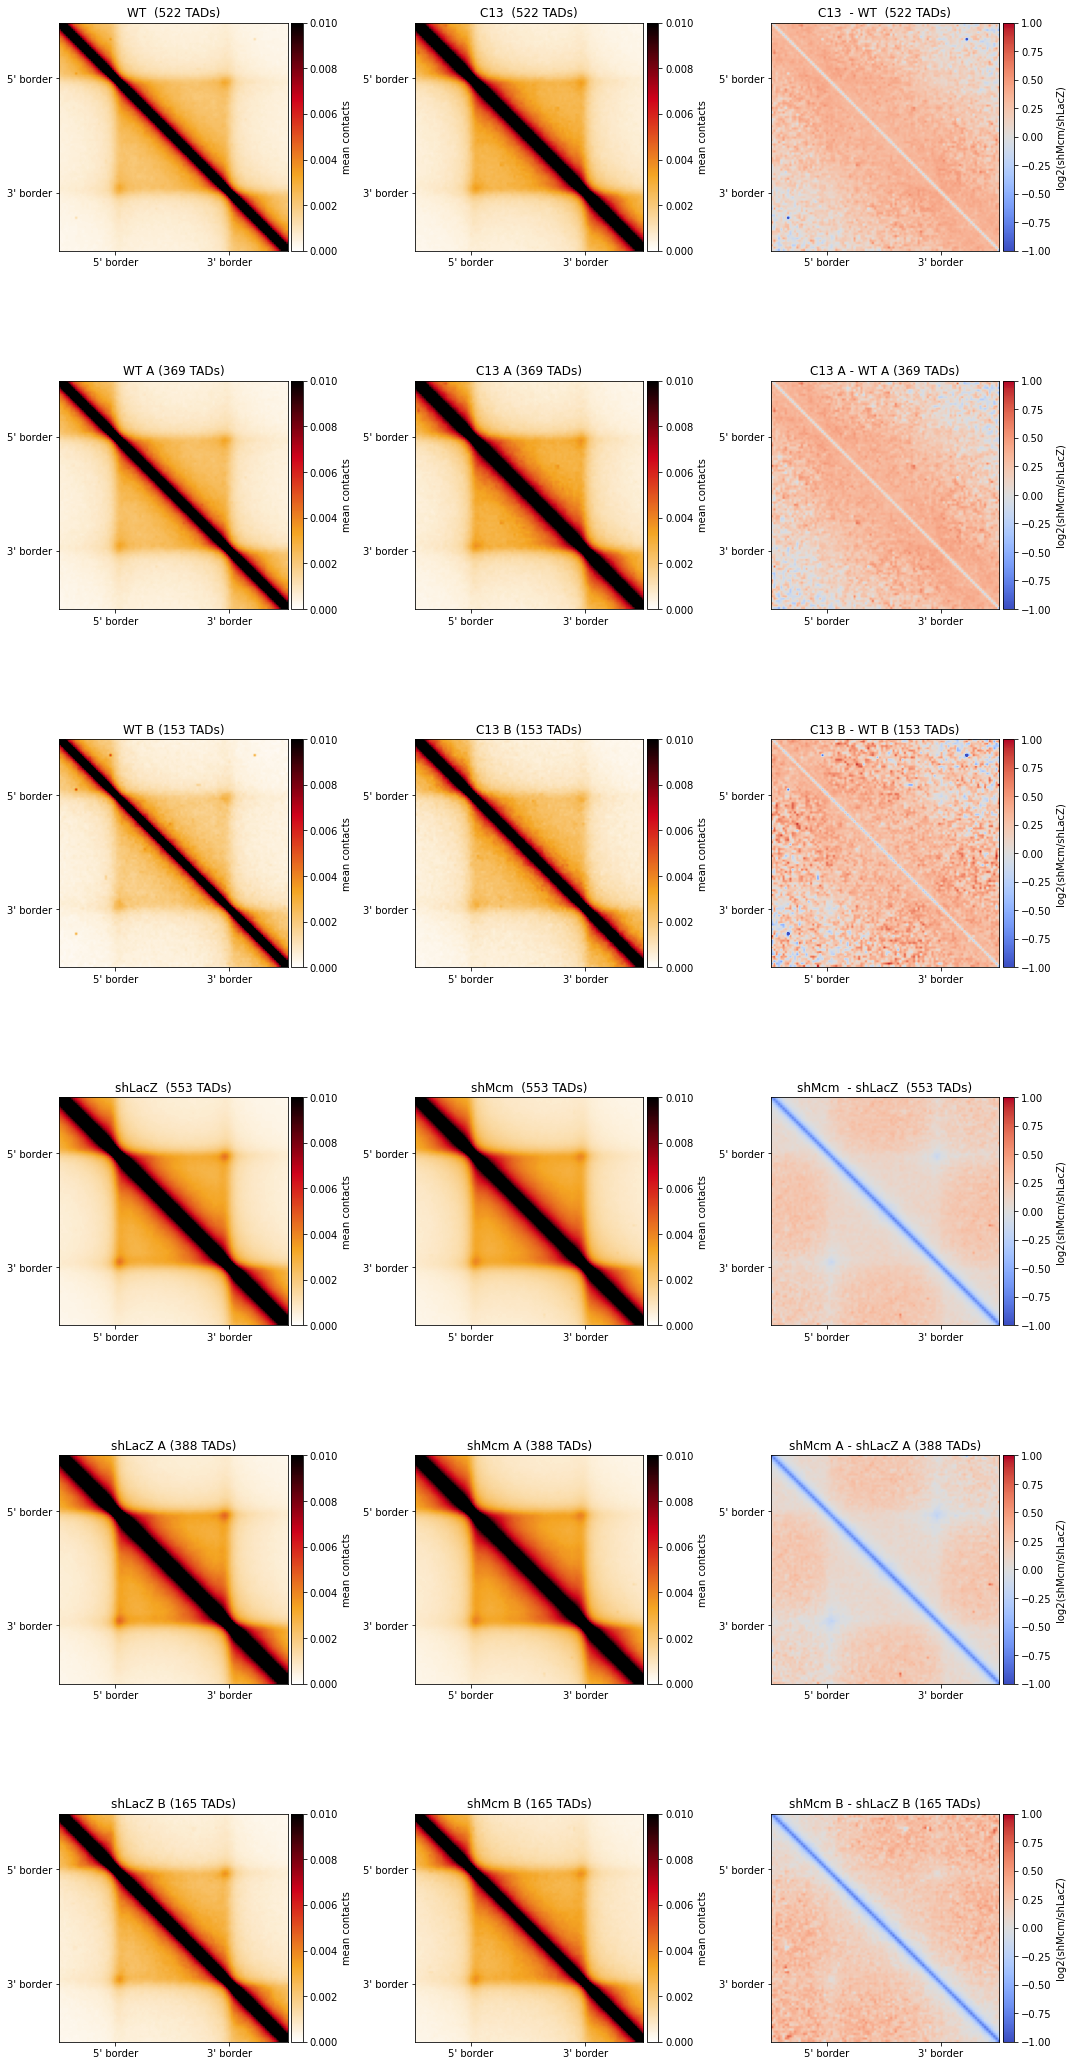

In [15]:
# TADs in sizerange 400kb - 900kb
from matplotlib import colors
fig18, axs18 = plt.subplots(6, 3)
cmap1 = colors.LinearSegmentedColormap.from_list('higlass',
                                                 ['white', 
                                                  [i/256 for i in [245, 166, 35]], 
                                                  [i/256 for i in [208, 2, 27]], 
                                                  'black'],
                                                 N = 256)
cmap2 = plt.get_cmap('coolwarm')
cmap2.set_bad('#777777')

range_ = (400000, 900000)
for outerloopaxs, (cond1, cond2) in zip(axs18.reshape(2, 9), [('WT', 'C13'), ('shLacZ', 'shMcm')]):
    for innerloopaxs, suffix in zip(outerloopaxs.reshape(3, 3), ['', 'A', 'B']):
        for ax, cond in zip(innerloopaxs, [cond1, cond2]):
            im = ax.imshow(tad_piles[range_][cond + suffix],
                           cmap = cmap1,
                           vmin = 0,
                           vmax = 0.01)
            ax.set_title(f'{cond} {suffix} ({len(tad_agg_windows[range_][cond + suffix])} TADs)')
            ax.set_xticks([int(matrix_size[1] * 0.25) - 1, int(matrix_size[1] * 0.75) - 1])
            ax.set_yticks([int(matrix_size[0] * 0.25) - 1, int(matrix_size[0] * 0.75) - 1])
            ax.set_xticklabels(["5' border", "3' border"])
            ax.set_yticklabels(["5' border", "3' border"])

            from mpl_toolkits.axes_grid1 import make_axes_locatable
            divider = make_axes_locatable(ax)
            ax_cb = divider.new_horizontal(size="5%", pad=0.05)
            fig18.add_axes(ax_cb)
            plt.colorbar(im, cax = ax_cb, label = 'mean contacts')
            ax_cb.yaxis.tick_right()
        
        pile1 = tad_piles[range_][cond1 + suffix]
        pile2 = tad_piles[range_][cond2 + suffix]
        ax = innerloopaxs[-1]
        im = ax.imshow(np.log2(pile2/pile1),
                       cmap = cmap2,
                       vmin = -1,
                       vmax = 1)
        ax.set_title(f'{cond2} {suffix} - {cond1} {suffix} ({len(tad_agg_windows[range_][cond2 + suffix])} TADs)')
        ax.set_xticks([int(matrix_size[1] * 0.25) - 1, int(matrix_size[1] * 0.75) - 1])
        ax.set_yticks([int(matrix_size[0] * 0.25) - 1, int(matrix_size[0] * 0.75) - 1])
        ax.set_xticklabels(["5' border", "3' border"])
        ax.set_yticklabels(["5' border", "3' border"])

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig18.add_axes(ax_cb)
        plt.colorbar(im, cax = ax_cb, label = 'log2(shMcm/shLacZ)')
        ax_cb.yaxis.tick_right()
    
fig18.set_figwidth(15)
fig18.set_figheight(30)
fig18.tight_layout()
fig18.savefig(f'plots/ata_plot_{range_[0]//1000}kb_{range_[1]//1000}kb.pdf')

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  # This is added back by InteractiveShellApp.init_path()


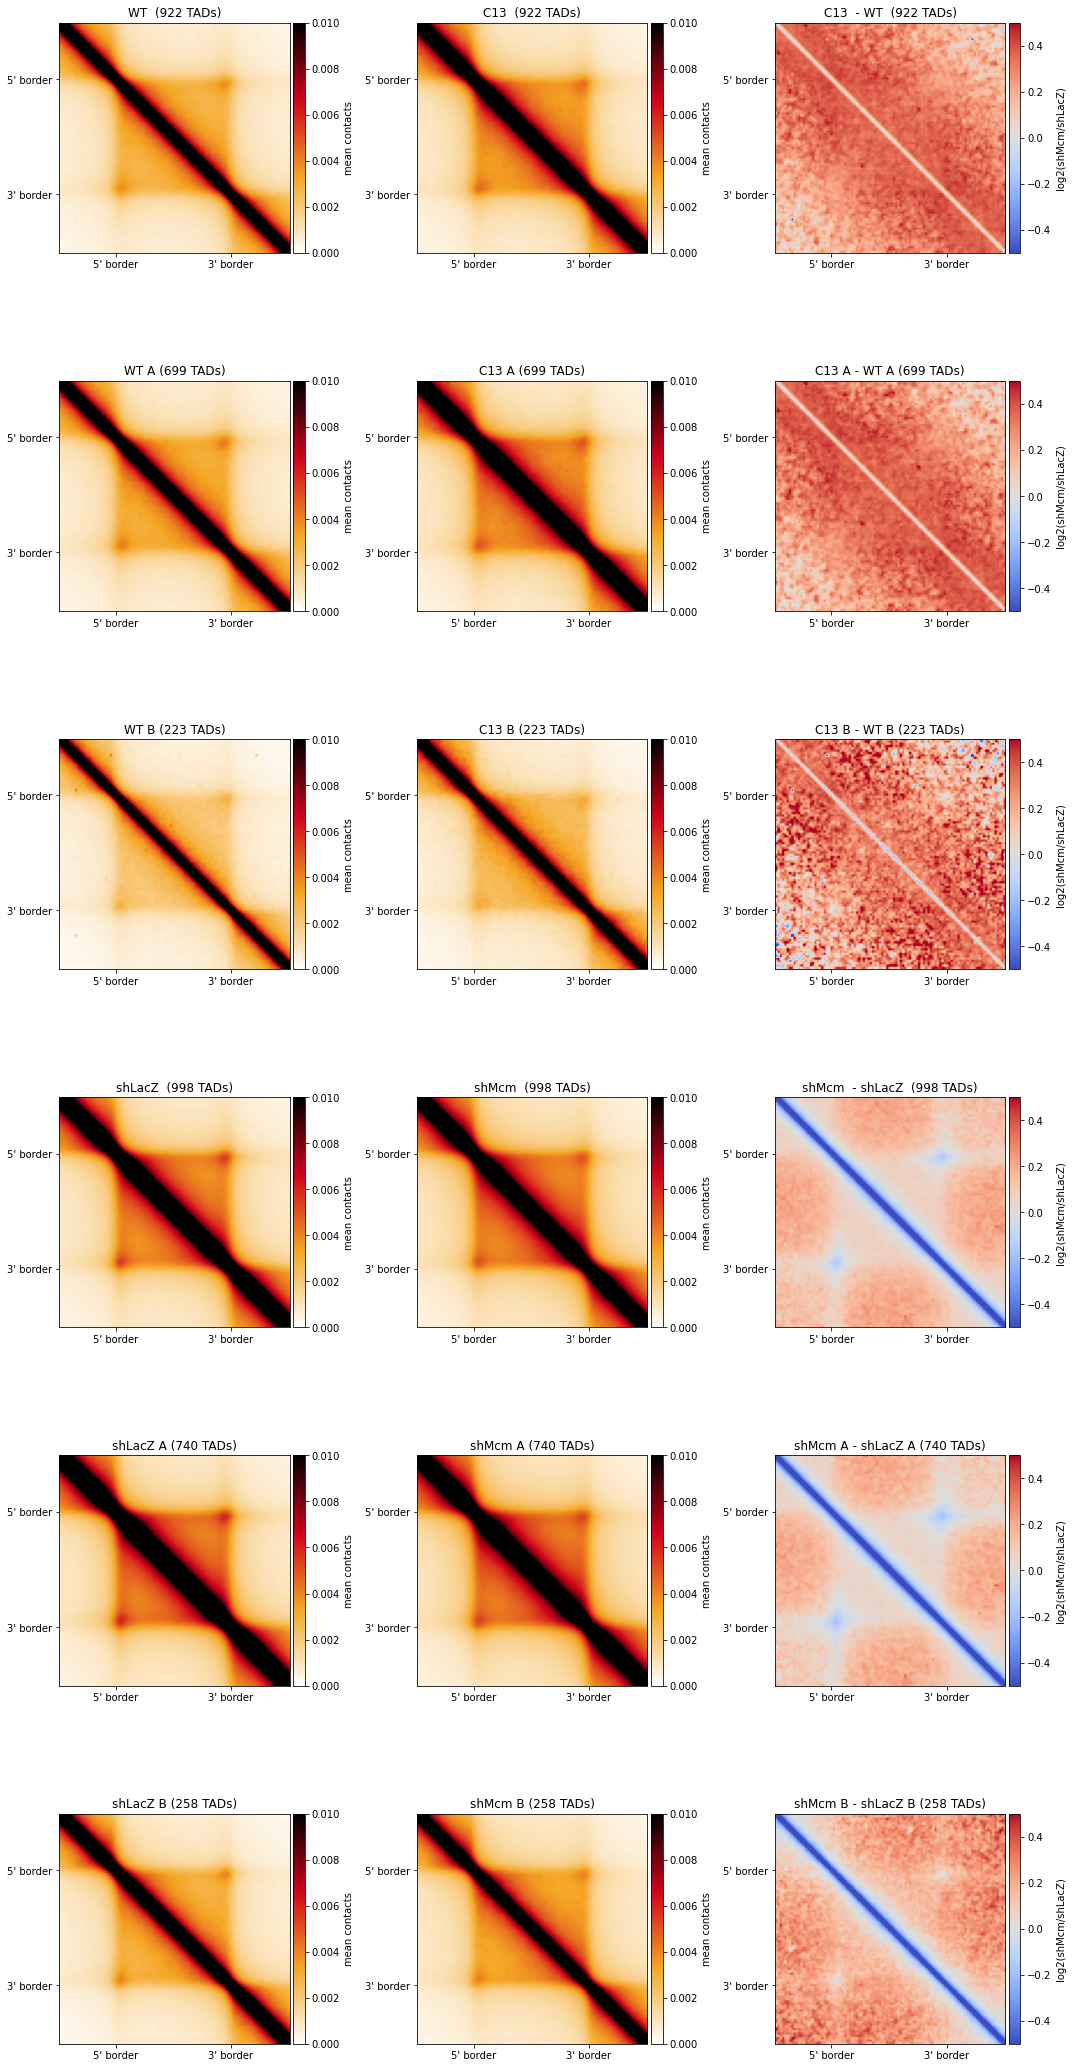

In [13]:
# TADs in sizerange 250kb - 1000kb
from matplotlib import colors
fig18, axs18 = plt.subplots(6, 3)
cmap1 = colors.LinearSegmentedColormap.from_list('higlass',
                                                 ['white', 
                                                  [i/256 for i in [245, 166, 35]], 
                                                  [i/256 for i in [208, 2, 27]], 
                                                  'black'],
                                                 N = 256)
cmap2 = plt.get_cmap('coolwarm')
cmap2.set_bad('#777777')

range_ = (250000, 1000000)
for outerloopaxs, (cond1, cond2) in zip(axs18.reshape(2, 9), [('WT', 'C13'), ('shLacZ', 'shMcm')]):
    for innerloopaxs, suffix in zip(outerloopaxs.reshape(3, 3), ['', 'A', 'B']):
        for ax, cond in zip(innerloopaxs, [cond1, cond2]):
            im = ax.imshow(tad_piles[range_][cond + suffix],
                           cmap = cmap1,
                           vmin = 0,
                           vmax = 0.01)
            ax.set_title(f'{cond} {suffix} ({len(tad_agg_windows[range_][cond + suffix])} TADs)')
            ax.set_xticks([int(matrix_size[1] * 0.25) - 1, int(matrix_size[1] * 0.75) - 1])
            ax.set_yticks([int(matrix_size[0] * 0.25) - 1, int(matrix_size[0] * 0.75) - 1])
            ax.set_xticklabels(["5' border", "3' border"])
            ax.set_yticklabels(["5' border", "3' border"])

            from mpl_toolkits.axes_grid1 import make_axes_locatable
            divider = make_axes_locatable(ax)
            ax_cb = divider.new_horizontal(size="5%", pad=0.05)
            fig18.add_axes(ax_cb)
            plt.colorbar(im, cax = ax_cb, label = 'mean contacts')
            ax_cb.yaxis.tick_right()
        
        pile1 = tad_piles[range_][cond1 + suffix]
        pile2 = tad_piles[range_][cond2 + suffix]
        ax = innerloopaxs[-1]
        im = ax.imshow(np.log2(pile2/pile1),
                       cmap = cmap2,
                       vmin = -0.5,
                       vmax = 0.5)
        ax.set_title(f'{cond2} {suffix} - {cond1} {suffix} ({len(tad_agg_windows[range_][cond2 + suffix])} TADs)')
        ax.set_xticks([int(matrix_size[1] * 0.25) - 1, int(matrix_size[1] * 0.75) - 1])
        ax.set_yticks([int(matrix_size[0] * 0.25) - 1, int(matrix_size[0] * 0.75) - 1])
        ax.set_xticklabels(["5' border", "3' border"])
        ax.set_yticklabels(["5' border", "3' border"])

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig18.add_axes(ax_cb)
        plt.colorbar(im, cax = ax_cb, label = 'log2(shMcm/shLacZ)')
        ax_cb.yaxis.tick_right()
    
fig18.set_figwidth(15)
fig18.set_figheight(30)
fig18.tight_layout()
fig18.savefig(f'plots/ata_plot_{range_[0]//1000}kb_{range_[1]//1000}kb.pdf')

# Aggregate Loop Analysis

In [6]:
loops, loopnums, looplens = {}, {}, {}
for method in ['hiccups']:
    loops[method] = {}
    loopnums[method] = np.zeros(shape = len(conditions))
    looplens[method] = []
    for i, cond in enumerate(conditions):
        loopdf = pd.read_csv(f'loops/CH12_HiC_{cond}_{method}.bedgraph',
                             sep = '\t',
                             header = None,
                             names = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2'],
                             usecols = [0, 1, 2, 3, 4, 5])
        loopdf['length'] = loopdf['start2'] + (loopdf['end2'] - loopdf['start2']) // 2 - \
                           loopdf['start1'] + (loopdf['end1'] - loopdf['start1']) // 2
        loopdf = loopdf.loc[loopdf['length'] <= 6 * 1e6, :]
        loopnums[method][i] = len(loopdf)
        loops[method][cond] = loopdf
        looplens[method].append(loopdf['length'])

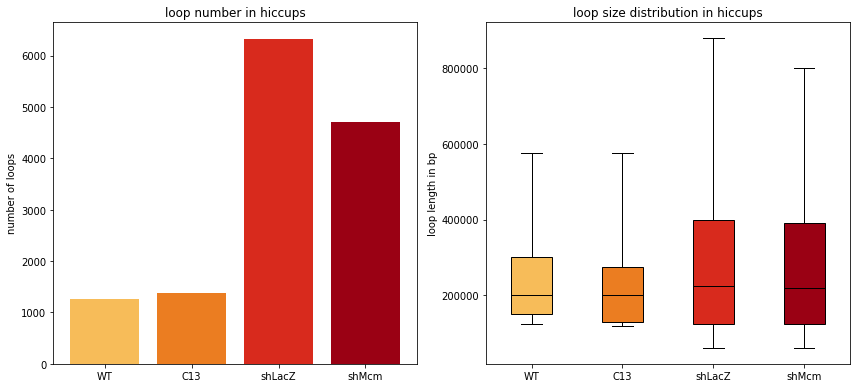

In [91]:
fig19, axs19 = plt.subplots(1, 2)
cmap = colors.LinearSegmentedColormap.from_list('higlass',
                                                ['white', 
                                                 [i/256 for i in [245, 166, 35]], 
                                                 [i/256 for i in [208, 2, 27]], 
                                                 'black'],
                                                N = 256)
colorlist = [cmap(i) for i in np.linspace(0.25, 0.75, len(conditions))]
for axrow, method in zip([axs19], ['hiccups']):
    ax1, ax2 = axrow
    ax1.bar(range(len(conditions)), 
            loopnums[method], 
            color = colorlist)
    ax1.set_xticks(range(len(conditions)))
    ax1.set_xticklabels(conditions)
    ax1.set_ylabel('number of loops')
    ax1.set_title(f'loop number in {method}')
    
    bplot = ax2.boxplot(looplens[method],
                       patch_artist = True,
                       labels = conditions,
                       showfliers = False,
                       whis = [5, 95])
    ax2.set_ylabel('loop length in bp')
    ax2.set_title(f'loop size distribution in {method}')
    for patch, color in zip(bplot['medians'], colorlist):
        patch.set_c('k')
        
    for patch, color in zip(bplot['boxes'], colorlist):
        patch.set_facecolor(color)

fig19.set_figwidth(12)
fig19.set_figheight(5.5)
fig19.tight_layout()
fig19.savefig('plots/loopstatistics.pdf')

In [92]:
def make_loop_snipping_windows(df):
    '''unifies windows to loopsize + 50% tadsize before and after each border'''
    df = df.copy()
    df['mid1'] = df['start1'] + (df['end1'] - df['start1']) // 2
    df['mid2'] = df['start2'] + (df['end2'] - df['start2']) // 2
    if not 'length' in df.columns:
        df['length'] = df['mid2'] - df['mid1']
        
        
    windows = []
    for l, g in df.groupby('length'):
        windows.append(snipping.make_bin_aligned_windows(binsize,
                                                         g['chrom1'].copy(),
                                                         g['mid1'] + l//2,
                                                         flank_bp = l))
    return pd.concat(windows)


binsize = 10000
references = {'WT': 'WT', 'C13': 'WT', 'shLacZ': 'shLacZ', 'shMcm': 'shLacZ'}
loop_agg_windows = {}
flank = 100000
method = 'hiccups'
ranges = [(300000, 600000), (300000, 1000000)]
scalefactors = {'WT': 1, 'C13': 1, 'shLacZ': 1, 'shMcm': 1}
for loopsizerange in ranges:
    loop_agg_windows[loopsizerange] = {}
    lo, hi = loopsizerange
    for cond1, cond2 in [('WT', 'C13'), ('shLacZ', 'shMcm')]:
        clr1 = coolers[binsize][cond1]
        clr2 = coolers[binsize][cond2]
        regions1 = [(chrom, 0, clr1.chromsizes[chrom]) for chrom in clr1.chromnames]
        regions2 = [(chrom, 0, clr2.chromsizes[chrom]) for chrom in clr2.chromnames]
        loopdf1 = loops[method][cond1]
        loopdf2 = loops[method][cond2]
        # filter loops that are within the specified size range
        loopdf1 = loopdf1.loc[(loopdf1['length'] >= lo) & (loopdf1['length'] <= hi)]
        loopdf2 = loopdf2.loc[(loopdf2['length'] >= lo) & (loopdf2['length'] <= hi)]
        windows11 = snipping.make_bin_aligned_windows(binsize,
                                                      loopdf1['chrom1'],
                                                      loopdf1['start1'] + (loopdf1['end1'] - loopdf1['start1'])//2,
                                                      flank_bp = flank)
        windows12 = snipping.make_bin_aligned_windows(binsize,
                                                      loopdf1['chrom2'],
                                                      loopdf1['start2'] + (loopdf1['end2'] - loopdf1['start2'])//2,
                                                      flank_bp = flank)
        windows21 = snipping.make_bin_aligned_windows(binsize,
                                                      loopdf2['chrom1'],
                                                      loopdf2['start1'] + (loopdf2['end1'] - loopdf2['start1'])//2,
                                                      flank_bp = flank)
        windows22 = snipping.make_bin_aligned_windows(binsize,
                                                      loopdf2['chrom2'],
                                                      loopdf2['start2'] + (loopdf2['end2'] - loopdf2['start2'])//2,
                                                      flank_bp = flank)
        
        windows1 = pd.merge(windows11, windows12, left_index = True, right_index = True, suffixes = ('1', '2'))
        windows2 = pd.merge(windows21, windows22, left_index = True, right_index = True, suffixes = ('1', '2'))
        windows1 = snipping.assign_regions(windows1, regions1)
        windows2 = snipping.assign_regions(windows2, regions2)
        loop_agg_windows[loopsizerange][cond1] = (windows1.dropna(), windows2.dropna())
        loop_agg_windows[loopsizerange][cond2] = (windows1.dropna(), windows2.dropna())

In [93]:
# experimental ObsExpSnipper with same adaptions as CoolerSnipper
class ObsExpSnipper:
    def __init__(self, clr, expected, cooler_opts=None):
        self.clr = clr
        self.expected, self.column = expected

        # Detecting the columns for the detection of regions
        columns = expected[0].columns
        assert len(columns) > 0
        if "chrom" in columns and "start" in columns and "end" in columns:
            self.regions_columns = [
                "chrom",
                "start",
                "end",
            ]  # Chromosome arms encoded by multiple columns
        elif "chrom" in columns:
            self.regions_columns = [
                "chrom"
            ]  # Chromosomes or regions encoded in string mode: "chr3:XXXXXXX-YYYYYYYY"
        elif "region" in columns:
            self.regions_columns = [
                "region"
            ]  # Regions encoded in string mode: "chr3:XXXXXXX-YYYYYYYY"
        elif len(columns) > 0:
            self.regions_columns = columns[
                0
            ]  # The first columns is treated as chromosome/region annotation
        else:
            raise ValueError("Expected dataframe has no columns.")

        self.binsize = self.clr.binsize
        self.offsets = {}
        self.pad = True
        self.weight_col = cooler_opts['balance'] if cooler_opts.get('balance') else 'weight'
        self.cooler_opts = {} if cooler_opts is None else cooler_opts
        self.cooler_opts.setdefault("sparse", True)

    def select(self, region1, region2):
        assert region1 == region2, "ObsExpSnipper is implemented for cis contacts only."
        self.offsets[region1] = self.clr.offset(region1) - self.clr.offset(region1[0])
        self.offsets[region2] = self.clr.offset(region2) - self.clr.offset(region2[0])
        matrix = self.clr.matrix(**self.cooler_opts).fetch(region1, region2)
        if self.cooler_opts["sparse"]:
            matrix = matrix.tocsr()
        self._isnan1 = np.isnan(self.clr.bins()[self.weight_col].fetch(region1).values)
        self._isnan2 = np.isnan(self.clr.bins()[self.weight_col].fetch(region2).values)
        self._expected = LazyToeplitz(
            self.expected.groupby(self.regions_columns)
            .get_group(region1[0] if len(self.regions_columns) > 0 else region1)[
                self.column
            ]
            .values
        )
        return matrix

    def snip(self, matrix, region1, region2, tup):
        s1, e1, s2, e2 = tup
        offset1 = self.offsets[region1]
        offset2 = self.offsets[region2]
        binsize = self.binsize
        lo1, hi1 = (s1 // binsize) - offset1, (e1 // binsize) - offset1
        lo2, hi2 = (s2 // binsize) - offset2, (e2 // binsize) - offset2
        assert hi1 >= 0
        assert hi2 >= 0

        m, n = matrix.shape
        dm, dn = hi1 - lo1, hi2 - lo2
        out_of_bounds = False
        pad_left = pad_right = pad_bottom = pad_top = None
        if lo1 < 0:
            pad_bottom = -lo1
            out_of_bounds = True
        if lo2 < 0:
            pad_left = -lo2
            out_of_bounds = True
        if hi1 > m:
            pad_top = dm - (hi1 - m)
            out_of_bounds = True
        if hi2 > n:
            pad_right = dn - (hi2 - n)
            out_of_bounds = True

        if out_of_bounds:
            i0 = max(lo1, 0)
            i1 = min(hi1, m)
            j0 = max(lo2, 0)
            j1 = min(hi2, n)
            return np.full((dm, dn), np.nan)
        #             snippet[pad_bottom:pad_top,
        #                     pad_left:pad_right] = matrix[i0:i1, j0:j1].toarray()
        else:
            snippet = matrix[lo1:hi1, lo2:hi2].toarray()
            snippet[self._isnan1[lo1:hi1], :] = np.nan
            snippet[:, self._isnan2[lo2:hi2]] = np.nan

        e = self._expected[lo1:hi1, lo2:hi2]
        return snippet / e
    
    
def aggregate_oe(clr, expected, windows, submatrix_size, normfactor = 1, cooler_opts = None):
    snipper = ObsExpSnipper(clr, expected, cooler_opts = cooler_opts)
    stack = pileup(windows, snipper.select, snipper.snip, submatrix_size)
    stack = normalize_stack(stack.copy(), normfactor)
    return stack, np.nanmean(stack, axis=2)

    
matrix_size = (20, 20)
p = mp.Pool(8)
mpResults = {}
error_callback = lambda e: tb.print_exception(type(e), e, None)
ranges = [(300000, 600000), (300000, 1000000)]
pileupmethod = 'contacts'
for loopsizerange in ranges:
    mpResults[loopsizerange] = {}
    for cond in conditions:
        mpResults[loopsizerange][cond] = []
        for windows in loop_agg_windows[loopsizerange][cond]:
            if pileupmethod == 'obsexp':
                expected = cis_exp[binsize][cond].reset_index() # this is necessary due to the chrom column being masked as index
                args = [coolers[binsize][cond], 
                        (expected, 'count.sum'), 
                        windows, 
                        matrix_size, 
                        scalefactors[cond], 
                        {'balance': 'weight', 'divisive_weights': False}]
                mpResults[loopsizerange][cond].append(p.apply_async(aggregate_oe,
                                                                    args = args,
                                                                    error_callback = error_callback))
            elif pileupmethod == 'contacts':
                args = [coolers[binsize][cond], 
                        windows, 
                        matrix_size, 
                        scalefactors[cond], 
                        {'balance': 'weight', 'divisive_weights': False}]
                mpResults[loopsizerange][cond].append(p.apply_async(aggregate_contacts,
                                                                    args = args,
                                                                    error_callback = error_callback))

p.close()
p.join()

loop_stacks, loop_piles = {}, {}
for loopsizerange, mpResultPerCond in mpResults.items():
    loop_stacks[loopsizerange], loop_piles[loopsizerange] = {}, {}
    for cond, mpResult in mpResultPerCond.items():
        res1, res2 = mpResult
        stack1, pile1 = res1.get()
        stack2, pile2 = res2.get()
        loop_stacks[loopsizerange][cond], loop_piles[loopsizerange][cond] = (stack1, stack2), (pile1, pile2)

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


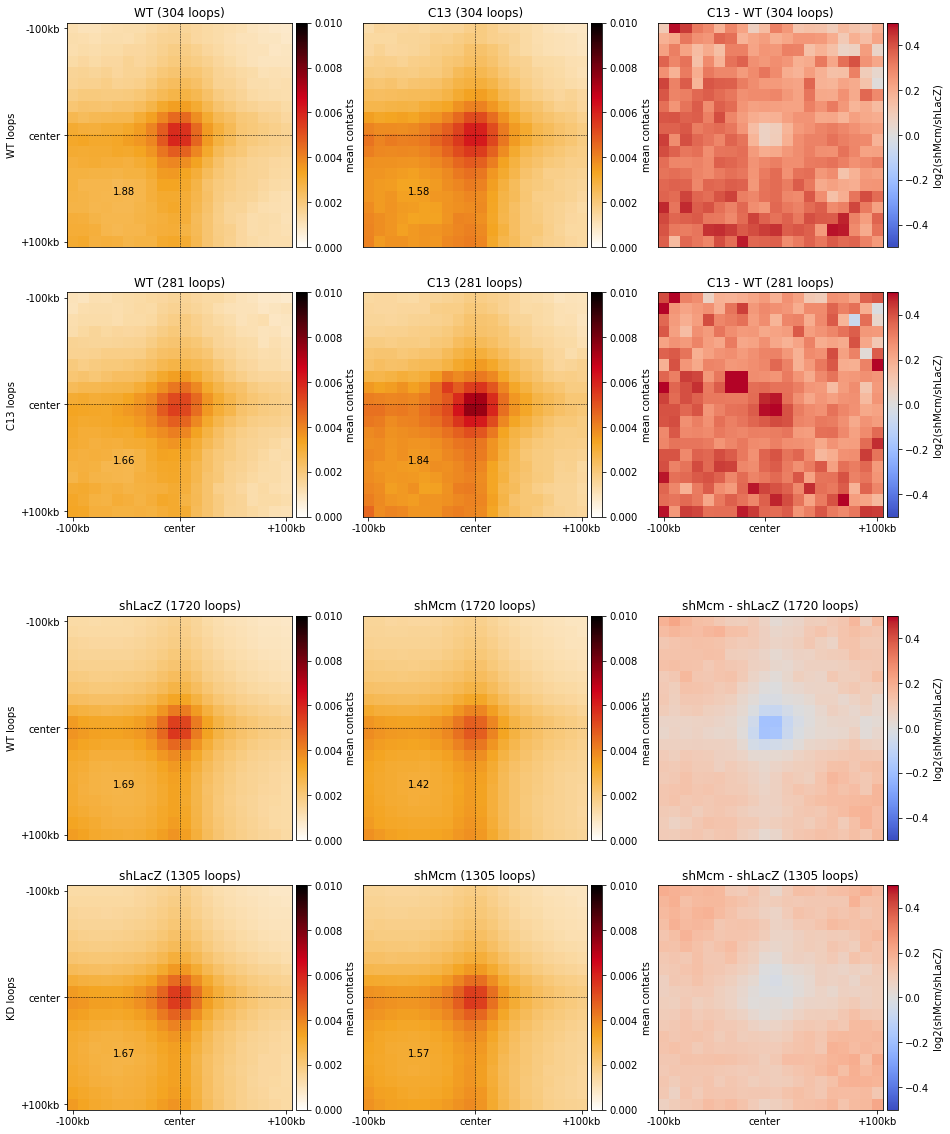

In [97]:
# loop dot aggregates for sizerange 300kb - 600kb
from matplotlib.gridspec import GridSpecFromSubplotSpec
fig20 = plt.figure()
gs20 = GridSpec(2, 1, 
                figure = fig20,
                hspace = 0.2,
                wspace = 0.2)
axs20 = []
j = 0
for i in [0, 1]:
    gs = GridSpecFromSubplotSpec(2, 3, subplot_spec = gs20[i, j])
    outercol = []
    for k in [0, 1]:
        innerrow = []
        for l in [0, 1, 2]:
            innerrow.append(fig20.add_subplot(gs[k, l]))
        outercol.append(innerrow)
    axs20.append(outercol)
        
axs20 = np.array(axs20)
cmap1 = colors.LinearSegmentedColormap.from_list('higlass',
                                                 ['white', 
                                                  [i/256 for i in [245, 166, 35]], 
                                                  [i/256 for i in [208, 2, 27]], 
                                                  'black'],
                                                 N = 256)
cmap2 = plt.get_cmap('coolwarm')
    
cmap.set_bad('#777777')
labeldict = {'WT': ('WT loops', 'C13 loops'), 
             'C13': ('WT loops', 'C13 loops'),
             'shLacZ': ('WT loops', 'KD loops'),
             'shMcm': ('WT loops', 'KD loops')}
limdict = {'WT': (0, 0.01), 'C13': (0, 0.01), 'shLacZ': (0, 0.01), 'shMcm': (0, 0.01)}
range_ = (300000, 600000)
for cond, i, l, yticks in zip(['WT', 'C13', 'shLacZ', 'shMcm'], 
                              [0, 0, 1, 1], [0, 1, 0, 1], 
                              [True, False, True, False]):
    condaxs = axs20[i][:, l]
    for pile, windows, ax, xticks, ylabel in zip(loop_piles[range_][cond], 
                                                 loop_agg_windows[range_][cond], 
                                                 condaxs,
                                                 [False, True],
                                                 labeldict[cond]):
        im = ax.imshow(pile,
                       cmap = cmap1,
                       vmin = limdict[cond][0],
                       vmax = limdict[cond][1])
        
        mid = matrix_size[1]//2
        center = pile[mid - 1: mid + 1, :][:, mid - 1: mid + 1].mean()
        lower_left = pile[mid:, :][:, :mid].mean()
        p2ll = center/lower_left
        
        ax.set_title(f'{cond} ({len(windows)} loops)')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axvline(matrix_size[1]//2 - 1 + 0.5, ls = '--', c = 'k', lw = 0.5)
        ax.axhline(matrix_size[1]//2 - 1 + 0.5, ls = '--', c = 'k', lw = 0.5)
        ax.text(matrix_size[1]//4 - 0.5, 
                matrix_size[1]//4 * 3 - 0.5, 
                '{:.2f}'.format(p2ll),
                va = 'center', 
                ha = 'center')
        if xticks:
            ax.set_xticks([0, matrix_size[1]//2 - 1 + 0.5, matrix_size[1] - 1])
            ax.set_xticklabels([f'-{flank//1000}kb', 'center', f'+{flank//1000}kb'])

        if yticks:
            ax.set_yticks([0, matrix_size[0]//2 - 1 + 0.5, matrix_size[0] - 1])
            ax.set_yticklabels([f'-{flank//1000}kb', 'center', f'+{flank//1000}kb'])
            ax.set_ylabel(ylabel)

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig20.add_axes(ax_cb)

        plt.colorbar(im, cax = ax_cb, label = 'mean contacts')
        ax_cb.yaxis.tick_right()

for i, (cond1, cond2) in zip([0, 1], [('WT', 'C13'), ('shLacZ', 'shMcm')]):
    diffaxs = axs20[i][:, 2]
    pile11, pile12 = loop_piles[range_][cond1]
    pile21, pile22 = loop_piles[range_][cond2]
    # only need for one cond since both have the same windows
    windows1, windows2 = loop_agg_windows[range_][cond1]
    for pilediff, ax, loopnum, xticks in zip([np.log2(pile21/pile11), np.log2(pile22/pile12)], 
                                             diffaxs, 
                                             [len(windows1), len(windows2)],
                                             [False, True]):
        im = ax.imshow(pilediff,
                       cmap = cmap2,
                       vmin = -0.5,
                       vmax = 0.5)

        ax.set_title(f'{cond2} - {cond1} ({loopnum} loops)')
        ax.set_xticks([])
        ax.set_yticks([])
        if xticks:
            ax.set_xticks([0, matrix_size[1]//2 - 1, matrix_size[1] - 1])
            ax.set_xticklabels([f'-{flank//1000}kb', 'center', f'+{flank//1000}kb'])

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig20.add_axes(ax_cb)

        plt.colorbar(im, cax = ax_cb, label = 'log2(shMcm/shLacZ)')
        ax_cb.yaxis.tick_right()

fig20.set_figheight(20)
fig20.set_figwidth(15)
fig20.tight_layout()
fig20.savefig(f'plots/loopdotaggregates_{range_[0]//1000}kb_{range_[1]//1000}kb.pdf')

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


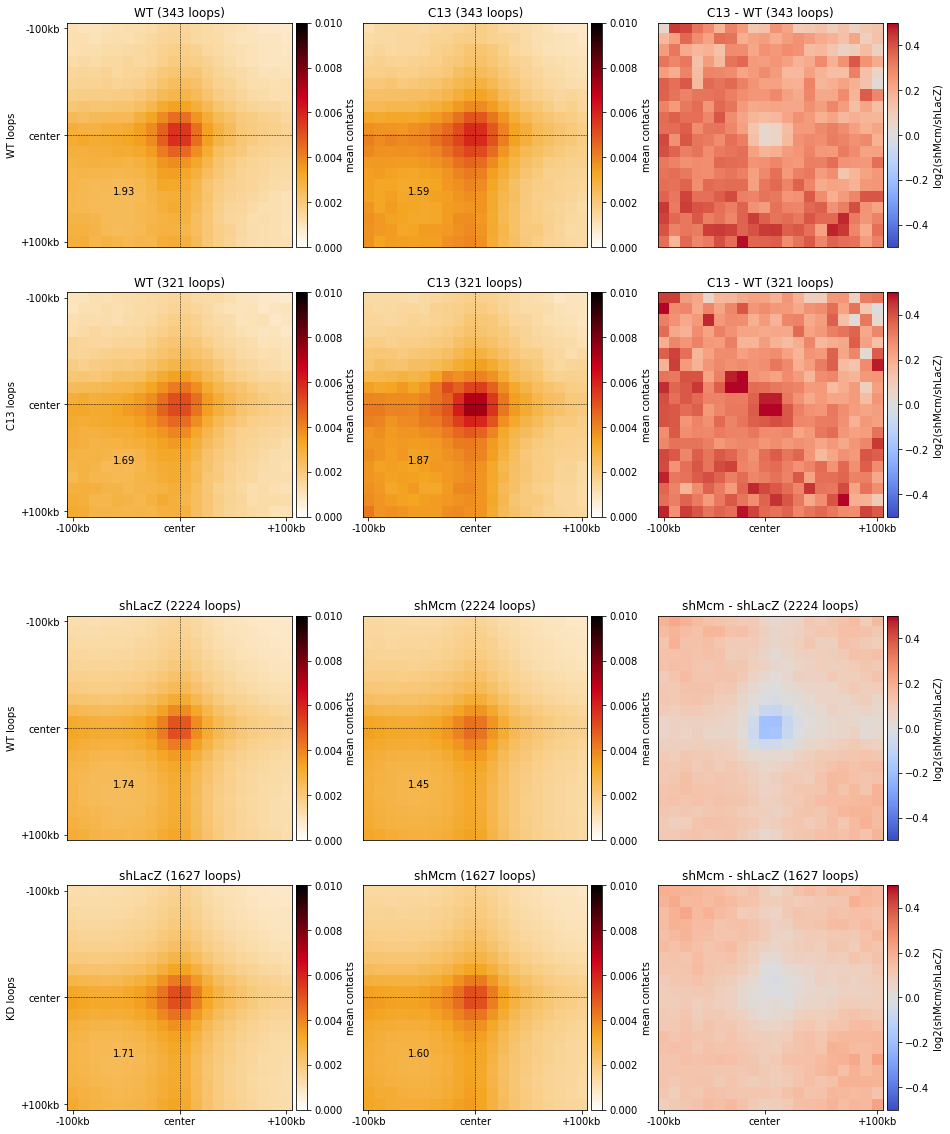

In [98]:
# loop dot aggregates for sizerange 300kb - 1Mb
from matplotlib.gridspec import GridSpecFromSubplotSpec
fig20 = plt.figure()
gs20 = GridSpec(2, 1, 
                figure = fig20,
                hspace = 0.2,
                wspace = 0.2)
axs20 = []
j = 0
for i in [0, 1]:
    gs = GridSpecFromSubplotSpec(2, 3, subplot_spec = gs20[i, j])
    outercol = []
    for k in [0, 1]:
        innerrow = []
        for l in [0, 1, 2]:
            innerrow.append(fig20.add_subplot(gs[k, l]))
        outercol.append(innerrow)
    axs20.append(outercol)
        
axs20 = np.array(axs20)
cmap1 = colors.LinearSegmentedColormap.from_list('higlass',
                                                 ['white', 
                                                  [i/256 for i in [245, 166, 35]], 
                                                  [i/256 for i in [208, 2, 27]], 
                                                  'black'],
                                                 N = 256)
cmap2 = plt.get_cmap('coolwarm')
    
cmap.set_bad('#777777')
labeldict = {'WT': ('WT loops', 'C13 loops'), 
             'C13': ('WT loops', 'C13 loops'),
             'shLacZ': ('WT loops', 'KD loops'),
             'shMcm': ('WT loops', 'KD loops')}
limdict = {'WT': (0, 0.01), 'C13': (0, 0.01), 'shLacZ': (0, 0.01), 'shMcm': (0, 0.01)}
range_ = (300000, 1000000)
for cond, i, l, yticks in zip(['WT', 'C13', 'shLacZ', 'shMcm'], 
                              [0, 0, 1, 1], [0, 1, 0, 1], 
                              [True, False, True, False]):
    condaxs = axs20[i][:, l]
    for pile, windows, ax, xticks, ylabel in zip(loop_piles[range_][cond], 
                                                 loop_agg_windows[range_][cond], 
                                                 condaxs,
                                                 [False, True],
                                                 labeldict[cond]):
        im = ax.imshow(pile,
                       cmap = cmap1,
                       vmin = limdict[cond][0],
                       vmax = limdict[cond][1])
        
        mid = matrix_size[1]//2
        center = pile[mid - 1: mid + 1, :][:, mid - 1: mid + 1].mean()
        lower_left = pile[mid:, :][:, :mid].mean()
        p2ll = center/lower_left
        
        ax.set_title(f'{cond} ({len(windows)} loops)')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axvline(matrix_size[1]//2 - 1 + 0.5, ls = '--', c = 'k', lw = 0.5)
        ax.axhline(matrix_size[1]//2 - 1 + 0.5, ls = '--', c = 'k', lw = 0.5)
        ax.text(matrix_size[1]//4 - 0.5, 
                matrix_size[1]//4 * 3 - 0.5, 
                '{:.2f}'.format(p2ll),
                va = 'center', 
                ha = 'center')
        
        if xticks:
            ax.set_xticks([0, matrix_size[1]//2 - 1 + 0.5, matrix_size[1] - 1])
            ax.set_xticklabels([f'-{flank//1000}kb', 'center', f'+{flank//1000}kb'])

        if yticks:
            ax.set_yticks([0, matrix_size[1]//2 - 1 + 0.5, matrix_size[0] - 1])
            ax.set_yticklabels([f'-{flank//1000}kb', 'center', f'+{flank//1000}kb'])
            ax.set_ylabel(ylabel)

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig20.add_axes(ax_cb)

        plt.colorbar(im, cax = ax_cb, label = 'mean contacts')
        ax_cb.yaxis.tick_right()

for i, (cond1, cond2) in zip([0, 1], [('WT', 'C13'), ('shLacZ', 'shMcm')]):
    diffaxs = axs20[i][:, 2]
    pile11, pile12 = loop_piles[range_][cond1]
    pile21, pile22 = loop_piles[range_][cond2]
    # only need for one cond since both have the same windows
    windows1, windows2 = loop_agg_windows[range_][cond1]
    for pilediff, ax, loopnum, xticks in zip([np.log2(pile21/pile11), np.log2(pile22/pile12)], 
                                             diffaxs, 
                                             [len(windows1), len(windows2)],
                                             [False, True]):
        im = ax.imshow(pilediff,
                       cmap = cmap2,
                       vmin = -0.5,
                       vmax = 0.5)

        ax.set_title(f'{cond2} - {cond1} ({loopnum} loops)')
        ax.set_xticks([])
        ax.set_yticks([])
        if xticks:
            ax.set_xticks([0, matrix_size[1]//2 - 1, matrix_size[1] - 1])
            ax.set_xticklabels([f'-{flank//1000}kb', 'center', f'+{flank//1000}kb'])

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig20.add_axes(ax_cb)

        plt.colorbar(im, cax = ax_cb, label = 'log2(shMcm/shLacZ)')
        ax_cb.yaxis.tick_right()

fig20.set_figheight(20)
fig20.set_figwidth(15)
fig20.tight_layout()
fig20.savefig(f'plots/loopdotaggregates_{range_[0]//1000}kb_{range_[1]//1000}kb.pdf')

In [99]:
binsize = 5000
references = {'WT': 'WT', 'C13': 'WT', 'shLacZ': 'shLacZ', 'shMcm': 'shLacZ'}
full_loop_agg_windows = {}
loopsizes = [150000, 180000, 300000, 600000]
matrix_sizes = {loopsize: (loopsize//binsize, ) * 2 for loopsize in loopsizes}
for loopsize in loopsizes:
    full_loop_agg_windows[loopsize] = {}
    for cond1, cond2 in [('WT', 'C13'), ('shLacZ', 'shMcm')]:
        clr1 = coolers[binsize][cond1]
        clr2 = coolers[binsize][cond2]
        regions1 = [(chrom, 0, clr1.chromsizes[chrom]) for chrom in clr1.chromnames]
        regions2 = [(chrom, 0, clr2.chromsizes[chrom]) for chrom in clr2.chromnames]
        loopdf1 = loops[method][cond1]
        loopdf2 = loops[method][cond2]
        # filter loops that are too close to the diagonal
        loopdf1 = loopdf1.loc[loopdf1['length'] == loopsize]
        loopdf2 = loopdf2.loc[loopdf2['length'] == loopsize]
        windows1 = make_loop_snipping_windows(loopdf1)
        windows2 = make_loop_snipping_windows(loopdf2)
        windows1 = snipping.assign_regions(windows1, regions1)
        windows2 = snipping.assign_regions(windows2, regions2)
        full_loop_agg_windows[loopsize][cond1] = (windows1.dropna(), windows2.dropna())
        full_loop_agg_windows[loopsize][cond2] = (windows1.dropna(), windows2.dropna())

In [104]:
p = mp.Pool(8)
matrix_size = (100, 100)
error_callback = lambda e: tb.print_exception(type(e), e, None)
pileupmethod = 'contacts'
for loopsize in loopsizes:
    mpResults[loopsize] = {}
    for cond in conditions:
        mpResults[loopsize][cond] = []
        for windows in full_loop_agg_windows[loopsize][cond]:
            if pileupmethod == 'obsexp':
                expected = cis_exp[binsize][cond].reset_index() # this is necessary due to the chrom column being masked as index
                args = [coolers[binsize][cond], 
                        (expected, 'balanced.avg'), 
                        windows, 
                        matrix_sizes[loopsize], 
                        scalefactors[cond], 
                        {'balance': 'weight', 'divisive_weights': False}]
                mpResults[loopsize][cond].append(p.apply_async(aggregate_oe,
                                                               args = args,
                                                               error_callback = error_callback))
            elif pileupmethod == 'contacts':
                args = [coolers[binsize][cond], 
                        windows, 
                        matrix_sizes[loopsize], 
                        scalefactors[cond], 
                        {'balance': 'weight', 'divisive_weights': False}]
                mpResults[loopsize][cond].append(p.apply_async(aggregate_contacts,
                                                               args = args,
                                                               error_callback = error_callback))

p.close()
p.join()

full_loop_stacks, full_loop_piles = {}, {}
for loopsize, mpResultPerMethod in mpResults.items():
    full_loop_stacks[loopsize], full_loop_piles[loopsize] = {}, {}
    for cond, mpResult in mpResultPerMethod.items():
        res1, res2 = mpResult
        stack1, pile1 = res1.get()
        stack2, pile2 = res2.get()
        full_loop_stacks[loopsize][cond], full_loop_piles[loopsize][cond] = (stack1, stack2), (pile1, pile2)

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


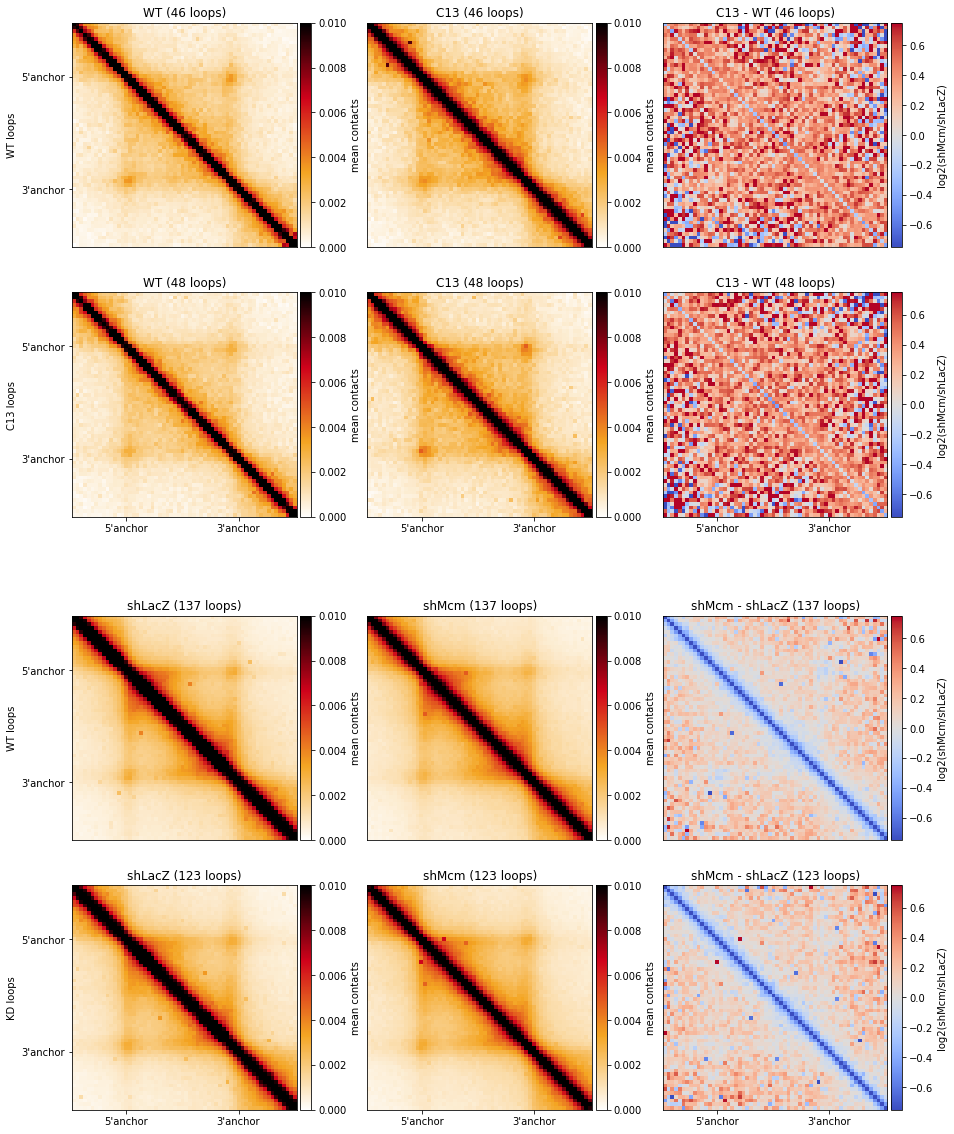

In [107]:
# aggregates for loops of size 300kb
from matplotlib.gridspec import GridSpecFromSubplotSpec
fig20 = plt.figure()
gs20 = GridSpec(2, 1, 
                figure = fig20,
                hspace = 0.2,
                wspace = 0.2)
axs20 = []
j = 0
for i in [0, 1]:
    gs = GridSpecFromSubplotSpec(2, 3, subplot_spec = gs20[i, j])
    outercol = []
    for k in [0, 1]:
        innerrow = []
        for l in [0, 1, 2]:
            innerrow.append(fig20.add_subplot(gs[k, l]))
        outercol.append(innerrow)
    axs20.append(outercol)
        
axs20 = np.array(axs20)
cmap1 = colors.LinearSegmentedColormap.from_list('higlass',
                                                 ['white', 
                                                  [i/256 for i in [245, 166, 35]], 
                                                  [i/256 for i in [208, 2, 27]], 
                                                  'black'],
                                                 N = 256)
cmap2 = plt.get_cmap('coolwarm')
    
cmap.set_bad('#777777')
labeldict = {'WT': ('WT loops', 'C13 loops'), 
             'C13': ('WT loops', 'C13 loops'),
             'shLacZ': ('WT loops', 'KD loops'),
             'shMcm': ('WT loops', 'KD loops')}
limdict = {'WT': (0, 0.01), 'C13': (0, 0.01), 'shLacZ': (0, 0.01), 'shMcm': (0, 0.01)}
loopsize = 300000
for cond, i, l, yticks in zip(['WT', 'C13', 'shLacZ', 'shMcm'], 
                              [0, 0, 1, 1], [0, 1, 0, 1], 
                              [True, False, True, False]):
    condaxs = axs20[i][:, l]
    for pile, windows, ax, xticks, ylabel in zip(full_loop_piles[loopsize][cond], 
                                                 full_loop_agg_windows[loopsize][cond], 
                                                 condaxs,
                                                 [False, True],
                                                 labeldict[cond]):
        im = ax.imshow(pile,
                       cmap = cmap1,
                       vmin = limdict[cond][0],
                       vmax = limdict[cond][1])

        ax.set_title(f'{cond} ({len(windows)} loops)')
        ax.set_xticks([])
        ax.set_yticks([])
        if xticks:
            ax.set_xticks([matrix_sizes[loopsize][1] * 0.25 - 1, matrix_sizes[loopsize][1] * 0.75 - 1])
            ax.set_xticklabels(['5\'anchor', '3\'anchor'])

        if yticks:
            ax.set_yticks([matrix_sizes[loopsize][1] * 0.25 - 1, matrix_sizes[loopsize][1] * 0.75 - 1])
            ax.set_yticklabels(['5\'anchor', '3\'anchor'])
            ax.set_ylabel(ylabel)

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig20.add_axes(ax_cb)

        plt.colorbar(im, cax = ax_cb, label = 'mean contacts')
        ax_cb.yaxis.tick_right()

for i, (cond1, cond2) in zip([0, 1], [('WT', 'C13'), ('shLacZ', 'shMcm')]):
    diffaxs = axs20[i][:, 2]
    pile11, pile12 = full_loop_piles[loopsize][cond1]
    pile21, pile22 = full_loop_piles[loopsize][cond2]
    # only need for one cond since both have the same windows
    windows1, windows2 = full_loop_agg_windows[loopsize][cond1]
    for pilediff, ax, loopnum, xticks in zip([np.log2(pile21/pile11), np.log2(pile22/pile12)], 
                                             diffaxs, 
                                             [len(windows1), len(windows2)],
                                             [False, True]):
        im = ax.imshow(pilediff,
                       cmap = cmap2,
                       vmin = -0.75,
                       vmax = 0.75)

        ax.set_title(f'{cond2} - {cond1} ({loopnum} loops)')
        ax.set_xticks([])
        ax.set_yticks([])
        if xticks:
            ax.set_xticks([matrix_sizes[loopsize][1] * 0.25 - 1, matrix_sizes[loopsize][1] * 0.75 - 1])
            ax.set_xticklabels(['5\'anchor', '3\'anchor'])

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig20.add_axes(ax_cb)

        plt.colorbar(im, cax = ax_cb, label = 'log2(shMcm/shLacZ)')
        ax_cb.yaxis.tick_right()

fig20.set_figheight(20)
fig20.set_figwidth(15)
fig20.tight_layout()
fig20.savefig(f'plots/loopfullaggregates_{loopsize//1000}kb.pdf')

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log2
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


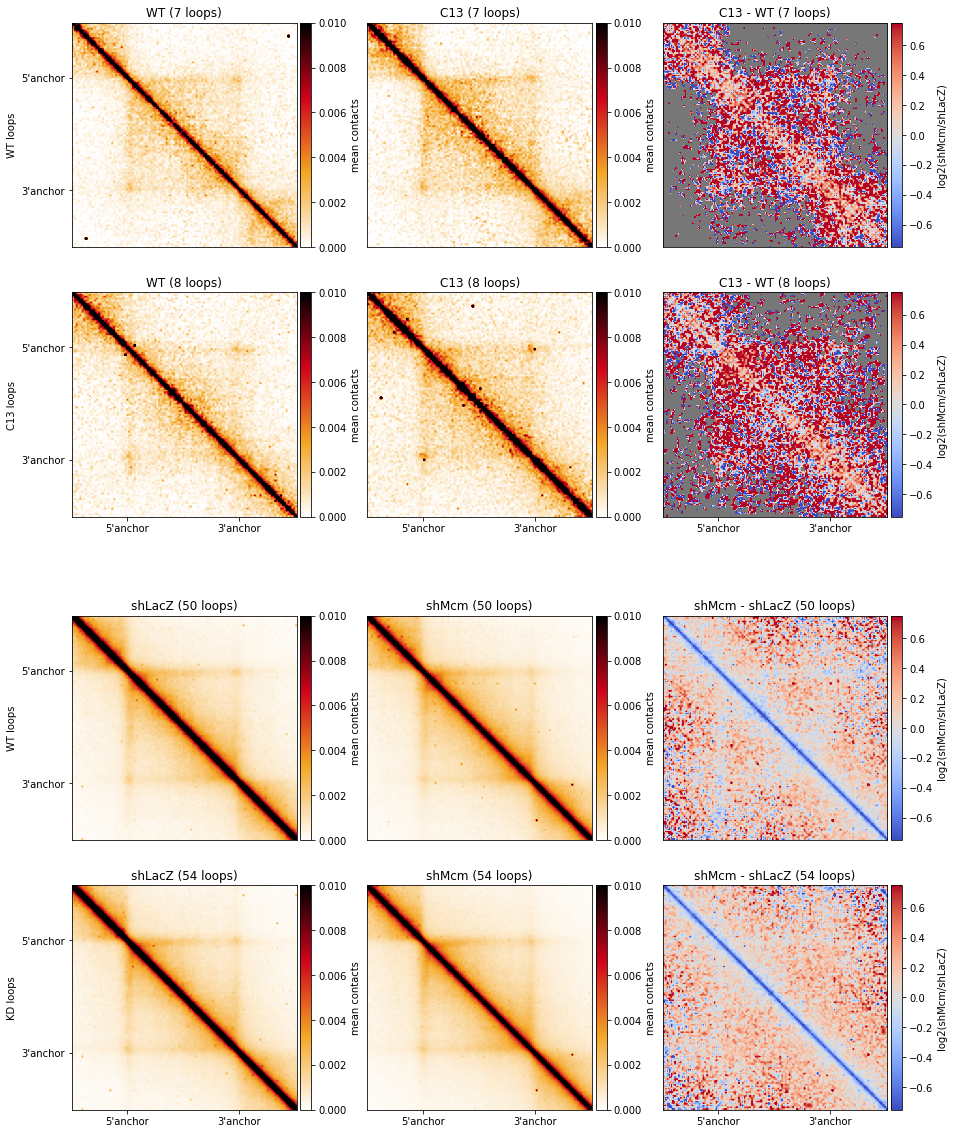

In [108]:
# aggregates for loops of size 600kb
from matplotlib.gridspec import GridSpecFromSubplotSpec
fig20 = plt.figure()
gs20 = GridSpec(2, 1, 
                figure = fig20,
                hspace = 0.2,
                wspace = 0.2)
axs20 = []
j = 0
for i in [0, 1]:
    gs = GridSpecFromSubplotSpec(2, 3, subplot_spec = gs20[i, j])
    outercol = []
    for k in [0, 1]:
        innerrow = []
        for l in [0, 1, 2]:
            innerrow.append(fig20.add_subplot(gs[k, l]))
        outercol.append(innerrow)
    axs20.append(outercol)
        
axs20 = np.array(axs20)
cmap1 = colors.LinearSegmentedColormap.from_list('higlass',
                                                 ['white', 
                                                  [i/256 for i in [245, 166, 35]], 
                                                  [i/256 for i in [208, 2, 27]], 
                                                  'black'],
                                                 N = 256)
cmap2 = plt.get_cmap('coolwarm')
    
cmap.set_bad('#777777')
labeldict = {'WT': ('WT loops', 'C13 loops'), 
             'C13': ('WT loops', 'C13 loops'),
             'shLacZ': ('WT loops', 'KD loops'),
             'shMcm': ('WT loops', 'KD loops')}
limdict = {'WT': (0, 0.01), 'C13': (0, 0.01), 'shLacZ': (0, 0.01), 'shMcm': (0, 0.01)}
loopsize = 600000
for cond, i, l, yticks in zip(['WT', 'C13', 'shLacZ', 'shMcm'], 
                              [0, 0, 1, 1], [0, 1, 0, 1], 
                              [True, False, True, False]):
    condaxs = axs20[i][:, l]
    for pile, windows, ax, xticks, ylabel in zip(full_loop_piles[loopsize][cond], 
                                                 full_loop_agg_windows[loopsize][cond], 
                                                 condaxs,
                                                 [False, True],
                                                 labeldict[cond]):
        im = ax.imshow(pile,
                       cmap = cmap1,
                       vmin = limdict[cond][0],
                       vmax = limdict[cond][1])

        ax.set_title(f'{cond} ({len(windows)} loops)')
        ax.set_xticks([])
        ax.set_yticks([])
        if xticks:
            ax.set_xticks([matrix_sizes[loopsize][1] * 0.25 - 1, matrix_sizes[loopsize][1] * 0.75 - 1])
            ax.set_xticklabels(['5\'anchor', '3\'anchor'])

        if yticks:
            ax.set_yticks([matrix_sizes[loopsize][1] * 0.25 - 1, matrix_sizes[loopsize][1] * 0.75 - 1])
            ax.set_yticklabels(['5\'anchor', '3\'anchor'])
            ax.set_ylabel(ylabel)

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig20.add_axes(ax_cb)

        plt.colorbar(im, cax = ax_cb, label = 'mean contacts')
        ax_cb.yaxis.tick_right()

for i, (cond1, cond2) in zip([0, 1], [('WT', 'C13'), ('shLacZ', 'shMcm')]):
    diffaxs = axs20[i][:, 2]
    pile11, pile12 = full_loop_piles[loopsize][cond1]
    pile21, pile22 = full_loop_piles[loopsize][cond2]
    # only need for one cond since both have the same windows
    windows1, windows2 = full_loop_agg_windows[loopsize][cond1]
    for pilediff, ax, loopnum, xticks in zip([np.log2(pile21/pile11), np.log2(pile22/pile12)], 
                                             diffaxs, 
                                             [len(windows1), len(windows2)],
                                             [False, True]):
        im = ax.imshow(pilediff,
                       cmap = cmap2,
                       vmin = -0.75,
                       vmax = 0.75)

        ax.set_title(f'{cond2} - {cond1} ({loopnum} loops)')
        ax.set_xticks([])
        ax.set_yticks([])
        if xticks:
            ax.set_xticks([matrix_sizes[loopsize][1] * 0.25 - 1, matrix_sizes[loopsize][1] * 0.75 - 1])
            ax.set_xticklabels(['5\'anchor', '3\'anchor'])

        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)
        fig20.add_axes(ax_cb)

        plt.colorbar(im, cax = ax_cb, label = 'log2(shMcm/shLacZ)')
        ax_cb.yaxis.tick_right()

fig20.set_figheight(20)
fig20.set_figwidth(15)
fig20.tight_layout()
fig20.savefig(f'plots/loopfullaggregates_{loopsize//1000}kb.pdf')

In [14]:
def randomize_loop_positions(loop_positions, chromsizes):
    rand_loops = []
    for i, loop in loop_positions.iterrows():
        anchor_binsize = loop['end1'] - loop['start1']
        chrom_size = chromsizes[loop['chrom1']]
        anchor1_randstart = np.random.choice(np.arange(0, chrom_size - loop['length'], anchor_binsize))
        anchor1_randend = anchor1_randstart + anchor_binsize
        anchor2_randstart = anchor1_randstart + loop['length']
        anchor2_randend = anchor2_randstart + anchor_binsize
        rand_loops.append([loop['chrom1'], anchor1_randstart, anchor1_randend, 
                           loop['chrom1'], anchor2_randstart, anchor2_randend,
                           loop['length']])
        
    return pd.DataFrame(rand_loops,
                        columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'length'])

binsize = 10000
references = {'WT': 'WT', 'C13': 'WT', 'shLacZ': 'shLacZ', 'shMcm': 'shLacZ'}
loop_dot_agg_windows = {}
flank = 10000
method = 'hiccups'
scalefactors = {'WT': 1, 'C13': 1, 'shLacZ': 1, 'shMcm': 1}
for cond in conditions:
    ref_loops = loops[method][references[cond]]
    loop_dot_agg_windows[cond] = {}
    for loop_length, loopdf in ref_loops.groupby('length'):
        clr = coolers[binsize][cond]
        regions = [(chrom, 0, clr.chromsizes[chrom]) for chrom in clr.chromnames]
        randloopdf = randomize_loop_positions(loopdf, chromsizes)
        
        windows11 = snipping.make_bin_aligned_windows(binsize,
                                                      loopdf['chrom1'],
                                                      loopdf['start1'] + (loopdf['end1'] - loopdf['start1'])//2,
                                                      flank_bp = flank)
        windows12 = snipping.make_bin_aligned_windows(binsize,
                                                      loopdf['chrom2'],
                                                      loopdf['start2'] + (loopdf['end2'] - loopdf['start2'])//2,
                                                      flank_bp = flank)
        windows21 = snipping.make_bin_aligned_windows(binsize,
                                                      randloopdf['chrom1'],
                                                      randloopdf['start1'] + (randloopdf['end1'] - randloopdf['start1'])//2,
                                                      flank_bp = flank)
        windows22 = snipping.make_bin_aligned_windows(binsize,
                                                      randloopdf['chrom2'],
                                                      randloopdf['start2'] + (randloopdf['end2'] - randloopdf['start2'])//2,
                                                      flank_bp = flank)
        
        windows = pd.merge(windows11, windows12, left_index = True, right_index = True, suffixes = ('1', '2'))
        randwindows = pd.merge(windows21, windows22, left_index = True, right_index = True, suffixes = ('1', '2'))
        windows = snipping.assign_regions(windows, regions)
        randwindows = snipping.assign_regions(randwindows, regions)
        loop_dot_agg_windows[cond][loop_length] = (windows.dropna(), randwindows.dropna())

In [20]:
def normalize_stack(stack, normfactor):
    for i in range(stack.shape[-1]):
        stack[:, :, i] = stack[:, :, i] * normfactor
    return stack


def resize_matrix(a, newsize):
    y = np.linspace(-10, 10, a.shape[0])
    x = np.linspace(-10, 10, a.shape[1])
    f = interp2d(x, y, a)
    y_new = np.linspace(-10, 10, newsize[0])
    x_new = np.linspace(-10, 10, newsize[1])
    
    return f(x_new, y_new)


# modified pileup function from cooltools to allow for different submatrix sizes
def _pileup(data_select, data_snip, arg):
    support, feature_group = arg
    # check if support region is on- or off-diagonal
    if len(support) == 2:
        region1, region2 = map(bioframe.parse_region_string, support)
    else:
        region1 = region2 = bioframe.parse_region_string(support)

    # check if features are on- or off-diagonal
    if "start" in feature_group:
        s1 = feature_group["start"].values
        e1 = feature_group["end"].values
        s2, e2 = s1, e1
    else:
        s1 = feature_group["start1"].values
        e1 = feature_group["end1"].values
        s2 = feature_group["start2"].values
        e2 = feature_group["end2"].values

    data = data_select(region1, region2)
    stack = list(map(partial(data_snip, data, region1, region2), zip(s1, e1, s2, e2)))

    return stack, feature_group["_rank"].values


def pileup(features, data_select, data_snip, submatrix_size, map=map):
    """
    Handles on-diagonal and off-diagonal cases.

    Parameters
    ----------
    features : DataFrame
        Table of features. Requires columns ['chrom', 'start', 'end'].
        Or ['chrom1', 'start1', 'end1', 'chrom1', 'start2', 'end2'].
        start, end are bp coordinates.
        lo, hi are bin coordinates.

    data_select : callable
        Callable that takes a region as argument and returns
        the data, mask and bin offset of a support region

    data_snip : callable
        Callable that takes data, mask and a 2D bin span (lo1, hi1, lo2, hi2)
        and returns a snippet from the selected support region


    """
    if features.region.isnull().any():
        raise ValueError(
            "Drop features with no region assignment before calling pileup!"
        )

    features = features.copy()
    features["_rank"] = range(len(features))

    # cumul_stack = []
    # orig_rank = []
    cumul_stack, orig_rank = zip(
        *map(
            partial(_pileup, data_select, data_snip),
            features.groupby("region", sort=False),
        )
    )
    
    stacks = []
    for stacklist in cumul_stack:
        for stack in stacklist:
            stacks.append(resize_matrix(stack, submatrix_size))
            
    # Restore the original rank of the input features
    cumul_stack = np.dstack(stacks)
    orig_rank = np.concatenate(orig_rank)

    idx = np.argsort(orig_rank)
    cumul_stack = cumul_stack[:, :, idx]
    return cumul_stack


# modified version of cooltools class to adapt for norm columns named other than weight
class CoolerSnipper:
    def __init__(self, clr, cooler_opts=None):
        self.clr = clr
        self.binsize = self.clr.binsize
        self.offsets = {}
        self.pad = True
        self.weight_col = cooler_opts['balance'] if cooler_opts.get('balance') else 'weight'
        self.cooler_opts = {} if cooler_opts is None else cooler_opts
        self.cooler_opts.setdefault("sparse", True)

    def select(self, region1, region2):
        self.offsets[region1] = self.clr.offset(region1) - self.clr.offset(region1[0])
        self.offsets[region2] = self.clr.offset(region2) - self.clr.offset(region2[0])
        self._isnan1 = np.isnan(self.clr.bins()[self.weight_col].fetch(region1).values)
        self._isnan2 = np.isnan(self.clr.bins()[self.weight_col].fetch(region2).values)
        matrix = self.clr.matrix(**self.cooler_opts).fetch(region1, region2)
        if self.cooler_opts["sparse"]:
            matrix = matrix.tocsr()
        return matrix


    def snip(self, matrix, region1, region2, tup):
        s1, e1, s2, e2 = tup
        offset1 = self.offsets[region1]
        offset2 = self.offsets[region2]
        binsize = self.binsize
        lo1, hi1 = (s1 // binsize) - offset1, (e1 // binsize) - offset1
        lo2, hi2 = (s2 // binsize) - offset2, (e2 // binsize) - offset2
        assert hi1 >= 0
        assert hi2 >= 0

        m, n = matrix.shape
        dm, dn = hi1 - lo1, hi2 - lo2
        out_of_bounds = False
        pad_left = pad_right = pad_bottom = pad_top = None
        if lo1 < 0:
            pad_bottom = -lo1
            out_of_bounds = True
        if lo2 < 0:
            pad_left = -lo2
            out_of_bounds = True
        if hi1 > m:
            pad_top = dm - (hi1 - m)
            out_of_bounds = True
        if hi2 > n:
            pad_right = dn - (hi2 - n)
            out_of_bounds = True

        if out_of_bounds:
            i0 = max(lo1, 0)
            i1 = min(hi1, m)
            j0 = max(lo2, 0)
            j1 = min(hi2, n)
            snippet = np.full((dm, dn), np.nan)
        #             snippet[pad_bottom:pad_top,
        #                     pad_left:pad_right] = matrix[i0:i1, j0:j1].toarray()
        else:
            snippet = matrix[lo1:hi1, lo2:hi2].toarray().astype('float')
            snippet[self._isnan1[lo1:hi1], :] = np.nan
            snippet[:, self._isnan2[lo2:hi2]] = np.nan
        return snippet
    

def aggregate_contacts(clr, windows, submatrix_size, normfactor = 1, cooler_opts = None):
    snipper = CoolerSnipper(clr, cooler_opts = cooler_opts)
    stack = pileup(windows, snipper.select, snipper.snip, submatrix_size)
    stack = normalize_stack(stack.copy(), normfactor)
    return stack, np.nanmean(stack, axis=2)


matrix_size = (2, 2)
p = mp.Pool(16)
mpResults = {}
error_callback = lambda e: tb.print_exception(type(e), e, None)
for cond in conditions:
    mpResults[cond] = {}
    for loop_length in loop_dot_agg_windows[cond].keys():
        mpResults[cond][loop_length] = []
        for windows in loop_dot_agg_windows[cond][loop_length]:
            args = [coolers[binsize][cond], 
                    windows, 
                    matrix_size, 
                    scalefactors[cond], 
                    {'balance': 'weight', 'divisive_weights': False}]
            mpResults[cond][loop_length].append(p.apply_async(aggregate_contacts,
                                                              args = args,
                                                              error_callback = error_callback))

p.close()
p.join()

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: Mean of empty slice
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: Mean of empty slice
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: Mean of empty slice
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: Mean of empty slice
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: Mean of empty slice
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: Mean of empty slice
/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: Mean of empty slice


In [21]:
loop_dot_stacks, loop_dot_piles = {}, {}
for cond, mpResultPerLoopLength in mpResults.items():
    loop_dot_stacks[cond], loop_dot_piles[cond] = {}, {}
    for loop_length, mpResult in mpResultPerLoopLength.items():
        res1, res2 = mpResult
        stack1, pile1 = res1.get()
        stack2, pile2 = res2.get()
        loop_dot_stacks[cond][loop_length], loop_dot_piles[cond][loop_length] = (stack1, stack2), (pile1, pile2)

In [163]:
from collections import defaultdict
def average_stacks(stacks):
    stackmeans = np.nanmean(stacks, axis = (0, 1))
    return stackmeans
    
def assign_bin(loop_length, binbounds):
    idx = -1
    if loop_length >= binbounds[0]:
        for i, binbound in enumerate(binbounds[:-1]):
            if loop_length <= binbounds[i + 1]:
                idx = i
                break
    
    return idx
    
        
condaxs = {'WT': (0, 0), 'C13': (0, 1), 'shLacZ': (1, 0), 'shMcm': (1, 1)}
stackmeansPerBin = {}
logbins = 10**(np.linspace(5, 6, 10))
mids = [(logbins[i] + logbins[i + 1]) / 2 for i in range(len(logbins) - 1)]
for cond, stacksPerLoopLength in loop_dot_stacks.items():
    stackmeansPerBin[cond] = {locitype: defaultdict(list) for locitype in ('loops', 'random')}
    for loop_length, loop_stackpairs in stacksPerLoopLength.items():
        for locitype, loop_stacks in zip(('loops', 'random'), loop_stackpairs):
            bin_ = assign_bin(loop_length, logbins)
            if bin_ != -1:
                stackmeansPerBin[cond][locitype][bin_].append(average_stacks(loop_stacks))

plotdata = {}
width = 1
for cond in conditions:
    plotdata[cond] = {locitype: {k: [] for k in ['x', 'y', 'ylow', 'yhigh']} \
                      for locitype in ('loops', 'random')}
    for locitype, binstackmeans in stackmeansPerBin[cond].items():
        for i in range(len(mids)):
            plotdata[cond][locitype]['x'].append(mids[i])
            try:
                stackmeans = np.concatenate(binstackmeans[i])
                binmean = np.nanmedian(stackmeans)
                confBoundLow, confBoundHigh = np.nanpercentile(stackmeans, [25, 75])
            except ValueError:
                binmean = plotdata[cond][locitype]['y'][- 1]
                confBoundLow = plotdata[cond][locitype]['ylow'][-1]
                confBoundHigh = plotdata[cond][locitype]['yhigh'][- 1]
                
            plotdata[cond][locitype]['y'].append(binmean)
            plotdata[cond][locitype]['yhigh'].append(confBoundHigh)
            plotdata[cond][locitype]['ylow'].append(confBoundLow)

/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


/users/daniel.malzl/.conda/envs/mypython/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


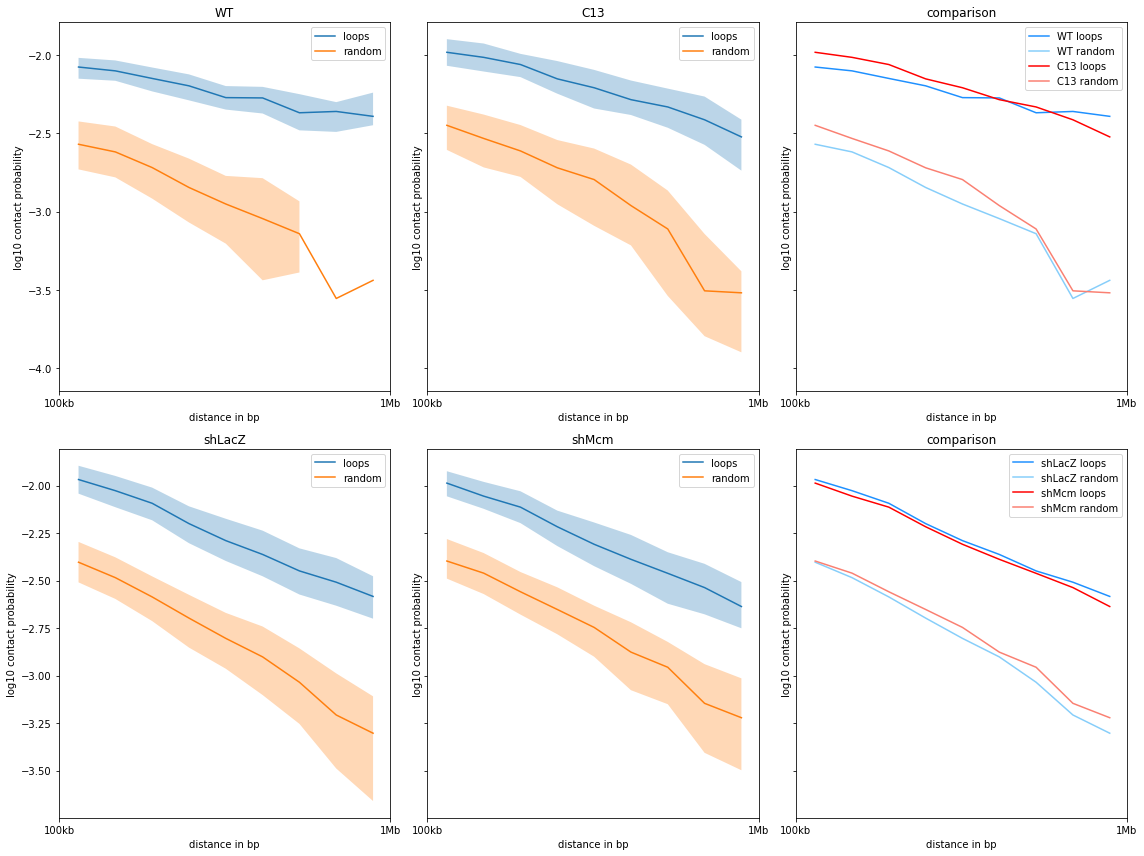

In [176]:
figY, axsY = plt.subplots(2, 3, sharey = 'row')
x = np.linspace(110000, 990000, 9)
for cond in conditions:
    ax = axsY[condaxs[cond]]
    ax.set_title(cond)
    ax.set_ylabel('log10 contact probability')
    ax.set_xlabel('distance in bp')
    ax.set_xlim(np.log10(1e5), np.log10(1e6))
    ax.set_xticks(np.log10([1e5, 1e6]))
    ax.set_xticklabels(['100kb', '1Mb'])
    
    for locitype in ('loops', 'random'):
        data = plotdata[cond][locitype]
        ax.fill_between(np.log10(data['x']), 
                        np.log10(data['ylow']), 
                        np.log10(data['yhigh']), 
                        alpha = 0.3, 
                        zorder = 1)
        ax.plot(np.log10(data['x']), 
                np.log10(data['y']), 
                label = locitype, 
                zorder = 2)
    ax.legend()

wtlocicolors = {'loops': 'dodgerblue', 'random': 'lightskyblue'}
kdlocicolors = {'loops': 'red', 'random': 'salmon'}
colordict = {'WT': wtlocicolors, 'C13': kdlocicolors, 'shLacZ': wtlocicolors, 'shMcm': kdlocicolors}
for i,  vsconds in zip([0, 1], [('WT', 'C13'), ('shLacZ', 'shMcm')]):
    ax = axsY[i, 2]
    ax.set_title('comparison')
    ax.set_ylabel('log10 contact probability')
    ax.set_xlabel('distance in bp')
    ax.set_xlim(np.log10(1e5), np.log10(1e6))
    ax.set_xticks(np.log10([1e5, 1e6]))
    ax.set_xticklabels(['100kb', '1Mb'])
    for cond in vsconds:
        for locitype in ('loops', 'random'):
            ax.plot(np.log10(data['x']),
                    np.log10(plotdata[cond][locitype]['y']),
                    label = f'{cond} {locitype}',
                    c = colordict[cond][locitype])
    
    ax.legend()
    
figY.set_figwidth(16)
figY.set_figheight(12)
figY.tight_layout()
figY.savefig('plots/loop_contact_per_distance.pdf')